<a href="https://colab.research.google.com/github/bernatsort/DeepLearning/blob/main/MLP_CNN_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bernat Sort Rufat

Máster en Data Science

MD008_Artificial Intelligence for Data Science

# Deep Learning Final Project 

# 1_MLP_DenseNetworks

## Objetivos

- Este conjunto de datos contiene información de diferentes asteroides que han pasado o pasarán (1900 - 2200) cerca o relativamente cerca de la Tierra. 
- El objetivo principal es clasificar los asteroides según su rareza.

Pasos:
- Analizar y preparar los datos.
- Construir el modelo. 
- Evaluar los resultados. 



## Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot') # seaborn-v0_8

from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

## Carga de datos

In [ ]:
# Mount Google Drive to store and load files. 
from google.colab import drive
drive.mount('drive') # mounting Google Drive

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/1_MLP_DenseNetworks/NEO_Earth_Close_Approaches.csv'

In [ ]:
# Load dataset
neo_df = pd.read_csv(path, delimiter=',')

## Exploratory Data Analysis (EDA)

El archivo CSV contiene información sobre Objetos Cercanos a la Tierra (NEO) y sus aproximaciones a la Tierra. Cada línea proporciona información sobre la aproximación cercana de un NEO y, por defecto, están ordenadas por hora. Cabe destacar que el 99.9% de los objetos que aparecen en esta lista son asteroides, y un número muy reducido de ellos son cometas. 
Incluye 35899 instancias y 9 variables.


Descripción de las variables:

- **Object**: nombre del NEO.

- **Close-Approach (CA) Date**: fecha y la hora de su máxima aproximación.
    - Fecha y hora (TDB) del máximo acercamiento a la Tierra. "Nominal Date" se da con la precisión adecuada. La incertidumbre de 3 sigmas en la hora se da en la columna +/- en formato días_horas:minutos (por ejemplo, "2_15:23" son 2 días, 15 horas, 23 minutos; "< 00:01" es menos de 1 minuto).
    
- **CA DistanceNominal (au)**: distancia nominal a la que el objeto llegará a la Tierra.  Se trata de la distancia más probable a la que se acercará cuando pase cerca de nuestro planeta. La distancia de aproximación (nominal) más probable (centro de la Tierra al centro del NEO), en unidades astronómicas.

- **CA DistanceMinimum (au)**: proporciona información sobre lo más cerca que podría llegar el objeto durante su sobrevuelo, teniendo en cuenta todas las incertidumbres posibles. La distancia mínima posible de aproximación (centro de la Tierra al centro del NEO), en unidades astronómicas. La distancia mínima posible se basa en la elipse de error del plano objetivo terrestre de 3 sigmas.
    - Los acercamientos se miden en distancias lunares (Lunar Distance (LD)), o la distancia media entre la Tierra y la Luna, que es de unas 238803 millas o 384317 kilómetros. 
    - Unidad astronómica (au): distancia media entre la Tierra y el Sol, que es de unos 93 millones de millas o 150 millones de kilómetros.
 
- **V relative(km/s)**: velocidad del objeto respecto a la Tierra en aproximación cercana (close-approach), medida en kilómetros por segundo (km/s).


- **V infinity(km/s)**: velocidad del objeto respecto a una Tierra sin masa en aproximación cercana, medida en kilómetros por segundo (km/s).


- **H(mag)**: Magnitud absoluta del asteroide (en general, una H menor implica un diámetro mayor del asteroide). Sin definir para los cometas.

- **Diameter**: estimación del diámetro del objeto, basada en su luminosidad. 
    - Valor del diámetro cuando se conoce o un rango (mín - máx) estimado utilizando la magnitud absoluta (H) del asteroide y los albedos limitantes de 0.25 y 0.05.
    - El tamaño de estos objetos oscila entre algunos metros y algunas decenas de kilómetros. Pero hay que tener en cuenta que hay muchísimos más acercamientos de objetos más pequeños que sólo miden unos pocos metros en comparación con los objetos cercanos a la Tierra más grandes, que miden kilómetros. 
    
- **Rarity**: medida de qué tan poco frecuente es el acercamiento de la Tierra para asteroides del mismo tamaño o más grandes. 
    - 0 significa una frecuencia promedio de 100 por año, es decir, aproximadamente cada pocos días o menos
    - 1 corresponde a aproximadamente una vez al mes.
    - 2 a aproximadamente una vez al año.
    - 3 a aproximadamente una vez por década, etc, hasta 6. 
    - 'n/a' significa que no está disponible una estimación de frecuencia.

In [ ]:
# Checking the dataset
nrow, ncol = neo_df.shape
print(f'Hay {nrow} filas y {ncol} columnas\n')
display(neo_df.head()) # de forma predefinida retorna las primeras 5 observations
display(neo_df.tail()) # de forma predefinida retorna las últimas 5 observations

Hay 35899 filas y 9 columnas



Object      Close-Approach (CA) Date  \
0       509352 (2007 AG)  1900-Jan-04 22:25 ±    00:02   
1           (2014 SC324)  1900-Jan-11 01:07 ±    00:18   
2           (2012 UK171)  1900-Jan-12 23:07 ±    00:13   
3  4660 Nereus (1982 DB)  1900-Jan-29 18:10 ±    00:35   
4            (2015 RW83)  1900-Feb-04 03:50 ±    14:49   

   CA DistanceNominal (au)  CA DistanceMinimum (au)  V relative(km/s)  \
0                  0.00963                  0.00962              8.69   
1                  0.03997                  0.03991             10.65   
2                  0.04982                  0.04950              7.16   
3                  0.02080                  0.02077              5.54   
4                  0.03312                  0.03258              3.14   

   V infinity(km/s)  H(mag)        Diameter  Rarity  
0              8.65    20.2  250 m -  550 m     2.0  
1             10.65    24.3   37 m -   82 m     0.0  
2              7.15    24.4   34 m -   77 m     0.0  
3              5.52    18.6    0.33±0.05 km     2.0  
4              3.12    24.1   40 m -   90 m     0.0

Object      Close-Approach (CA) Date  \
35894          (2017 UH5)  2200-Oct-29 07:16 ±    00:02   
35895   475534 (2006 TS7)   2200-Nov-01 07:43 ± < 00:01   
35896   413577 (2005 UL5)  2200-Nov-23 02:10 ±    00:09   
35897        (2014 WT202)  2200-Nov-23 03:36 ±    00:04   
35898  163696 (2003 EB50)   2200-Nov-26 06:30 ± < 00:01   

       CA DistanceNominal (au)  CA DistanceMinimum (au)  V relative(km/s)  \
35894                  0.04891                  0.04890              6.60   
35895                  0.01148                  0.01148             17.73   
35896                  0.01482                  0.01457             18.17   
35897                  0.04197                  0.04170             12.00   
35898                  0.04643                  0.04643             21.34   

       V infinity(km/s)  H(mag)          Diameter  Rarity  
35894              6.59    26.6     13 m -   28 m     0.0  
35895             17.72    21.3    150 m -  330 m     2.0  
35896             18.16    20.3    230 m -  510 m     2.0  
35897             11.99    21.1    160 m -  360 m     1.0  
35898             21.34    16.4  1.4 km -  3.1 km     2.0

In [ ]:
# Info de las columnas del df
neo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35899 entries, 0 to 35898
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Object                    35899 non-null  object 
 1   Close-Approach (CA) Date  35899 non-null  object 
 2   CA DistanceNominal (au)   35899 non-null  float64
 3   CA DistanceMinimum (au)   35899 non-null  float64
 4   V relative(km/s)          35899 non-null  float64
 5   V infinity(km/s)          35877 non-null  float64
 6   H(mag)                    35890 non-null  float64
 7   Diameter                  35891 non-null  object 
 8   Rarity                    35890 non-null  float64
dtypes: float64(6), object(3)
memory usage: 2.5+ MB


- Las columnas "Object", "Close-Approach (CA) Date" y "Diameter" son de tipo object, mientras que las otras columnas son de tipo float64.
- Observamos que las columnas V infinity(km/s), H(mag), Diameter y Rarity presentan missing values.  
- Rarity en realidad es una variable categórica que toma los valores del 0 al 6. Por lo tanto, la convertiremos de numérica a categórica.

In [ ]:
# convertimos Rarity de numérica a categórica
neo_df['Rarity'] = neo_df['Rarity'].astype('object')
print(neo_df['Rarity'].dtype)

object


In [ ]:
neo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35899 entries, 0 to 35898
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Object                    35899 non-null  object 
 1   Close-Approach (CA) Date  35899 non-null  object 
 2   CA DistanceNominal (au)   35899 non-null  float64
 3   CA DistanceMinimum (au)   35899 non-null  float64
 4   V relative(km/s)          35899 non-null  float64
 5   V infinity(km/s)          35877 non-null  float64
 6   H(mag)                    35890 non-null  float64
 7   Diameter                  35891 non-null  object 
 8   Rarity                    35890 non-null  object 
dtypes: float64(5), object(4)
memory usage: 2.5+ MB


In [ ]:
# Summary statistics
neo_df.describe()

CA DistanceNominal (au)  CA DistanceMinimum (au)  V relative(km/s)  \
count             35899.000000             35899.000000      35899.000000   
mean                  0.027882                 0.024017         10.407677   
std                   0.013840                 0.014188          5.393484   
min                   0.000050                 0.000000          0.140000   
25%                   0.016700                 0.011810          6.590000   
50%                   0.029000                 0.023850          9.360000   
75%                   0.039790                 0.036050         13.160000   
max                   0.050000                 0.050000         42.920000   

       V infinity(km/s)        H(mag)  
count      35877.000000  35890.000000  
mean          10.384499     24.860669  
std            5.400947      2.653903  
min            0.220000     13.900000  
25%            6.560000     23.400000  
50%            9.340000     25.300000  
75%           13.140000     26.700000  
max           42.910000     33.200000

- El método df.describe() genera estadísticas descriptivas de un df. Obtenemos el recuento, la media, la desviación estándar, el mínimo, el primer cuartil (25%), la mediana (50%), el tercer cuartil (75%) y el máximo de cada columna.

- Esta información puede ser útil para comprender la distribución y el rango de valores de cada columna del df.

- En general, en todas las variables, los valores de la media y la mediana están relativamente próximos.



In [ ]:
# número único de NEOs
neo_df['Object'].nunique()

13848

### Distribución las variables numéricas



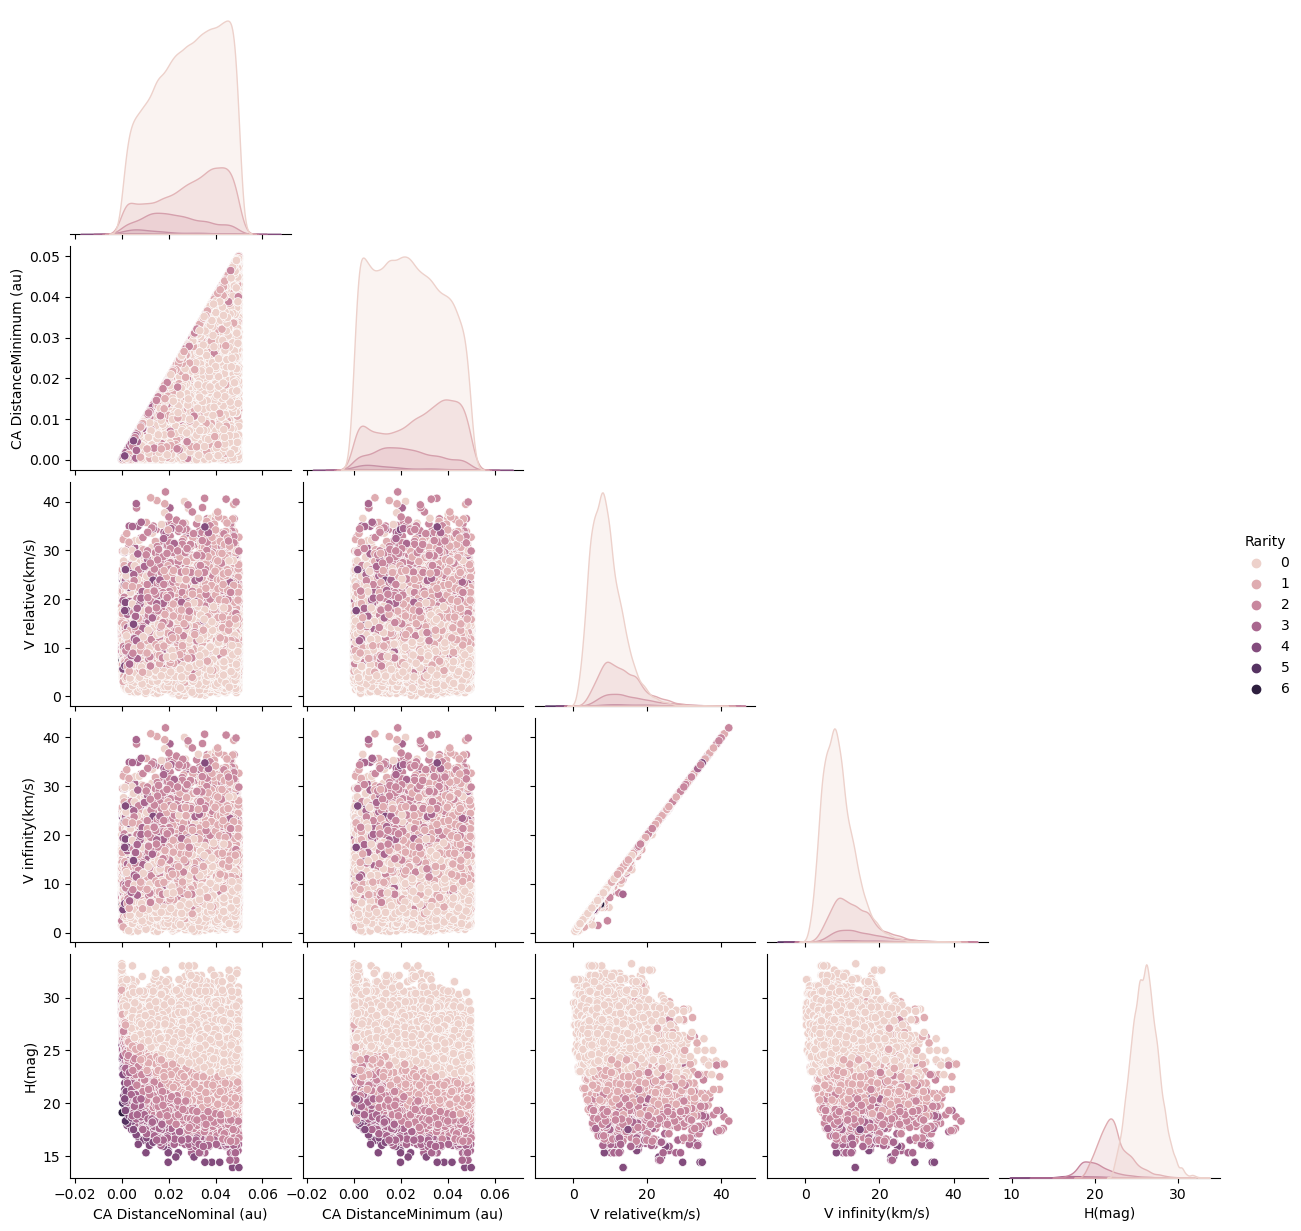

In [ ]:
# gráfico de pares para todas las variables numéricas
sns.pairplot(neo_df, hue='Rarity', corner=True)

- Cada punto en el gráfico representa una observación y la distribución conjunta de dos variables se muestra en los paneles de diagonal. 
- Los paneles no diagonales muestran una dispersión bidimensional de dos variables.



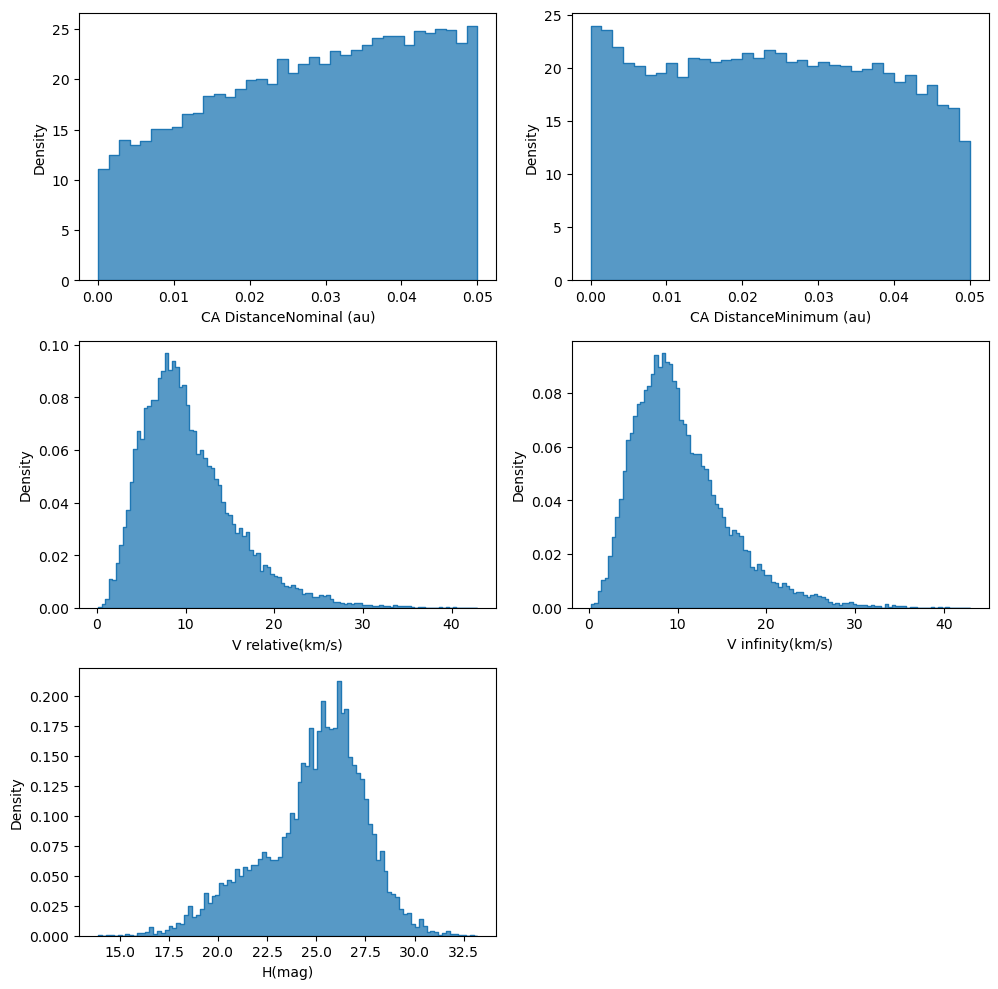

In [ ]:
# creating a figure and a 3x2 grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

# numeric columns
num_cols = neo_df.select_dtypes(include=[np.number])
num_col_names = num_cols.columns

# loop through the subplots and column names to plot the histograms
for i, ax in enumerate(axs.flat):
    if i < len(num_col_names):
        sns.histplot(data=neo_df, x=num_col_names[i], element='step', stat='density', ax=ax)
        ax.set(xlabel=num_col_names[i], ylabel='Density')
    else:
        # remove empty subplot
        fig.delaxes(ax)

# adjusting the spacing between the subplots
plt.tight_layout()

# showing the plot
plt.show()

- Observamos que "V relative(km/s)" y "V infinity(km/s)" presentan una asimetría positiva mientras que "H(mag)" parece presentar una ligera asimetría negativa. 

### Distribución de las variables categóricas

#### Object

In [ ]:
# Checking data imbalance 
print(neo_df['Object'].value_counts()) # recuento de instancias de cada clase en el df

(2022 YG)             50
(2019 SF6)            46
(2019 BE5)            40
(2010 VQ)             38
(1998 SD9)            32
                      ..
(2016 MK)              1
(2016 OA)              1
(2016 NE56)            1
(2016 NK33)            1
163696 (2003 EB50)     1
Name: Object, Length: 13848, dtype: int64


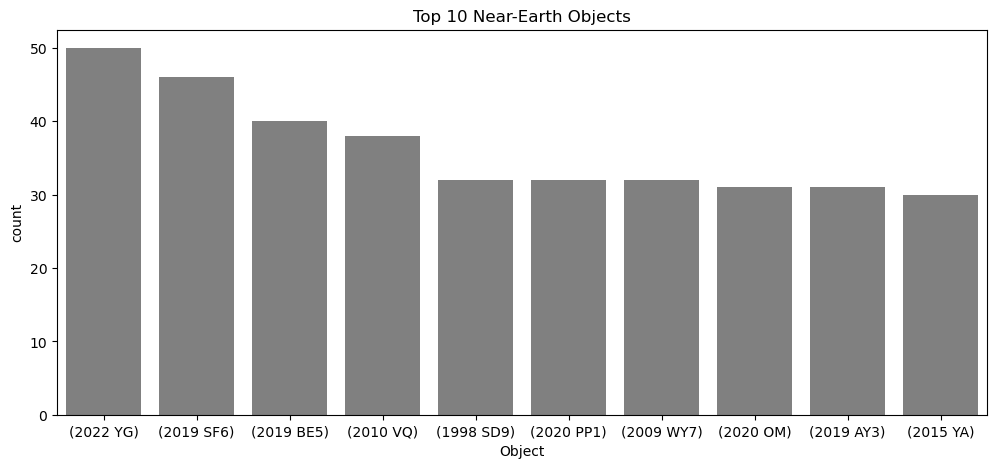

In [ ]:
# Top 10 objects
fig, axs = plt.subplots(figsize=(12, 5))
sns.countplot(x=neo_df['Object'], color='grey', order=neo_df['Object'].value_counts().head(10).index)
plt.title('Top 10 Near-Earth Objects')
plt.show()

#### Rarity (target variable)

In [ ]:
# Checking data imbalance 
print(neo_df['Rarity'].value_counts()) # recuento de instancias de cada clase en el df

0.0    26028
1.0     7203
2.0     2269
3.0      336
4.0       51
5.0        2
6.0        1
Name: Rarity, dtype: int64


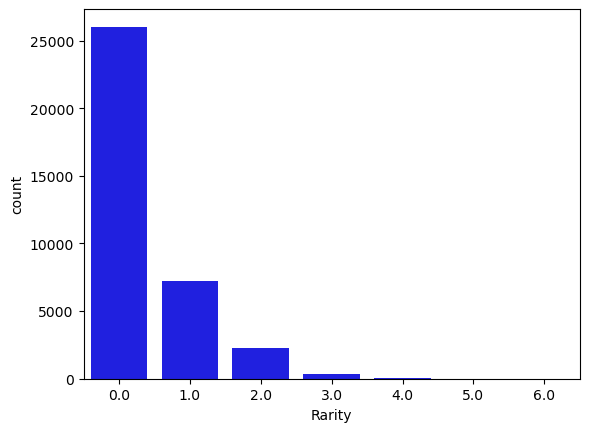

In [ ]:
sns.countplot(x = neo_df['Rarity'], color = 'blue')
plt.show()

- Observamos un claro desbalanceo de clases en la variable objetivo Rarity. 

#### Close-Approach (CA) Date

In [ ]:
# Checking data imbalance 
print(neo_df['Close-Approach (CA) Date'].value_counts()) # recuento de instancias de cada clase en el df

2021-Oct-06 01:57 ± < 00:01     2
2022-Mar-17 09:18 ± < 00:01     2
2017-Oct-20 14:32 ± < 00:01     2
2019-Feb-26 19:24 ± < 00:01     2
2020-Feb-20 16:21 ± < 00:01     2
                               ..
2012-Feb-19 20:38 ± < 00:01     1
2012-Feb-18 17:42 ±    00:02    1
2012-Feb-18 10:14 ± 2_20:22     1
2012-Feb-18 04:41 ±    00:02    1
2200-Nov-26 06:30 ± < 00:01     1
Name: Close-Approach (CA) Date, Length: 35894, dtype: int64


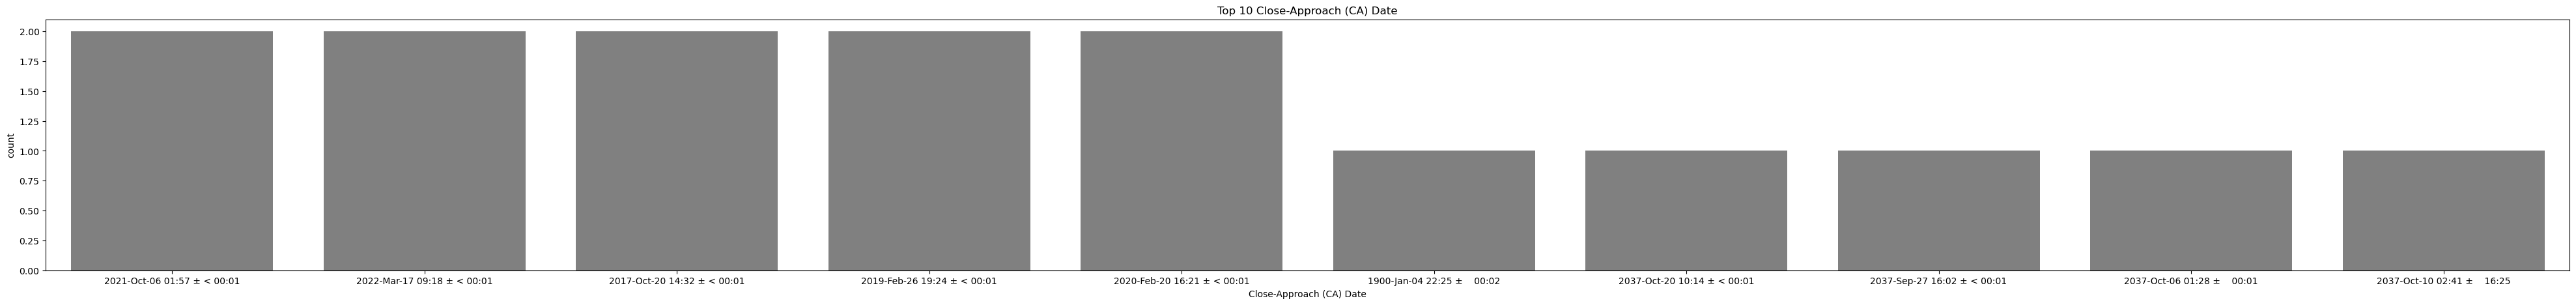

In [ ]:
# Top 10 Close-Approach (CA) Date
fig, axs = plt.subplots(figsize=(50, 5))
sns.countplot(x=neo_df['Close-Approach (CA) Date'], color='grey', order=neo_df['Close-Approach (CA) Date'].value_counts().head(10).index)
plt.title('Top 10 Close-Approach (CA) Date')
plt.show()

#### Diameter

In [ ]:
# Checking data imbalance 
print(neo_df['Diameter'].value_counts()) # recuento de instancias de cada clase en el df

15 m -   34 m       689
16 m -   36 m       672
15 m -   33 m       617
13 m -   28 m       607
22 m -   49 m       578
                   ... 
0.077±0.019 km        1
0.060±0.014 km        1
0.047±0.015 km        1
0.072±0.020 km        1
1.4 km -  3.1 km      1
Name: Diameter, Length: 819, dtype: int64


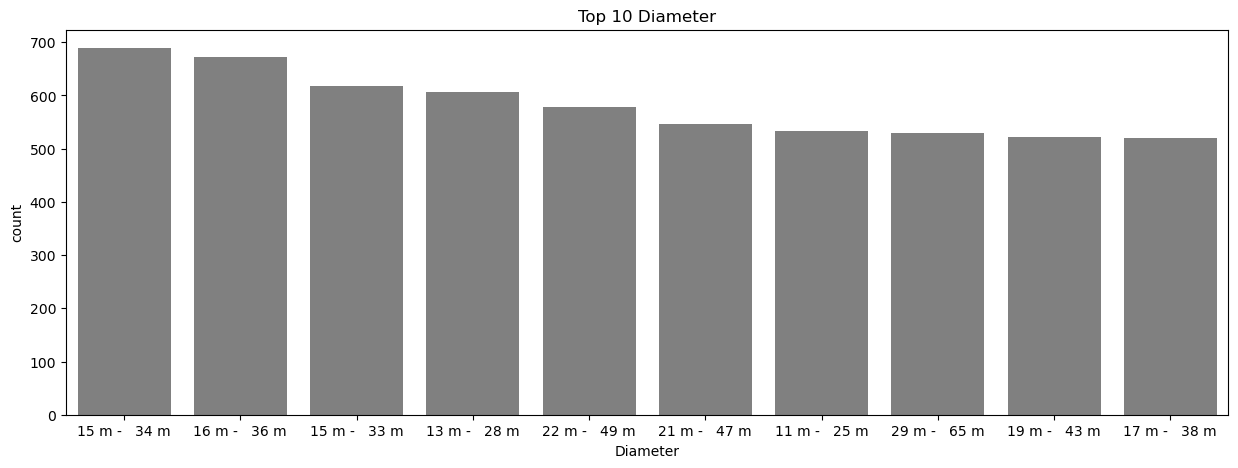

In [ ]:
# Top 10 Diameter
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=neo_df['Diameter'], color='grey', order=neo_df['Diameter'].value_counts().head(10).index)
plt.title('Top 10 Diameter')
plt.show()

### Relación entre los atributos y la variable objetivo Rarity

#### Atributos numéricos

In [ ]:
# variables numéricas
num_vars = ['CA DistanceNominal (au)', 'CA DistanceMinimum (au)','V relative(km/s)', 'V infinity(km/s)', 'H(mag)']
# seleccionar las columnas numéricas y la variable objetivo
num_target_df = neo_df[num_vars + ["Rarity"]]

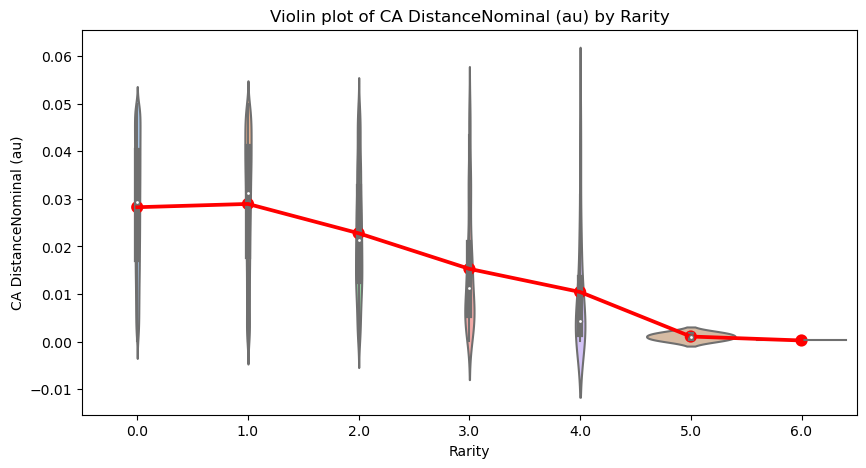

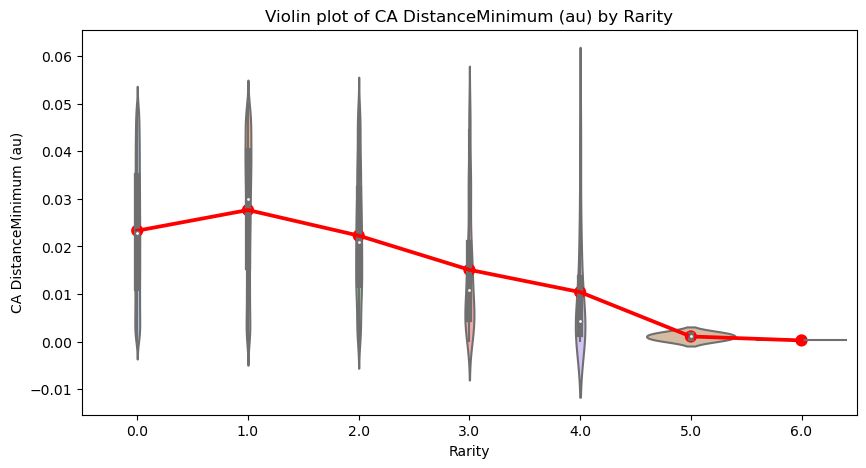

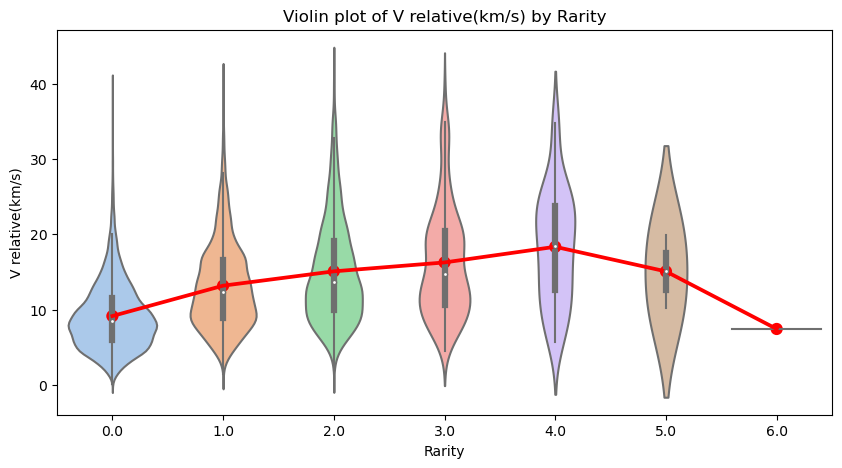

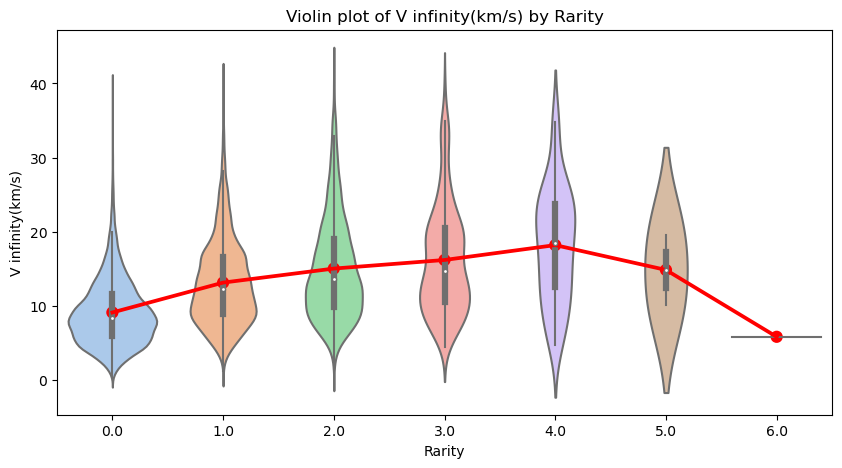

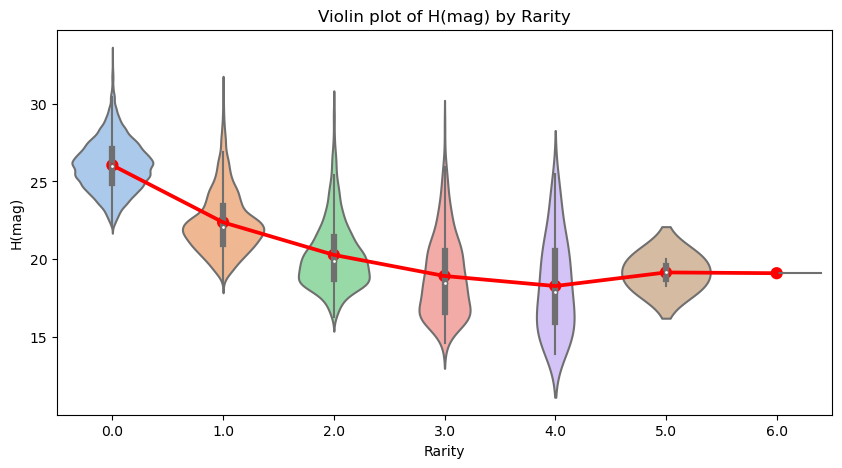

In [ ]:
# Crear un gráfico de violín para cada variable numérica y la variable objetivo
for var in num_vars:
    fig, axs = plt.subplots(figsize=(10, 5))
    sns.violinplot(x=num_target_df["Rarity"], y=num_target_df[var], palette="pastel")
    # Configurar el título y las etiquetas de los ejes
    plt.title("Violin plot of " + var + " by Rarity")
    plt.xlabel("Rarity")
    plt.ylabel(var)
    
    # Agregar un punto rojo para la media de cada grupo
    sns.pointplot(x=num_target_df["Rarity"], y=num_target_df[var], color="red", markers="o", linestyles="-", errorbar=None)
    
    # Mostrar el gráfico
    plt.show()

#### Atributos categóricos


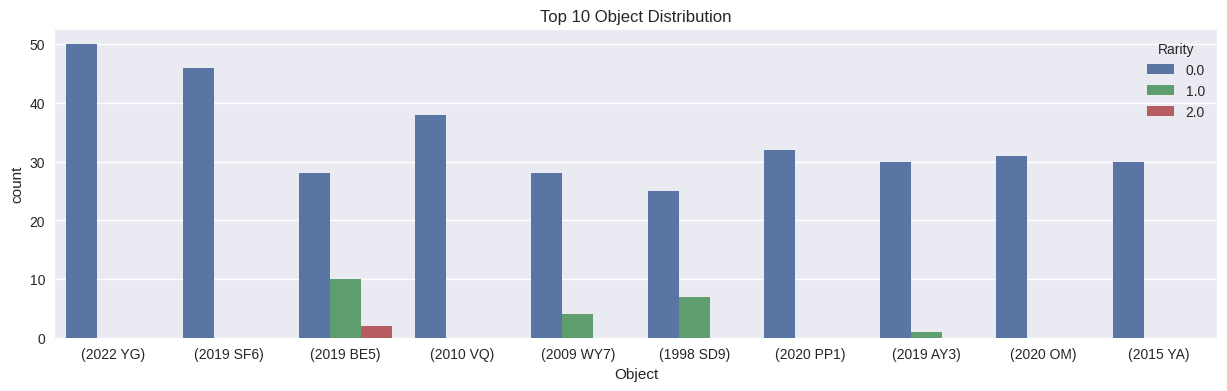

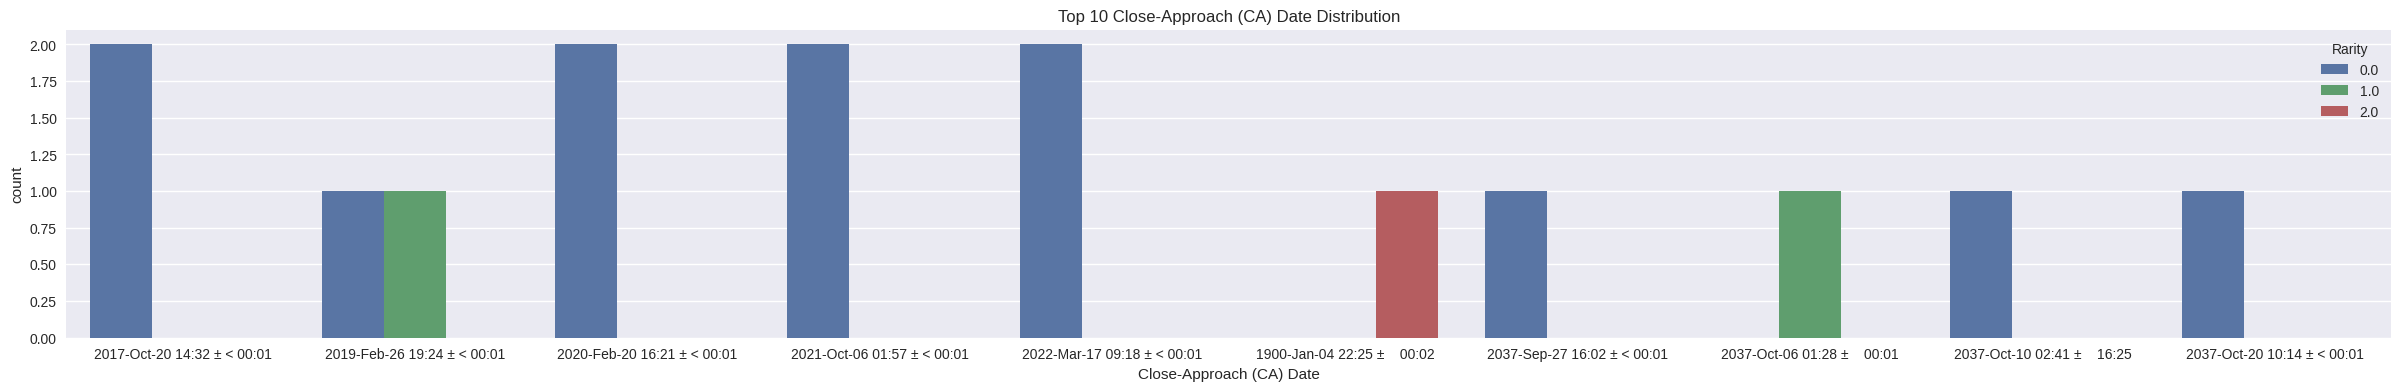

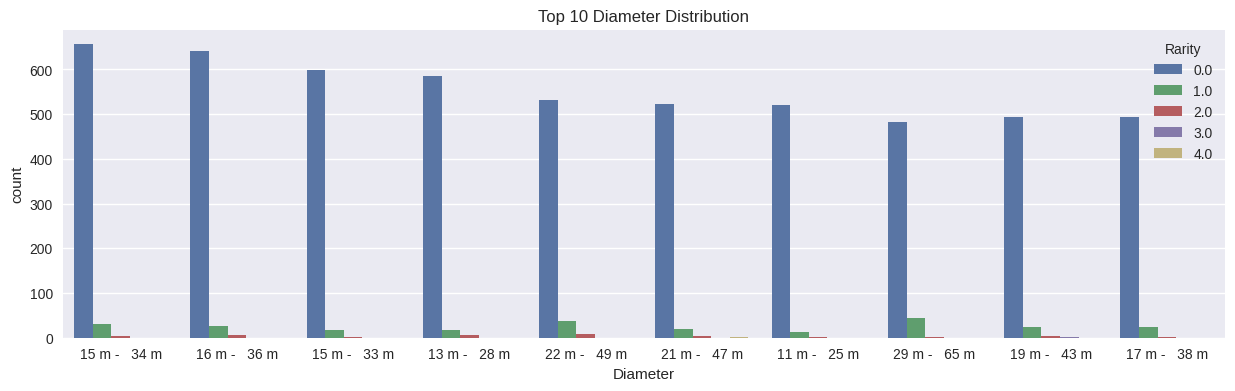

In [ ]:
# Seleccionar el top 10 de las variables 'Object', 'Close-Approach (CA) Date', 'Diameter'
top_10_obj = neo_df['Object'].value_counts().head(10).index
top_10_date = neo_df['Close-Approach (CA) Date'].value_counts().head(10).index
top_10_diam = neo_df['Diameter'].value_counts().head(10).index

# Subset con el top 10 de cada variable
subset_top_10_object = neo_df[neo_df['Object'].isin(top_10_obj)]
subset_top_10_date = neo_df[neo_df['Close-Approach (CA) Date'].isin(top_10_date)]
subset_top_10_diam = neo_df[neo_df['Diameter'].isin(top_10_diam)]

# Gráficos de barras del top 10 de cada variable en orden descendente de recuento
# Gráfico para el top 10 de 'Object'
fig, axs = plt.subplots(figsize=(15, 4))
sns.countplot(x=subset_top_10_object['Object'], data=subset_top_10_object, hue='Rarity', order=subset_top_10_object['Object'].value_counts().index)
plt.title('Top 10 Object Distribution')
plt.show()

# Gráfico para el top 10 de 'Close-Approach (CA) Date'
fig, axs = plt.subplots(figsize=(30, 4))
sns.countplot(x=subset_top_10_date['Close-Approach (CA) Date'], data=subset_top_10_date, hue='Rarity', order=subset_top_10_date['Close-Approach (CA) Date'].value_counts().index)
plt.title('Top 10 Close-Approach (CA) Date Distribution')
plt.show()

# Gráfico para el top 10 de 'Diameter'
fig, axs = plt.subplots(figsize=(15, 4))
sns.countplot(x=subset_top_10_diam['Diameter'], data=subset_top_10_diam, hue='Rarity', order=subset_top_10_diam['Diameter'].value_counts().index)
plt.title('Top 10 Diameter Distribution')
plt.show()

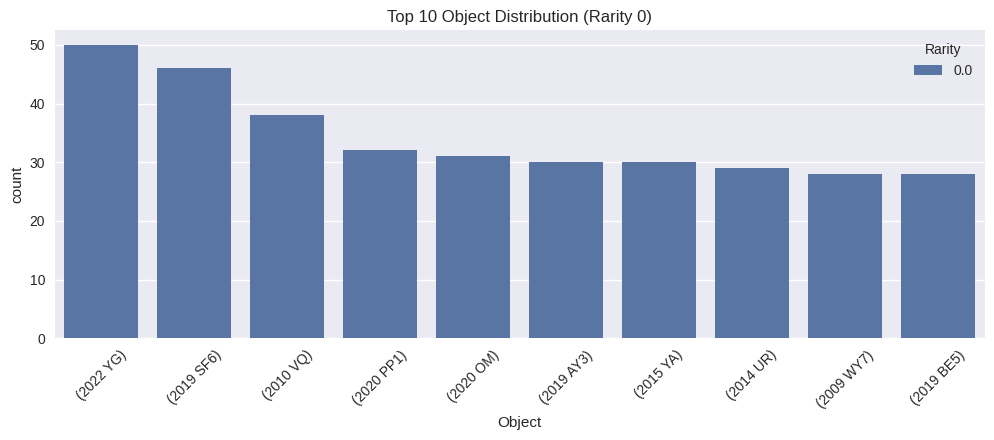

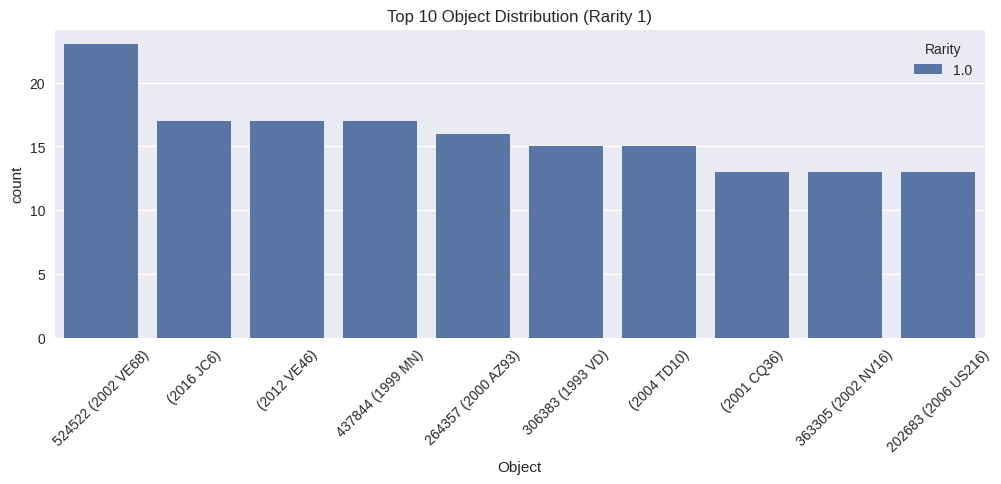

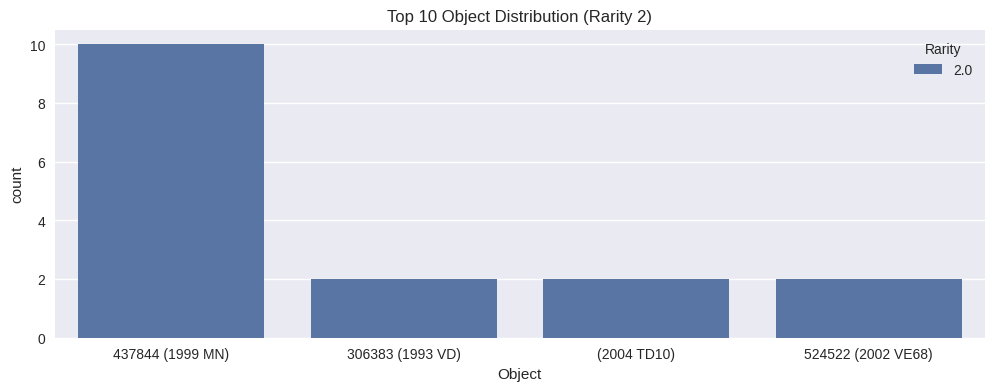

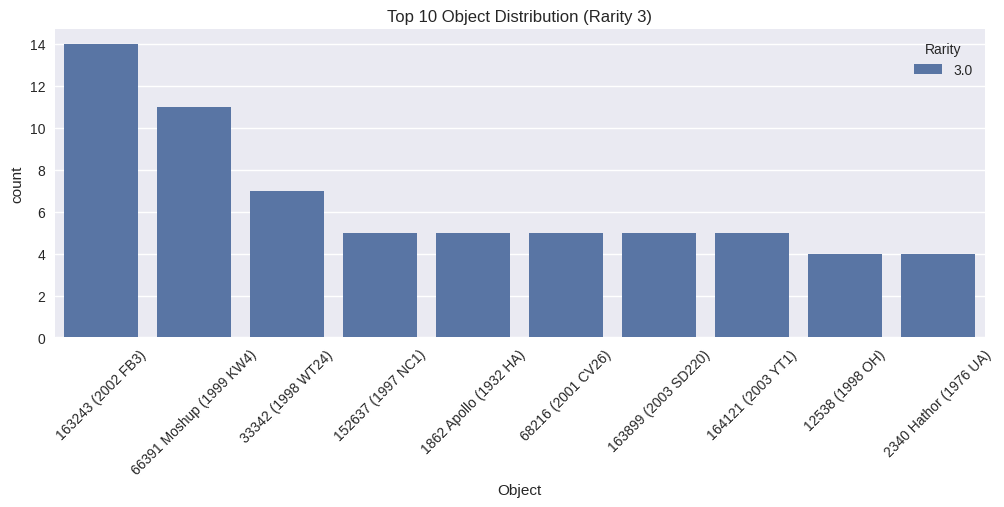

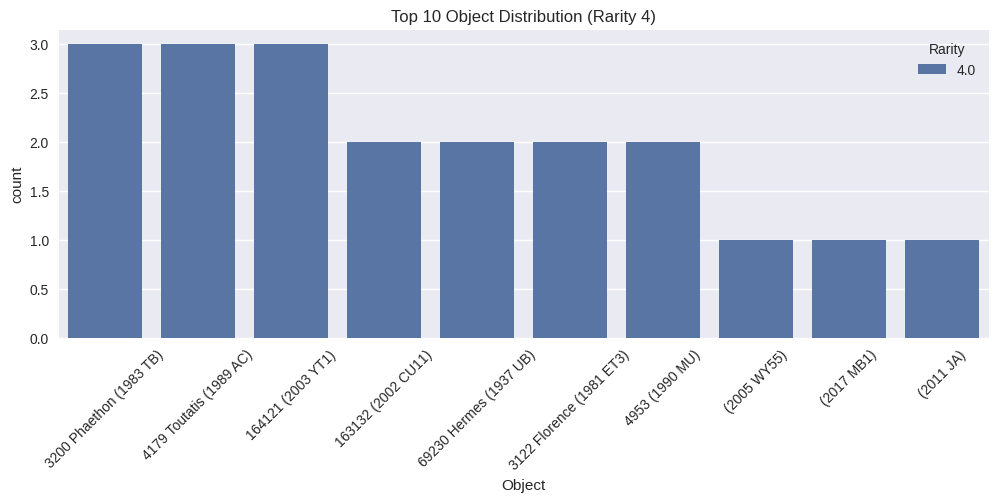

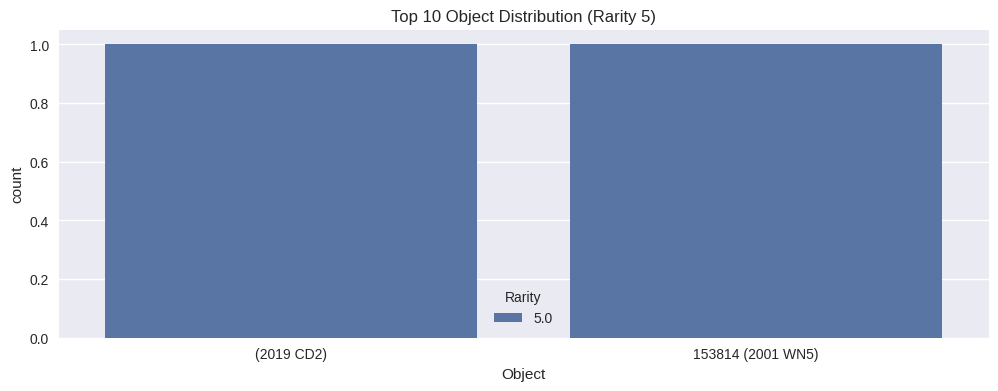

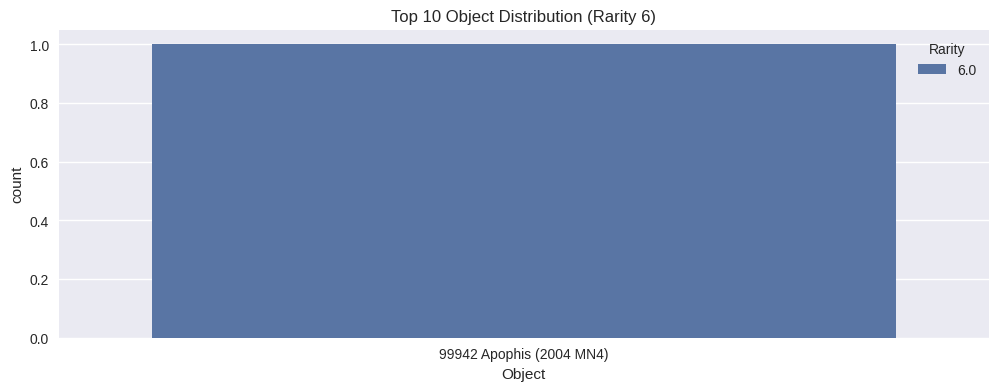

In [ ]:
# subset Rarity 0 
rar_zero = neo_df[neo_df['Rarity']==0.0]
# top 10 object with rarity 0
top_10_obj_rar_zero = rar_zero['Object'].value_counts().head(10).index
top_10_obj_rar_zero_df = rar_zero[rar_zero['Object'].isin(top_10_obj_rar_zero)]

# plot
fig, axs = plt.subplots(figsize=(12, 4))
sns.countplot(x=top_10_obj_rar_zero_df['Object'], data=top_10_obj_rar_zero_df, hue='Rarity', order=top_10_obj_rar_zero_df['Object'].value_counts().index)
plt.title('Top 10 Object Distribution (Rarity 0)')
plt.xticks(rotation=45)
plt.show()


# subset Rarity 1
rar_one = neo_df[neo_df['Rarity']==1.0]
# top 10 object with rarity 1
top_10_obj_rar_one = rar_one['Object'].value_counts().head(10).index
top_10_obj_rar_one_df = rar_one[rar_one['Object'].isin(top_10_obj_rar_one)]
# plot
fig, axs = plt.subplots(figsize=(12, 4))
sns.countplot(x=top_10_obj_rar_one_df['Object'], data=top_10_obj_rar_one_df, hue='Rarity', order=top_10_obj_rar_one_df['Object'].value_counts().index)
plt.title('Top 10 Object Distribution (Rarity 1)')
plt.xticks(rotation=45)
plt.show()

# subset Rarity 2
rar_two = neo_df[neo_df['Rarity']==2.0]
# top 10 object with rarity 2
top_10_obj_rar_two = rar_one['Object'].value_counts().head(10).index
top_10_obj_rar_two_df = rar_two[rar_two['Object'].isin(top_10_obj_rar_two)]
# plot
fig, axs = plt.subplots(figsize=(12, 4))
sns.countplot(x=top_10_obj_rar_two_df['Object'], data=top_10_obj_rar_two_df, hue='Rarity', order=top_10_obj_rar_two_df['Object'].value_counts().index)
plt.title('Top 10 Object Distribution (Rarity 2)')
plt.xticks(rotation=0)
plt.show()

# subset Rarity 3
rar_three = neo_df[neo_df['Rarity'] == 3.0]
# top 10 object with rarity 3
top_10_obj_rar_three = rar_three['Object'].value_counts().head(10).index
top_10_obj_rar_three_df = rar_three[rar_three['Object'].isin(top_10_obj_rar_three)]
# plot
fig, axs = plt.subplots(figsize=(12, 4))
sns.countplot(x=top_10_obj_rar_three_df['Object'], data=top_10_obj_rar_three_df, hue='Rarity', order=top_10_obj_rar_three_df['Object'].value_counts().index)
plt.title('Top 10 Object Distribution (Rarity 3)')
plt.xticks(rotation=45)
plt.show()

# subset Rarity 4
rar_four = neo_df[neo_df['Rarity'] == 4.0]
# top 10 object with rarity 4
top_10_obj_rar_four = rar_four['Object'].value_counts().head(10).index
top_10_obj_rar_four_df = rar_four[rar_four['Object'].isin(top_10_obj_rar_four)]
# plot
fig, axs = plt.subplots(figsize=(12, 4))
sns.countplot(x=top_10_obj_rar_four_df['Object'], data=top_10_obj_rar_four_df, hue='Rarity', order=top_10_obj_rar_four_df['Object'].value_counts().index)
plt.title('Top 10 Object Distribution (Rarity 4)')
plt.xticks(rotation=45)
plt.show()

# subset Rarity 5
rar_five = neo_df[neo_df['Rarity'] == 5.0]
# top 10 object with rarity 5
top_10_obj_rar_five = rar_five['Object'].value_counts().head(10).index
top_10_obj_rar_five_df = rar_five[rar_five['Object'].isin(top_10_obj_rar_five)]
# plot
fig, axs = plt.subplots(figsize=(12, 4))
sns.countplot(x=top_10_obj_rar_five_df['Object'], data=top_10_obj_rar_five_df, hue='Rarity', order=top_10_obj_rar_five_df['Object'].value_counts().index)
plt.title('Top 10 Object Distribution (Rarity 5)')
plt.xticks(rotation=0)
plt.show()

# subset Rarity 6
rar_six = neo_df[neo_df['Rarity'] == 6.0]
# top 10 object with rarity 6
top_10_obj_rar_six = rar_six['Object'].value_counts().head(10).index
top_10_obj_rar_six_df = rar_six[rar_six['Object'].isin(top_10_obj_rar_six)]
# plot
fig, axs = plt.subplots(figsize=(12, 4))
sns.countplot(x=top_10_obj_rar_six_df['Object'], data=top_10_obj_rar_six_df, hue='Rarity', order=top_10_obj_rar_six_df['Object'].value_counts().index)
plt.title('Top 10 Object Distribution (Rarity 6)')
plt.xticks(rotation=0)
plt.show()


## Tratamiento de valores nulos

Object                       0
Close-Approach (CA) Date     0
CA DistanceNominal (au)      0
CA DistanceMinimum (au)      0
V relative(km/s)             0
V infinity(km/s)            22
H(mag)                       9
Diameter                     8
Rarity                       9
dtype: int64

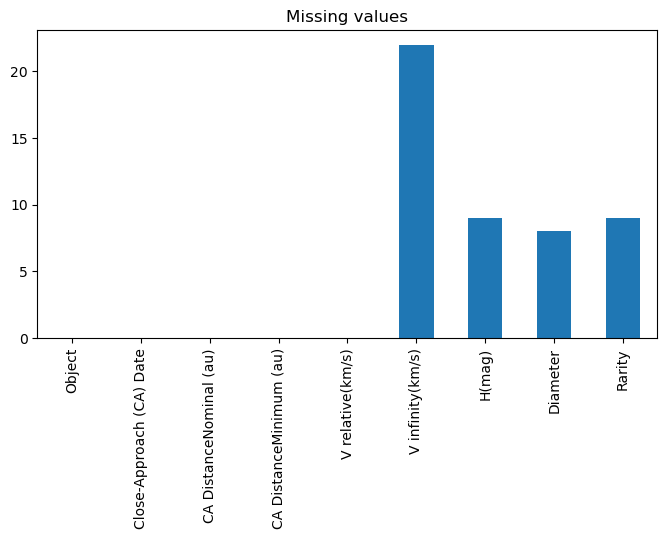

In [ ]:
# valores nulos de cada variable
fig, axs = plt.subplots(figsize=(8, 4))
neo_df.isnull().sum().plot(kind='bar')
plt.title('Missing values')

neo_df.isnull().sum()

- V infinity(km/s): no se conocen 22 velocidades del objeto respecto a una Tierra sin masa en aproximación cercana. 
- H(mag): la magnitud absoluta está sin definir para los cometas, así que seguramente los 9 valores nulos sean de los cometas, no de los asteroides.
- Diameter: no se conoce el diámetro de 8 objetos.
- Rarity: no están disponible 9 estimaciónes de frecuencia.

### Cometas

In [ ]:
# imprimimos fila donde H(mag) tenga valores nulos, ya que serán los cometas (no asteroides)
comet_df = neo_df[neo_df['H(mag)'].isnull()]
print(comet_df.shape)
display(comet_df)

(9, 9)


Object      Close-Approach (CA) Date  \
1379                  289P/Blanpain  1919-Dec-09 03:23 ±    17:35   
1928               7P/Pons-Winnecke   1927-Jun-26 19:36 ± < 00:01   
3607                      322P/SOHO  1947-Apr-11 04:00 ±    02:19   
8805               P/1999 J6 (SOHO)  1999-Jun-12 05:23 ±    05:55   
9467                  289P/Blanpain  2003-Dec-12 01:21 ±    00:29   
14090                   252P/LINEAR   2016-Mar-21 13:16 ± < 00:01   
14093       P/2016 BA14 (PANSTARRS)   2016-Mar-22 15:31 ± < 00:01   
26164                    15P/Finlay  2060-Oct-22 17:23 ±    00:11   
30738  73P/Schwassmann-Wachmann 3-B  2109-Jul-20 21:44 ±    01:35   

       CA DistanceNominal (au)  CA DistanceMinimum (au)  V relative(km/s)  \
1379                   0.04720                  0.04720             11.41   
1928                   0.03938                  0.03938             13.91   
3607                   0.04744                  0.04643             40.46   
8805                   0.01196                  0.00239             42.92   
9467                   0.02501                  0.02497              9.05   
14090                  0.03563                  0.03563             10.56   
14093                  0.02366                  0.02366             14.01   
26164                  0.03343                  0.03342             12.55   
30738                  0.03559                  0.03472             11.95   

       V infinity(km/s)  H(mag) Diameter Rarity  
1379              11.41     NaN      NaN    NaN  
1928              13.90     NaN   5.2 km    NaN  
3607              40.46     NaN      NaN    NaN  
8805              42.91     NaN      NaN    NaN  
9467               9.03     NaN      NaN    NaN  
14090             10.55     NaN      NaN    NaN  
14093             14.00     NaN      NaN    NaN  
26164             12.54     NaN      NaN    NaN  
30738             11.94     NaN      NaN    NaN

In [ ]:
print(comet_df['Object'].unique())
print(comet_df['Object'].nunique())

['289P/Blanpain' '7P/Pons-Winnecke' '322P/SOHO' 'P/1999 J6 (SOHO)'
 '252P/LINEAR' 'P/2016 BA14 (PANSTARRS)' '15P/Finlay'
 '73P/Schwassmann-Wachmann 3-B']
8


- Tenemos 9 registros de cometas y 8 cometas (únicos).

In [ ]:
# valores nulos de los cometas
comet_df.isnull().sum()

Object                      0
Close-Approach (CA) Date    0
CA DistanceNominal (au)     0
CA DistanceMinimum (au)     0
V relative(km/s)            0
V infinity(km/s)            0
H(mag)                      9
Diameter                    8
Rarity                      9
dtype: int64

- Observamos que los valores nulos de H(mag), Diameter y Rarity pertenecen a los cometas, mientras que los 22 valores nulos de V infinity(km/s) son de los asteroides.

- Como el objetivo principal es clasificar los asteroides según su rareza, y ningún cometa tiene valores de rareza (todos son NA values en Rarity), es razonable eliminar los cometas de nuestro estudio. 


In [ ]:
# Eliminamos los cometas de nuestro dataset: eliminar todas las filas en las que la columna "H(mag)" sea nula
neo_asteroids_df = neo_df.dropna(axis=0, subset=['H(mag)'])

In [ ]:
# original df
print(neo_df.shape)
# asteroids (no comets) df
print(neo_asteroids_df.shape)

(35899, 9)
(35890, 9)


- Observamos que ya no tenemos las filas de los cometas. Nuestro dataset ahora contiene solo los asteroides. 

### Asteroides

In [ ]:
# valores nulos del neo_asteroids_df
neo_asteroids_df.isnull().sum()

Object                       0
Close-Approach (CA) Date     0
CA DistanceNominal (au)      0
CA DistanceMinimum (au)      0
V relative(km/s)             0
V infinity(km/s)            22
H(mag)                       0
Diameter                     0
Rarity                       0
dtype: int64

- Ahora tenemos que tratar los missing values de V infinity(km/s): no se conocen 22 velocidades del objeto respecto a una Tierra sin masa en aproximación cercana.

In [ ]:
# imprimimos filas donde 'V infinity(km/s)' tenga valores nulos
neo_asteroids_df[neo_asteroids_df['V infinity(km/s)'].isnull()]

Object      Close-Approach (CA) Date  CA DistanceNominal (au)  \
5580    (2012 TF79)   1967-Jan-20 03:00 ± 4_00:34                  0.03550   
10111  (2006 RH120)   2006-Sep-11 07:40 ± < 00:01                  0.00561   
10209  (2006 RH120)   2007-Jan-03 18:02 ± < 00:01                  0.00357   
10281  (2006 RH120)   2007-Mar-25 12:32 ± < 00:01                  0.00236   
10320  (2006 RH120)   2007-Jun-14 05:31 ± < 00:01                  0.00185   
15158    (2020 CD3)   2017-Sep-18 06:00 ± < 00:01                  0.00134   
15476    (2020 CD3)   2017-Dec-06 09:22 ± < 00:01                  0.00166   
15691    (2020 CD3)   2018-Feb-19 08:28 ± < 00:01                  0.00149   
15902    (2020 CD3)   2018-May-09 13:48 ± < 00:01                  0.00017   
16058    (2020 CD3)   2018-Aug-09 12:37 ± < 00:01                  0.00204   
16284    (2020 CD3)   2018-Oct-26 00:10 ± < 00:01                  0.00215   
16535    (2020 CD3)   2019-Jan-16 17:12 ± < 00:01                  0.00108   
16782    (2020 CD3)   2019-Apr-04 09:33 ± < 00:01                  0.00009   
17020    (2020 CD3)   2019-Jun-30 17:27 ± < 00:01                  0.00185   
17175    (2020 CD3)   2019-Sep-10 04:00 ± < 00:01                  0.00202   
17537    (2020 CD3)   2019-Nov-18 13:04 ± < 00:01                  0.00194   
17895    (2020 CD3)   2020-Feb-13 16:20 ± < 00:01                  0.00031   
21464    (2022 NX1)   2022-Jun-26 20:23 ± < 00:01                  0.00543   
23106  (2006 RH120)   2028-Aug-18 13:41 ± 4_02:14                  0.02686   
24505  (2006 RH120)   2043-Nov-12 09:11 ± 6_05:33                  0.01019   
24529    (2020 CD3)  2044-Mar-20 10:43 ±    00:36                  0.02444   
26256    (2020 CD3)  2061-Aug-20 04:39 ±    13:21                  0.03324   

       CA DistanceMinimum (au)  V relative(km/s)  V infinity(km/s)  H(mag)  \
5580                   0.03502              0.28               NaN    27.4   
10111                  0.00561              0.86               NaN    29.5   
10209                  0.00357              1.04               NaN    29.5   
10281                  0.00236              1.37               NaN    29.5   
10320                  0.00185              1.57               NaN    29.5   
15158                  0.00134              1.89               NaN    31.7   
15476                  0.00166              1.67               NaN    31.7   
15691                  0.00149              1.77               NaN    31.7   
15902                  0.00017              5.53               NaN    31.7   
16058                  0.00204              1.48               NaN    31.7   
16284                  0.00215              1.45               NaN    31.7   
16535                  0.00108              2.13               NaN    31.7   
16782                  0.00009              7.77               NaN    31.7   
17020                  0.00185              1.56               NaN    31.7   
17175                  0.00202              1.47               NaN    31.7   
17537                  0.00194              1.54               NaN    31.7   
17895                  0.00031              4.07               NaN    31.7   
21464                  0.00543              0.96               NaN    28.1   
23106                  0.02609              0.14               NaN    29.5   
24505                  0.00280              0.64               NaN    29.5   
24529                  0.02444              0.22               NaN    31.7   
26256                  0.03289              0.38               NaN    31.7   

             Diameter Rarity  
5580   8.9 m -   20 m    0.0  
10111  3.3 m -  7.5 m    0.0  
10209  3.3 m -  7.5 m    0.0  
10281  3.3 m -  7.5 m    0.0  
10320  3.3 m -  7.5 m    0.0  
15158  1.2 m -  2.7 m    0.0  
15476  1.2 m -  2.7 m    0.0  
15691  1.2 m -  2.7 m    0.0  
15902  1.2 m -  2.7 m    0.0  
16058  1.2 m -  2.7 m    0.0  
16284  1.2 m -  2.7 m    0.0  
16535  1.2 m -  2.7 m    0.0  
16782  1.2 m -  2.7 

- Observamos que para todas las filas donde 'V infinity(km/s)' tiene valores nulos, Rarity es 0. 

#### Eliminación 

Calculamos el porcentaje de missing values en la columna 'V infinity(km/s)' del DataFrame neo_asteroids_df:

In [ ]:
missing_percent = neo_asteroids_df['V infinity(km/s)'].isnull().mean() * 100
print(f"Percentage of missing values in 'V infinity(km/s)': {missing_percent:.2f}%")

Percentage of missing values in 'V infinity(km/s)': 0.06%


- Representan 0.06% del total de filas del dataset. 

Calculamos el porcentaje de missing values en la columna 'V infinity(km/s)' de neo_asteroids_df que corresponden a filas en las que la columna 'Rarity' es igual a 0.0:

In [ ]:
# Número total de valores que faltan en la columna 'V infinity(km/s)' de neo_asteroids_df que corresponden a filas en las que la columna 'Rarity' es igual a 0.0.
neo_asteroids_df['V infinity(km/s)'][neo_asteroids_df['Rarity']==0.0].isnull().count()

26028

In [ ]:
missing_percent_rarity_zero = neo_asteroids_df['V infinity(km/s)'][neo_asteroids_df['Rarity']==0.0].isnull().mean() * 100
print(f"Percentage of missing values in 'V infinity(km/s) when 'Rarity' is 0': {missing_percent_rarity_zero:.2f}%")

Percentage of missing values in 'V infinity(km/s) when 'Rarity' is 0': 0.08%


- Representan 0.08% del total de filas del dataset para Rarity = 0. 

Como en la variable 'V infinity(km/s)' el número de filas con valores nulos es relativamente pequeño en comparación con el tamaño del dataset, simplemente eliminamos esas filas. 
- Tenemos 22 filas con valores nulos de un total de 35890 filas, por lo que éste podría ser un enfoque razonable (estaríamos eliminando un 0.06% del total de filas del dataset).
- Tenemos 22 filas con valores nulos de un total de 26028 filas cuando Rarity es 0, por lo que éste podría ser un enfoque razonable (estaríamos eliminando un 0.08% de filas del dataset donde Rarity es 0).

In [ ]:
# Eliminamos las filas con valores nulos para la variable 'V infinity(km/s)'
neo_asteroids_clean_df = neo_asteroids_df.dropna(axis=0, subset=['V infinity(km/s)'])

print(neo_asteroids_clean_df.isnull().sum(), '\n')
print('\n',neo_asteroids_clean_df.shape)
print('Hemos eliminado',35890-35868, 'filas del dataset')

Object                      0
Close-Approach (CA) Date    0
CA DistanceNominal (au)     0
CA DistanceMinimum (au)     0
V relative(km/s)            0
V infinity(km/s)            0
H(mag)                      0
Diameter                    0
Rarity                      0
dtype: int64 


 (35868, 9)
Hemos eliminado 22 filas del dataset


#### Multiple imputation

Otra opción para tratar los missing values es realizar la imputación múltiple. 
En este caso, realizaremos la imputación múltiple a modo de ejemplo, ya que el método elegido para tratar los missing values ha sido la eliminación debido a la poca cantidad que había. 

Realizamos una imputación múltiple para imputar los valores perdidos en la columna 'V infinity(km/s)' del DataFrame 'neo_asteroids_df' usando el algoritmo MICE (Multiple Imputation by Chained Equations).

- MICE es un algoritmo de imputación que se utiliza cuando los datos faltan de forma aleatoria (MAR), lo que significa que la probabilidad de que falte un valor depende de los datos observados pero no de los datos no observados. El algoritmo MICE imputa los datos que faltan en un proceso de varios pasos en el que cada variable con valores que faltan se imputa varias veces basándose en la distribución condicional de esa variable dadas las demás variables del conjunto de datos.

- En este caso, los valores que faltan en la columna "V infinity(km/s)" se imputan utilizando un modelo de regresión lineal entrenado a partir de los valores no ausentes de esa columna y de las demás variables del conjunto de datos. La imputación se repite varias veces y los valores imputados resultantes se combinan para crear una distribución de valores plausibles para cada valor que falta. La media de esta distribución se utiliza como valor imputado.

- La ventaja de utilizar MICE frente a otros métodos de imputación es que tiene en cuenta la incertidumbre de los valores imputados y produce múltiples conjuntos de datos imputados que pueden utilizarse para análisis posteriores, como la modelización o la comprobación de hipótesis.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# creamos una copia del df
neo_asteroids_clean2_df = neo_asteroids_df.copy()

# crear una copia del DataFrame sólo con la variable 'V infinity(km/s)
v_inf_df = neo_asteroids_df[['V infinity(km/s)']].copy()

# realizar multiple imputation con el MICE algorithm
mice_imputer = IterativeImputer()
v_inf_imputed = mice_imputer.fit_transform(v_inf_df)

# sustituir la columna original "V infinity(km/s)" por los valores imputados
neo_asteroids_clean2_df['V infinity(km/s)'] = v_inf_imputed

In [ ]:
print(neo_asteroids_df[['V infinity(km/s)']].isnull().sum(), '\n')
neo_asteroids_df[['V infinity(km/s)']].describe()

V infinity(km/s)    22
dtype: int64 



V infinity(km/s)
count      35868.000000
mean          10.382456
std            5.396466
min            0.220000
25%            6.560000
50%            9.340000
75%           13.140000
max           41.970000

In [ ]:
print(neo_asteroids_clean2_df[['V infinity(km/s)']].isnull().sum())
neo_asteroids_clean2_df[['V infinity(km/s)']].describe()

V infinity(km/s)    0
dtype: int64


V infinity(km/s)
count      35890.000000
mean          10.382456
std            5.394812
min            0.220000
25%            6.562500
50%            9.340000
75%           13.130000
max           41.970000

## Conversión de types y data manipulation

### Diameter

Hemos observado que la variable Diameter sigue un formato poco convencional. 

Tipos de formato: 
- (1) 0.33±0.05 km
- (2) 0.7 km
- (3) 460 m -  1.0 km
- (4) 250 m -  550 m
- (5) 1.4 km -  3.1 km

Para poder introducir esta variable en nuestro modelo de DL, la trataremos y procesaremos hasta convertirla en una variable numérica. A continuación, crearemos una nueva columna (avg_diam_km) en nuestro dataset, donde guardaremos el diámetro medio (en km) por asteroide. 

In [ ]:
# copy of df
df_m_to_km = neo_asteroids_clean_df.copy()
df_m_to_km["avg_diam_km"] = ""
df_m_to_km 

Object      Close-Approach (CA) Date  \
0           509352 (2007 AG)  1900-Jan-04 22:25 ±    00:02   
1               (2014 SC324)  1900-Jan-11 01:07 ±    00:18   
2               (2012 UK171)  1900-Jan-12 23:07 ±    00:13   
3      4660 Nereus (1982 DB)  1900-Jan-29 18:10 ±    00:35   
4                (2015 RW83)  1900-Feb-04 03:50 ±    14:49   
...                      ...                           ...   
35894             (2017 UH5)  2200-Oct-29 07:16 ±    00:02   
35895      475534 (2006 TS7)   2200-Nov-01 07:43 ± < 00:01   
35896      413577 (2005 UL5)  2200-Nov-23 02:10 ±    00:09   
35897           (2014 WT202)  2200-Nov-23 03:36 ±    00:04   
35898     163696 (2003 EB50)   2200-Nov-26 06:30 ± < 00:01   

       CA DistanceNominal (au)  CA DistanceMinimum (au)  V relative(km/s)  \
0                      0.00963                  0.00962              8.69   
1                      0.03997                  0.03991             10.65   
2                      0.04982                  0.04950              7.16   
3                      0.02080                  0.02077              5.54   
4                      0.03312                  0.03258              3.14   
...                        ...                      ...               ...   
35894                  0.04891                  0.04890              6.60   
35895                  0.01148                  0.01148             17.73   
35896                  0.01482                  0.01457             18.17   
35897                  0.04197                  0.04170             12.00   
35898                  0.04643                  0.04643             21.34   

       V infinity(km/s)  H(mag)          Diameter Rarity avg_diam_km  
0                  8.65    20.2    250 m -  550 m    2.0              
1                 10.65    24.3     37 m -   82 m    0.0              
2                  7.15    24.4     34 m -   77 m    0.0              
3                  5.52    18.6      0.33±0.05 km    2.0              
4                  3.12    24.1     40 m -   90 m    0.0              
...                 ...     ...               ...    ...         ...  
35894              6.59    26.6     13 m -   28 m    0.0              
35895             17.72    21.3    150 m -  330 m    2.0              
35896             18.16    20.3    230 m -  510 m    2.0              
35897             11.99    21.1    160 m -  360 m    1.0              
35898             21.34    16.4  1.4 km -  3.1 km    2.0              

[35868 rows x 10 columns]

In [ ]:
# check diameter format
count = 0
for i, row in df_m_to_km.iterrows():
    count = count +1
    diameter = row["avg_diam_km"]
    # print(diameter)
print(count)

35868


Tratamos formato ± km: 

In [ ]:
# Tratamos formato ± km: 
def extract_limits(diameter_str):
    if '±' in diameter_str:
        diameter_val, error_val = diameter_str.split('±')
        diameter = float(diameter_val.strip())
        error = float(error_val.replace('km', '').strip())
        lower_limit = diameter - error
        upper_limit = diameter + error
        unit = 'km'
        return f"{lower_limit:.2f} {unit} - {upper_limit:.2f} {unit}"
    else:
        return diameter_str

In [ ]:
# Apply the function to the Diameter column and store the results in a new column called Diameter_km
df_m_to_km['Diameter'] = df_m_to_km['Diameter'].apply(extract_limits)

# Print the final dataframe
display(df_m_to_km)

count = 0
for i, row in df_m_to_km.iterrows():
    diameter = row["Diameter"]
    if "±" in diameter:
        count = count +1
        print(diameter)
print('Rows with ±: ',count)

Object      Close-Approach (CA) Date  \
0           509352 (2007 AG)  1900-Jan-04 22:25 ±    00:02   
1               (2014 SC324)  1900-Jan-11 01:07 ±    00:18   
2               (2012 UK171)  1900-Jan-12 23:07 ±    00:13   
3      4660 Nereus (1982 DB)  1900-Jan-29 18:10 ±    00:35   
4                (2015 RW83)  1900-Feb-04 03:50 ±    14:49   
...                      ...                           ...   
35894             (2017 UH5)  2200-Oct-29 07:16 ±    00:02   
35895      475534 (2006 TS7)   2200-Nov-01 07:43 ± < 00:01   
35896      413577 (2005 UL5)  2200-Nov-23 02:10 ±    00:09   
35897           (2014 WT202)  2200-Nov-23 03:36 ±    00:04   
35898     163696 (2003 EB50)   2200-Nov-26 06:30 ± < 00:01   

       CA DistanceNominal (au)  CA DistanceMinimum (au)  V relative(km/s)  \
0                      0.00963                  0.00962              8.69   
1                      0.03997                  0.03991             10.65   
2                      0.04982                  0.04950              7.16   
3                      0.02080                  0.02077              5.54   
4                      0.03312                  0.03258              3.14   
...                        ...                      ...               ...   
35894                  0.04891                  0.04890              6.60   
35895                  0.01148                  0.01148             17.73   
35896                  0.01482                  0.01457             18.17   
35897                  0.04197                  0.04170             12.00   
35898                  0.04643                  0.04643             21.34   

       V infinity(km/s)  H(mag)           Diameter Rarity avg_diam_km  
0                  8.65    20.2     250 m -  550 m    2.0              
1                 10.65    24.3      37 m -   82 m    0.0              
2                  7.15    24.4      34 m -   77 m    0.0              
3                  5.52    18.6  0.28 km - 0.38 km    2.0              
4                  3.12    24.1      40 m -   90 m    0.0              
...                 ...     ...                ...    ...         ...  
35894              6.59    26.6      13 m -   28 m    0.0              
35895             17.72    21.3     150 m -  330 m    2.0              
35896             18.16    20.3     230 m -  510 m    2.0              
35897             11.99    21.1     160 m -  360 m    1.0              
35898             21.34    16.4   1.4 km -  3.1 km    2.0              

[35868 rows x 10 columns]

Rows with ±:  0


Tratamos m - km: convertimos a km - km 

In [ ]:
# Tratamos m - km: convertimos a km - km 
def m_km_to_km_km(df, col1: str):
    new_diameters = []
    for i, row in df.iterrows():
        diameter = row[col1]
        if " m" in diameter:
            if " km" in diameter:
                diameter_m, diameter_km = diameter.split('-')
                diameter_m = float(diameter_m.replace('m', ''))
                diameter_km = float(diameter_km.replace('km', ''))
                diameter_m_to_km = float(diameter_m) / 1000
                unit = 'km'
                new_diameter = f"{diameter_m_to_km:.2f} {unit} - {diameter_km:.2f} {unit}"
                new_diameters.append(new_diameter)
            else:
                new_diameters.append(diameter)
        else:
            new_diameters.append(diameter)
    df['Diameter'] = new_diameters
    return df

In [ ]:
# sustituimos
df_m_to_km = m_km_to_km_km(df_m_to_km, 'Diameter')

In [ ]:
# df original
len(neo_asteroids_clean_df[neo_asteroids_clean_df["Diameter"] == '460 m -  1.0 km'])

47

In [ ]:
# df nuevo
len(df_m_to_km[df_m_to_km["Diameter"] == '0.46 km - 1.00 km'])

47

Acabamos de procesar el diámetro: 

In [ ]:
def process_diameter_column(df, col1: str, col2: str):
    for i, row in df.iterrows():
        diameter = row[col1]
        # Tratamos m - m: convertimos a km
        if " m" in diameter:
            if " km" not in diameter: 
                # Remove the "m" symbol and split the range into two values
                diameter_range = diameter.replace("m", "").split("-")
                # Calculate the average and convert to kilometers
                diameter_km = (float(diameter_range[0]) + float(diameter_range[1])) / (1000*2)
                # Update the value in the dataframe
                df.at[i, col2] = diameter_km  
        # Tratamos km y km - km: 
        if " km" in diameter:
            # Remove the "km" symbol and split the range into two values
            diameter_range = diameter.replace("km", "").split("-")
            
            # Tratamos km
            if len(diameter_range)==1:
                df.at[i, col2] = float(diameter_range[0])
                
            # Tratamos km - km
            else:
                # Calculate the average and convert to kilometers
                diameter_km = (float(diameter_range[0]) + float(diameter_range[1])) / 2
                # Update the value in the dataframe
                df.at[i, col2] = diameter_km

In [ ]:
# sustituimos
process_diameter_column(process_diameter_column, "Diameter", "avg_diam_km")

In [ ]:
df_m_to_km.isnull().sum()

Object                      0
Close-Approach (CA) Date    0
CA DistanceNominal (au)     0
CA DistanceMinimum (au)     0
V relative(km/s)            0
V infinity(km/s)            0
H(mag)                      0
Diameter                    0
Rarity                      0
avg_diam_km                 0
dtype: int64

In [ ]:
df_m_to_km.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35868 entries, 0 to 35898
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Object                    35868 non-null  object 
 1   Close-Approach (CA) Date  35868 non-null  object 
 2   CA DistanceNominal (au)   35868 non-null  float64
 3   CA DistanceMinimum (au)   35868 non-null  float64
 4   V relative(km/s)          35868 non-null  float64
 5   V infinity(km/s)          35868 non-null  float64
 6   H(mag)                    35868 non-null  float64
 7   Diameter                  35868 non-null  object 
 8   Rarity                    35868 non-null  object 
 9   avg_diam_km               35868 non-null  object 
dtypes: float64(5), object(5)
memory usage: 4.0+ MB


In [ ]:
# convertimos de object a float64
df_m_to_km['avg_diam_km'] = pd.to_numeric(df_m_to_km['avg_diam_km'], errors = 'coerce')
df_m_to_km['avg_diam_km'].info()

<class 'pandas.core.series.Series'>
Int64Index: 35868 entries, 0 to 35898
Series name: avg_diam_km
Non-Null Count  Dtype  
--------------  -----  
35868 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


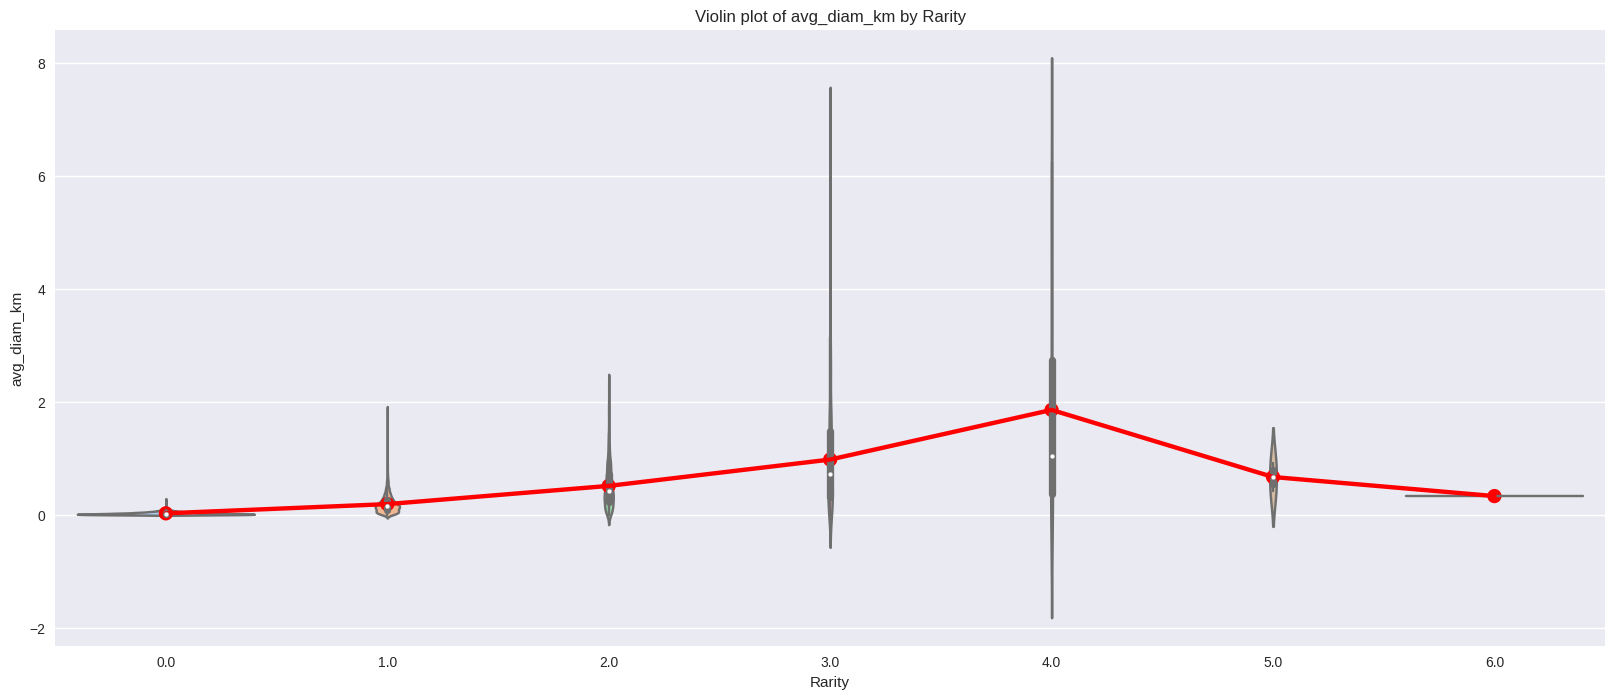

In [ ]:
fig, axs = plt.subplots(figsize=(20, 8))
sns.violinplot(x=df_m_to_km["Rarity"], y=df_m_to_km['avg_diam_km'], palette="pastel")
# Configurar el título y las etiquetas de los ejes
plt.title("Violin plot of " + 'avg_diam_km' + " by Rarity")
plt.xlabel("Rarity")
plt.ylabel('avg_diam_km')
    
# Agregar un punto rojo para la media de cada grupo
sns.pointplot(x=df_m_to_km["Rarity"], y=df_m_to_km['avg_diam_km'], color="red", markers="o", linestyles="-", errorbar=None)
    
# Mostrar el gráfico
plt.show()

- Finalmente, tenemos el Diameter en el formato adecuado para poderlo usar en una red neuronal. 

### Close-Approach (CA) Date

- **Close-Approach (CA) Date**: fecha y la hora de su máxima aproximación.
    - Fecha y hora (TDB) del máximo acercamiento a la Tierra. "Nominal Date" se da con la precisión adecuada. La incertidumbre de 3 sigmas en la hora se da en la columna +/- en formato días_horas:minutos (por ejemplo, "2_15:23" son 2 días, 15 horas, 23 minutos; "< 00:01" es menos de 1 minuto).

In [ ]:
# agrupamos por objeto y rareza 
date_freq_objects = neo_asteroids_clean_df.groupby(['Object', 'Rarity'], as_index=False).agg({"Close-Approach (CA) Date":'count'})
display(date_freq_objects.shape)
display(date_freq_objects.head())
display(date_freq_objects.tail())

(15819, 3)

Object Rarity  Close-Approach (CA) Date
0  (1979 XB)    2.0                         1
1  (1990 UN)    0.0                         1
2  (1991 BA)    0.0                         1
3  (1991 GO)    1.0                         4
4  (1991 GO)    2.0                         1

Object Rarity  Close-Approach (CA) Date
15814            9856 (1991 EE)    2.0                         1
15815         99248 (2001 KY66)    2.0                         1
15816  99942 Apophis (2004 MN4)    1.0                         1
15817  99942 Apophis (2004 MN4)    2.0                         6
15818  99942 Apophis (2004 MN4)    6.0                         1

In [ ]:
display(df_m_to_km[(df_m_to_km['Object']=='(1991 GO)') & (df_m_to_km['Rarity']==2.0)])
print("\n")
display(df_m_to_km[(df_m_to_km['Object']=='(1991 GO)') & (df_m_to_km['Rarity']==1.0)])
print("\n")
display(df_m_to_km[(df_m_to_km['Object']=='(1993 DA)') & (df_m_to_km['Rarity']==0.0)])

Object      Close-Approach (CA) Date  CA DistanceNominal (au)  \
198  (1991 GO)  1902-Oct-26 07:48 ±    00:01                  0.02029   

     CA DistanceMinimum (au)  V relative(km/s)  V infinity(km/s)  H(mag)  \
198                  0.02028             18.22             18.21    20.0   

           Diameter Rarity  avg_diam_km  
198  270 m -  590 m    2.0         0.43

Object      Close-Approach (CA) Date  CA DistanceNominal (au)  \
8018   (1991 GO)   1991-Apr-05 04:51 ± < 00:01                  0.03038   
27520  (1991 GO)   2073-Oct-24 20:29 ± < 00:01                  0.03978   
28331  (1991 GO)   2081-Oct-25 19:04 ± < 00:01                  0.03814   
29111  (1991 GO)  2089-Oct-27 13:27 ±    00:02                  0.03581   

       CA DistanceMinimum (au)  V relative(km/s)  V infinity(km/s)  H(mag)  \
8018                   0.03038             18.32             18.31    20.0   
27520                  0.03978             19.34             19.33    20.0   
28331                  0.03814             19.03             19.03    20.0   
29111                  0.03580             18.22             18.21    20.0   

             Diameter Rarity  avg_diam_km  
8018   270 m -  590 m    1.0         0.43  
27520  270 m -  590 m    1.0         0.43  
28331  270 m -  590 m    1.0         0.43  
29111  270 m -  590 m    1.0         0.43

Object      Close-Approach (CA) Date  CA DistanceNominal (au)  \
505    (1993 DA)   1907-Feb-21 14:49 ± 4_08:23                  0.04061   
1804   (1993 DA)  1926-Feb-19 01:10 ±    19:21                  0.03381   
3379   (1993 DA)   1945-Feb-15 18:29 ± 1_09:09                  0.04627   
8183   (1993 DA)  1993-Feb-19 03:39 ±    00:02                  0.03410   
11953  (1993 DA)   2012-Feb-17 17:38 ± 1_09:34                  0.03885   
26098  (1993 DA)   2060-Feb-20 13:11 ± 1_14:41                  0.03600   
28052  (1993 DA)   2079-Feb-18 16:22 ± 3_04:35                  0.03482   
33177  (1993 DA)   2146-Feb-19 15:18 ± 4_03:08                  0.03455   
35582  (1993 DA)   2194-Feb-22 16:20 ± 5_14:56                  0.04699   

       CA DistanceMinimum (au)  V relative(km/s)  V infinity(km/s)  H(mag)  \
505                    0.03623              6.75              6.74    26.4   
1804                   0.03375              6.65              6.64    26.4   
3379                   0.03923              6.64              6.63    26.4   
8183                   0.03394              6.67              6.66    26.4   
11953                  0.03588              6.63              6.62    26.4   
26098                  0.03476              6.70              6.68    26.4   
28052                  0.03458              6.64              6.63    26.4   
33177                  0.03453              6.65              6.64    26.4   
35582                  0.03929              6.82              6.81    26.4   

            Diameter Rarity  avg_diam_km  
505    14 m -   31 m    0.0       0.0225  
1804   14 m -   31 m    0.0       0.0225  
3379   14 m -   31 m    0.0       0.0225  
8183   14 m -   31 m    0.0       0.0225  
11953  14 m -   31 m    0.0       0.0225  
26098  14 m -   31 m    0.0       0.0225  
28052  14 m -   31 m    0.0       0.0225  
33177  14 m -   31 m    0.0       0.0225  
35582  14 m -   31 m    0.0       0.0225

- Observamos que la fecha y hora de su máxima aproximación no es constante a lo largo del tiempo. 

La creación de una nueva columna que cuente el número de veces que un objeto de una rareza tiene una fecha sería una característica útil para nuestro modelo de Deep Learning. 

Esta característica capturaría la frecuencia con la que un asteroide concreto de un determinado tamaño o mayor se acerca a la Tierra. 

También podría ayudar a nuestro modelo a distinguir entre asteroides más comunes y más raros, que potencialmente podrían tener diferentes características que afectan a su rareza.



Añadimos una nueva columna llamada "date_frequency" al DataFrame "neo_date_df". 

Los valores de esta columna representan la frecuencia de la "Close-Approach (CA) Date" para cada objeto en una rareza dada.

In [ ]:
# creamos una copia
neo_date_df = df_m_to_km.copy()

# creamos columna date_frequency
neo_date_df['date_frequency'] = ""

# calculamos la frecuencia de la "Close-Approach (CA) Date" para cada objeto en una rareza dada
neo_date_df['date_frequency'] = neo_date_df.groupby(['Object', 'Rarity'])['Close-Approach (CA) Date'].transform('count')
neo_date_df.head()

Object      Close-Approach (CA) Date  \
0       509352 (2007 AG)  1900-Jan-04 22:25 ±    00:02   
1           (2014 SC324)  1900-Jan-11 01:07 ±    00:18   
2           (2012 UK171)  1900-Jan-12 23:07 ±    00:13   
3  4660 Nereus (1982 DB)  1900-Jan-29 18:10 ±    00:35   
4            (2015 RW83)  1900-Feb-04 03:50 ±    14:49   

   CA DistanceNominal (au)  CA DistanceMinimum (au)  V relative(km/s)  \
0                  0.00963                  0.00962              8.69   
1                  0.03997                  0.03991             10.65   
2                  0.04982                  0.04950              7.16   
3                  0.02080                  0.02077              5.54   
4                  0.03312                  0.03258              3.14   

   V infinity(km/s)  H(mag)           Diameter Rarity  avg_diam_km  \
0              8.65    20.2     250 m -  550 m    2.0       0.4000   
1             10.65    24.3      37 m -   82 m    0.0       0.0595   
2              7.15    24.4      34 m -   77 m    0.0       0.0555   
3              5.52    18.6  0.28 km - 0.38 km    2.0       0.3300   
4              3.12    24.1      40 m -   90 m    0.0       0.0650   

   date_frequency  
0               1  
1               2  
2              19  
3               9  
4               3

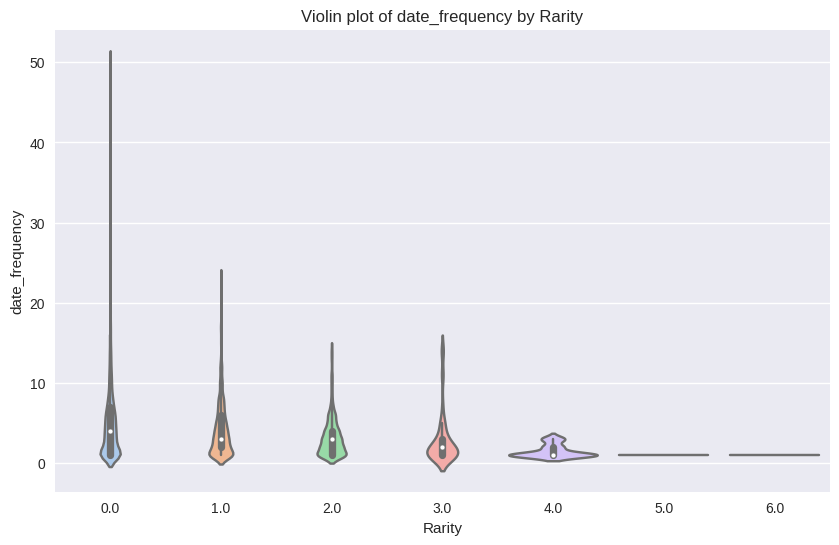

In [ ]:
fig, axs = plt.subplots(figsize=(10, 6))
sns.violinplot(x=neo_date_df["Rarity"], y=neo_date_df['date_frequency'], palette="pastel")
# Configurar el título y las etiquetas de los ejes
plt.title("Violin plot of " + 'date_frequency' + " by Rarity")
plt.xlabel("Rarity")
plt.ylabel('date_frequency')   
# Mostrar el gráfico
plt.show()

## Guardamos el dataset 



Guardamos el dataset preparado para poderlo subir a Google Drive y poder trabajar con Google Colab para construir el modelo de Deep Learning.

In [ ]:
prepared_dataset = neo_date_df.copy(deep=True)

In [ ]:
prepared_dataset.to_csv('prepared_dataset.csv', index=False)

## Cargamos el dataset

In [ ]:
# Mount Google Drive to store and load files. 
from google.colab import drive
drive.mount('drive') # mounting Google Drive

# Read csv from Google Drive in Google Colab 
prepared_df = pd.read_csv('drive/My Drive/MasterDS/DeepLearning/FinalProjectDL/1_MLP_DenseNetworks/prepared_dataset.csv')
prepared_df.head()

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


Object      Close-Approach (CA) Date  \
0       509352 (2007 AG)  1900-Jan-04 22:25 ±    00:02   
1           (2014 SC324)  1900-Jan-11 01:07 ±    00:18   
2           (2012 UK171)  1900-Jan-12 23:07 ±    00:13   
3  4660 Nereus (1982 DB)  1900-Jan-29 18:10 ±    00:35   
4            (2015 RW83)  1900-Feb-04 03:50 ±    14:49   

   CA DistanceNominal (au)  CA DistanceMinimum (au)  V relative(km/s)  \
0                  0.00963                  0.00962              8.69   
1                  0.03997                  0.03991             10.65   
2                  0.04982                  0.04950              7.16   
3                  0.02080                  0.02077              5.54   
4                  0.03312                  0.03258              3.14   

   V infinity(km/s)  H(mag)           Diameter  Rarity  avg_diam_km  \
0              8.65    20.2     250 m -  550 m     2.0       0.4000   
1             10.65    24.3      37 m -   82 m     0.0       0.0595   
2              7.15    24.4      34 m -   77 m     0.0       0.0555   
3              5.52    18.6  0.28 km - 0.38 km     2.0       0.3300   
4              3.12    24.1      40 m -   90 m     0.0       0.0650   

   date_frequency  
0               1  
1               2  
2              19  
3               9  
4               3

## Multi - class Classification

Ahora acabaremos de preparar los datos para poder usarlos en una red neuronal y poder clasificar los asteroides según su rareza.





En primer lugar, seleccionaremos las columnas numéricas que pueden ser útiles para predecir la rareza.

A continuación, aplicaremos one - hot encoding a la columna Rarity para convertirla en un formato que pueda utilizarse para la clasificación multiclase.

El conjunto de datos resultante numeric_prepared_df contiene las variables numéricas seleccionadas y las etiquetas de rareza codificadas con one - hot encoding. 



In [ ]:
# Clasificación de pertenencia a una especie
numeric_prepared_df = prepared_df[["CA DistanceNominal (au)", "CA DistanceMinimum (au)", "CA DistanceMinimum (au)", "V infinity(km/s)", "H(mag)", "avg_diam_km", "date_frequency"]]

# Aplicación de one-hot encode para la multiclase
numeric_prepared_df = pd.concat([numeric_prepared_df, pd.get_dummies(prepared_df["Rarity"])], axis = 1)
numeric_prepared_df.head()

CA DistanceNominal (au)  CA DistanceMinimum (au)  CA DistanceMinimum (au)  \
0                  0.00963                  0.00962                  0.00962   
1                  0.03997                  0.03991                  0.03991   
2                  0.04982                  0.04950                  0.04950   
3                  0.02080                  0.02077                  0.02077   
4                  0.03312                  0.03258                  0.03258   

   V infinity(km/s)  H(mag)  avg_diam_km  date_frequency  0.0  1.0  2.0  3.0  \
0              8.65    20.2       0.4000               1    0    0    1    0   
1             10.65    24.3       0.0595               2    1    0    0    0   
2              7.15    24.4       0.0555              19    1    0    0    0   
3              5.52    18.6       0.3300               9    0    0    1    0   
4              3.12    24.1       0.0650               3    1    0    0    0   

   4.0  5.0  6.0  
0    0    0    0  
1    0    0    0  
2    0    0    0  
3    0    0    0  
4    0    0    0

A continuación, separamos las variables y las etiquetas en dos matrices, data y labels.

Por último, las características de los datos se normalizan mediante la función StandardScaler(), que escala los datos para que tengan una media de 0 y una desviación estándar de 1, con el fin de mejorar el rendimiento de la red neuronal.

In [ ]:
# separamos las variables y las etiquetas en dos matrices
data = numeric_prepared_df.iloc[:, :-7].values
labels = numeric_prepared_df.iloc[:, -7:].values

# Normalización de los datos para mejorar el funcionamiento de la red neuronal
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

### Train - Test Split

Dividimos manualmente los datos en conjuntos de entrenamiento y validación utilizando una división 80-20 y convertimos Y_train e Y_test a float32 (números reales). 


In [ ]:
# Partición en entrenamiento/validación manualmente
split = int(data.shape[0] * 0.8)

X_train, Y_train = data[:split, :], labels[:split]
X_test, Y_test = data[split:, :], labels[split:]

# Transformamos los datos para hacerlos adecuados 
Y_train = np.asarray(Y_train).astype('float32')
Y_test = np.asarray(Y_test).astype('float32')

### Modelo 1

Definimos una red neuronal con dos capas ocultas para la clasificación de rareza de asteroides, con la capa de entrada tomando las características variables y la capa de salida produciendo las probabilidades predichas para cada clase.

In [ ]:
# Definimos el modelo secuencial
model = tf.keras.models.Sequential()

# Definimos el tamaño de entrada
model.add(tf.keras.Input(shape=(X_train.shape[1],))) # la entrada es un vector como antes, pero tendrà 4 variables numéricas y 2 categóricas

# Dos capas ocultas de 64 y 8 neuronas respectivamente, con la función de activación ReLu.
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
#  Capa de salida con 7 neuronas correspondientes a las 7 clases de rareza de los asteroides, con la función de activación sigmoid.
model.add(tf.keras.layers.Dense(7, activation='sigmoid')) # 7 salidas

model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 64)                512       
                                                                 
 dense_30 (Dense)            (None, 8)                 520       
                                                                 
 dense_31 (Dense)            (None, 7)                 63        
                                                                 
Total params: 1,095
Trainable params: 1,095
Non-trainable params: 0
_________________________________________________________________


- La red neuronal tiene tres capas, incluidas dos capas ocultas con 64 y 8 neuronas respectivamente, y una capa de salida con 7 neuronas (tenemos 7 neuronas a la salida).
- El número total de parámetros entrenables es de 1095, que es relativamente pequeño e indica un modelo relativamente simple.

Compilamos y entrenamos el modelo de red neuronal previamente definido:

In [ ]:
# Parámetros de entrenamiento
learning_rate = 0.001
epochs = 20 # el modelo se entrenará durante 20 iteraciones en todo el conjunto de datos de entrenamiento
batch_size = 128 # el modelo será entrenado en 128 muestras a la vez

# Categorical cross entropy for multiclass, MAE, RMSE, MAPE... https://www.tensorflow.org/api_docs/python/tf/keras/losses
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_split = 0.2, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/20
180/180 [==============================] - 2s 8ms/step - loss: 0.7144 - accuracy: 0.8321 - val_loss: 0.4092 - val_accuracy: 0.8709
Epoch 2/20
180/180 [==============================] - 1s 5ms/step - loss: 0.2748 - accuracy: 0.9213 - val_loss: 0.2365 - val_accuracy: 0.9395
Epoch 3/20
180/180 [==============================] - 1s 6ms/step - loss: 0.1937 - accuracy: 0.9486 - val_loss: 0.1719 - val_accuracy: 0.9500
Epoch 4/20
180/180 [==============================] - 1s 7ms/step - loss: 0.1541 - accuracy: 0.9575 - val_loss: 0.1346 - val_accuracy: 0.9582
Epoch 5/20
180/180 [==============================] - 1s 5ms/step - loss: 0.1313 - accuracy: 0.9631 - val_loss: 0.1180 - val_accuracy: 0.9639
Epoch 6/20
180/180 [==============================] - 1s 4ms/step - loss: 0.1164 - accuracy: 0.9675 - val_loss: 0.1079 - val_accuracy: 0.9658
Epoch 7/20
180/180 [==============================] - 1s 4ms/step - loss: 0.1068 - accuracy: 0.9689 - val_loss: 0.0996 - val_accuracy: 0.9686
Epoch 

Evaluamos el modelo: 

In [ ]:
# evaluate the model
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print('Test Accuracy: %.3f' %acc)
print('Test Loss: %.3f' %loss)

225/225 [==============================] - 0s 2ms/step - loss: 0.0713 - accuracy: 0.9778
Test Accuracy: 0.978
Test Loss: 0.071


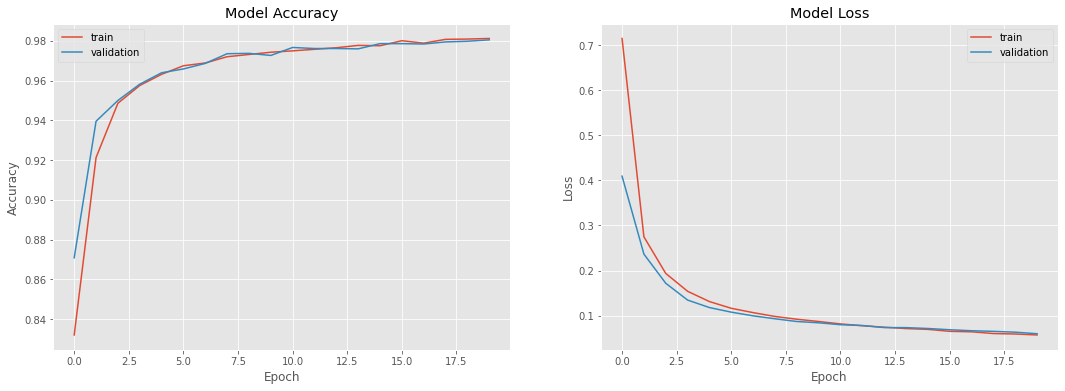

In [ ]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 6))

# Left plot (Accuracy)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.title.set_text('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['train', 'validation'])


# Right plot (Loss)
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.title.set_text('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['train', 'validation'])

plt.show()

225/225 [==============================] - 0s 1ms/step


<Axes: >

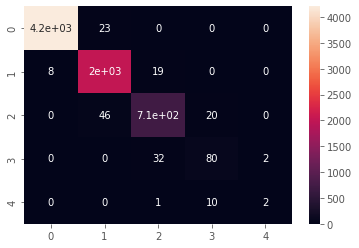

In [ ]:
# predicts the class labels for the test dataset
yTest = model.predict(X_test)
# convert the predicted class probabilities (stored in yTest) and true class labels (stored in Y_test) to their corresponding class indices
predClasses = np.argmax(yTest,axis=1)
yTestTrue = np.argmax(Y_test, axis = 1)
# confusion matrix
sns.heatmap(confusion_matrix(yTestTrue, predClasses), annot = True)

In [ ]:
print(classification_report(yTestTrue, predClasses))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4231
           1       0.97      0.99      0.98      2038
           2       0.93      0.92      0.92       778
           3       0.73      0.70      0.71       114
           4       0.50      0.15      0.24        13

    accuracy                           0.98      7174
   macro avg       0.82      0.75      0.77      7174
weighted avg       0.98      0.98      0.98      7174



- Podemos observar que el modelo tiene una accuracy del 97.8% en los datos de prueba, lo que significa que ha clasificado correctamente el 97.8% de las muestras de prueba. 
- La pérdida de 0.071 indica que las predicciones del modelo se aproximaron bastante a los valores reales. 

- En las gráficas de la accuracy y loss no se observan indicios de overfitting. 
- En la matriz de confusión podemos apreciar que las clases que más le ha costado clasificar al modelo han sido la 3 y la 4. Las clases 5 y 6 no están representadas ya que el dataset estaba muy desbalanceado y estas clases minoritarias casi no tenían valores.  

- Observando el f1-score, podemos ver que el modelo obtiene buenos resultados en la identificación de las clases mayoritarias, pero tiene dificultades para identificar las clases minoritarias, en particular la clase 3 y la clase 4. Esto es habitual en los conjuntos de datos desequilibrados. En estos casos, pueden utilizarse técnicas como el submuestreo para mejorar el rendimiento del modelo en estas clases. En el caso de las clases 5 y 6, hay tan pocos valores que no quedan representadas en el test set, pero esto también nos da información, ya que nos indica que los asteroides que los asteroides de ese tamaño o más grandes que se acercan a la Tierra son muy raros y, por lo tanto, difíciles de detectar y estudiar.



### Modelo 2

Ahora entrenamos el mismo modelo pero con 100 epochs. Esto nos permitirá ver cómo cambia el rendimiento del modelo a medida que se entrena durante un periodo de tiempo más largo.

Una cosa a tener en cuenta es que entrenar durante más epochs no siempre conduce a un mejor rendimiento. Es posible que el modelo empiece a sobreajustarse a los datos de entrenamiento y no generalice bien a nuevos datos no vistos.

In [ ]:
# Definimos el modelo secuencial
model = tf.keras.models.Sequential()

# Definimos el tamaño de entrada
model.add(tf.keras.Input(shape=(X_train.shape[1],))) # la entrada es un vector como antes, pero tendrà 4 variables numéricas y 2 categóricas

# Dos capas ocultas de 64 y 8 neuronas respectivamente, con la función de activación ReLu.
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
#  Capa de salida con 7 neuronas correspondientes a las 7 clases de rareza de los asteroides, con la función de activación sigmoid.
model.add(tf.keras.layers.Dense(7, activation='sigmoid')) # 7 salidas

model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 64)                512       
                                                                 
 dense_33 (Dense)            (None, 8)                 520       
                                                                 
 dense_34 (Dense)            (None, 7)                 63        
                                                                 
Total params: 1,095
Trainable params: 1,095
Non-trainable params: 0
_________________________________________________________________


Compilamos y entrenamos el modelo de red neuronal previamente definido:

In [ ]:
# Parámetros de entrenamiento
learning_rate = 0.001
epochs = 100
batch_size = 128

# Categorical cross entropy for multiclass, MAE, RMSE, MAPE... https://www.tensorflow.org/api_docs/python/tf/keras/losses
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_split = 0.2, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/100
180/180 [==============================] - 2s 5ms/step - loss: 0.7959 - accuracy: 0.8199 - val_loss: 0.3748 - val_accuracy: 0.9031
Epoch 2/100
180/180 [==============================] - 1s 3ms/step - loss: 0.2725 - accuracy: 0.9309 - val_loss: 0.2233 - val_accuracy: 0.9441
Epoch 3/100
180/180 [==============================] - 1s 3ms/step - loss: 0.1926 - accuracy: 0.9497 - val_loss: 0.1705 - val_accuracy: 0.9556
Epoch 4/100
180/180 [==============================] - 1s 3ms/step - loss: 0.1586 - accuracy: 0.9583 - val_loss: 0.1454 - val_accuracy: 0.9608
Epoch 5/100
180/180 [==============================] - 1s 3ms/step - loss: 0.1403 - accuracy: 0.9613 - val_loss: 0.1341 - val_accuracy: 0.9620
Epoch 6/100
180/180 [==============================] - 0s 3ms/step - loss: 0.1279 - accuracy: 0.9639 - val_loss: 0.1205 - val_accuracy: 0.9655
Epoch 7/100
180/180 [==============================] - 1s 3ms/step - loss: 0.1182 - accuracy: 0.9663 - val_loss: 0.1127 - val_accuracy: 0.9674

Evaluamos el modelo: 

In [ ]:
# evaluate the model
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print('Test Accuracy: %.3f' %acc)
print('Test Loss: %.3f' %loss)

225/225 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9883
Test Accuracy: 0.988
Test Loss: 0.030


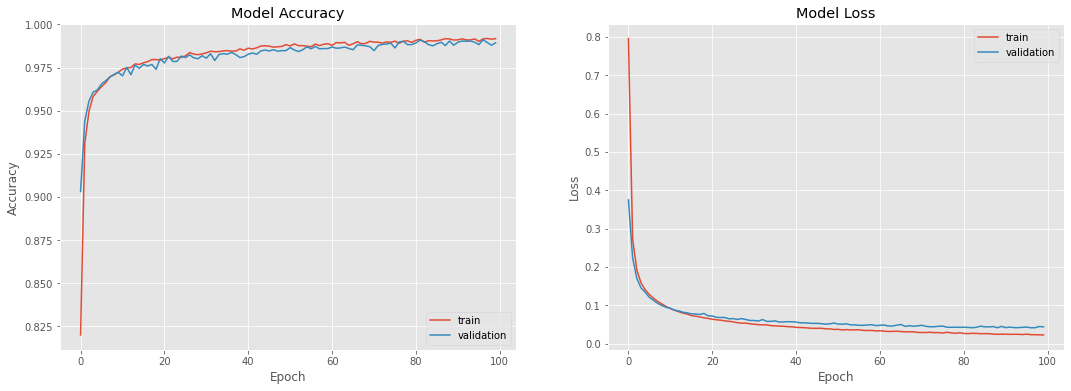

In [ ]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 6))

# Left plot (Accuracy)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.title.set_text('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['train', 'validation'])


# Right plot (Loss)
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.title.set_text('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['train', 'validation'])

plt.show()

225/225 [==============================] - 0s 1ms/step


<Axes: >

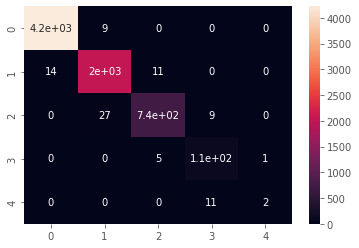

In [ ]:
# predicts the class labels for the test dataset
yTest = model.predict(X_test)
# convert the predicted class probabilities (stored in yTest) and true class labels (stored in Y_test) to their corresponding class indices
predClasses = np.argmax(yTest,axis=1)
yTestTrue = np.argmax(Y_test, axis = 1)
# confusion matrix
sns.heatmap(confusion_matrix(yTestTrue, predClasses), annot = True)

In [ ]:
print(classification_report(yTestTrue, predClasses))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4231
           1       0.98      0.99      0.99      2038
           2       0.98      0.95      0.97       778
           3       0.84      0.95      0.89       114
           4       0.67      0.15      0.25        13

    accuracy                           0.99      7174
   macro avg       0.89      0.81      0.82      7174
weighted avg       0.99      0.99      0.99      7174



- Podemos observar que el modelo tiene una accuracy del 98.8% en los datos de prueba, lo que significa que ha clasificado correctamente el 98.8% de las muestras de prueba. 
- La pérdida de 0.03 indica que las predicciones del modelo se aproximaron bastante a los valores reales. 

- En las gráficas de la accuracy y loss no se observan indicios de overfitting. 
- En la matriz de confusión podemos apreciar que las clases que más le ha costado clasificar al modelo han sido la 3 y la 4, como en el modelo anterior. Las clases 5 y 6 no están representadas debido a la falta de datos en esas clases.

- Observando el f1-score, podemos ver que el modelo obtiene buenos resultados en la identificación todas las clases, pero tiene dificultades para identificar la clase minoritaria 4. 

- No obstante, al aumentar los epochs a 100, el modelo ha funcionado mejor. 

  # 2_Convolutional_Neural_Networks

## Objetivos 

Para la sección convolucional nos centraremos en imágenes y el conjunto de datos será **_"Multi-class Weather Datasetfor Image Classification"_** utilizado en el artículo **_"Multi-class weather recognition from the still image using heterogeneous ensemble method"_**. 

Consiste en imágenes de 4 momentos concretos del día y el objetivo principal es clasificarlas al momento adecuado del día. 


## Librerías

In [ ]:
import os
import cv2
import random
from PIL import Image
from shutil import copyfile


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
plt.style.use('ggplot') # seaborn-v0_8


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc


import tensorflow as tf
from tensorflow.keras import layers, models, Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model


## Carga de datos

In [ ]:
# Mount Google Drive to store and load files. 
from google.colab import drive
drive.mount('drive') # mounting Google Drive

Mounted at drive


In [ ]:
path = '/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/2_CNN/Multi-class Weather Dataset/'

In [ ]:
# nombre de las carpetas
os.listdir(path)

['Rain', 'Shine', 'Cloudy', 'Sunrise']

In [ ]:
# para obtener las imágenes de la carpeta 'Sunrise', por ejemplo
os.listdir(os.path.join(path, 'Sunrise'))

In [ ]:
# Obtener una lista de todas las imágenes en las subcarpetas
image_list = []
for foldername in os.listdir(path):
    folderpath = os.path.join(path, foldername)
    if os.path.isdir(folderpath):
        for filename in os.listdir(folderpath):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                image_list.append((os.path.join(folderpath, filename), foldername))

In [ ]:
image_list[0]

('/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/2_CNN/Multi-class Weather Dataset/Rain/rain11.jpg',
 'Rain')

In [ ]:
# Cargar las imágenes en una lista
images = []
for image_path, foldername in image_list:
    image = Image.open(image_path)
    images.append((image, foldername))


In [ ]:
images[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=759x422 at 0x7FA7BEE36FA0>,
 'Rain')

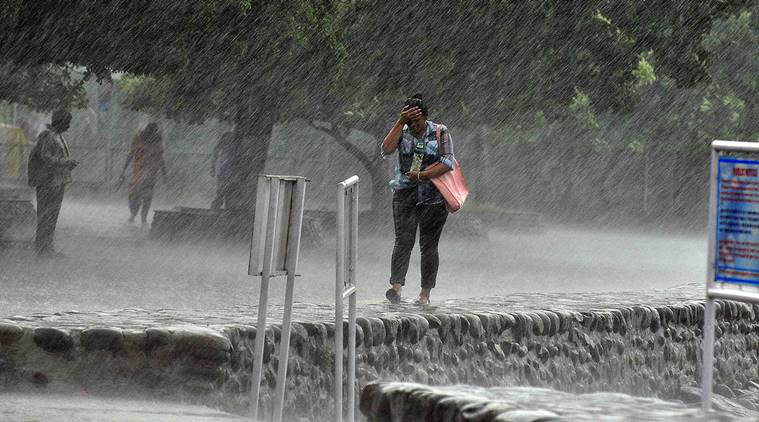

La imagen pertenece a la carpeta Rain


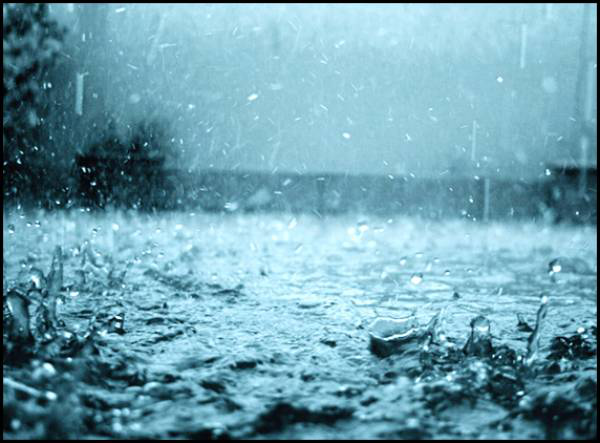

La imagen pertenece a la carpeta Rain


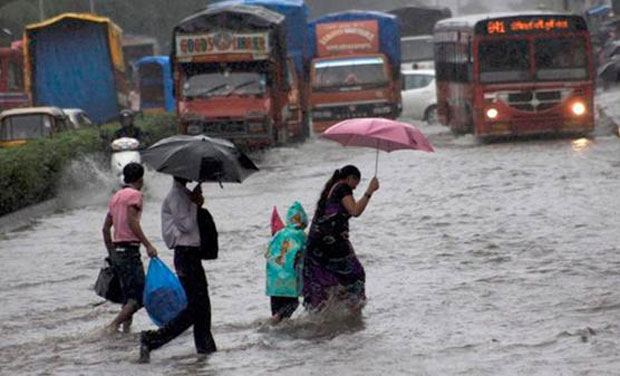

La imagen pertenece a la carpeta Rain


In [ ]:
# Verificar que las imágenes se hayan cargado correctamente
count = 0
for image, foldername in images:
    if count < 3: # mostramos las 3 primeras imágenes
        image.show()
        print(f"La imagen pertenece a la carpeta {foldername}")
        count += 1
    else:
        break

## Exploratory Data Analysis (EDA)

### Function to get the shapes of the images in a folder


In [ ]:
# Define a function to get the shapes of the images in a folder
def get_image_shapes(path, folder):
    shapes = []
    # Get a list of all the images in the folder
    image_names = os.listdir(os.path.join(path, folder))
    for img_name in image_names:
        img_path = os.path.join(path, folder, img_name)
        shapes.append(imread(img_path).shape)
    # Create a DataFrame with the shapes of the images in the folder
    shapes_df = pd.DataFrame().assign(X=pd.Series(shapes).map(lambda s: s[0]), Y=pd.Series(shapes).map(lambda s: s[1]))
    return shapes_df

# Get the shapes of the images in the Cloudy, Rain, Shine, and Sunrise folders
cloudy_shapes = get_image_shapes(path, 'Cloudy')
rain_shapes = get_image_shapes(path, 'Rain')
shine_shapes = get_image_shapes(path, 'Shine')
sunrise_shapes = get_image_shapes(path, 'Sunrise')

# Print summary statistics of the X and Y columns in each DataFrame
print('Cloudy:')
print(cloudy_shapes.describe())
print('\nRain:')
print(rain_shapes.describe())
print('\nShine:')
print(shine_shapes.describe())
print('\nSunrise:')
print(sunrise_shapes.describe())


Cloudy:
                 X            Y
count   300.000000   300.000000
mean    277.503333   416.083333
std     230.356703   332.346220
min     134.000000   183.000000
25%     167.000000   246.500000
50%     178.000000   274.500000
75%     300.000000   381.250000
max    2000.000000  2000.000000

Rain:
                 X            Y
count   215.000000   215.000000
mean    411.190698   633.004651
std     362.031994   549.923457
min     158.000000   183.000000
25%     184.000000   286.500000
50%     352.000000   553.000000
75%     473.000000   742.000000
max    2848.000000  4288.000000

Shine:
                 X            Y
count   253.000000   253.000000
mean    284.114625   423.976285
std     257.230593   395.088999
min     111.000000   158.000000
25%     168.000000   245.000000
50%     177.000000   281.000000
75%     226.000000   318.000000
max    1800.000000  2880.000000

Sunrise:
                 X            Y
count   357.000000   357.000000
mean    372.717087   564.156863
std    

- Observamos que las imágenes tienen diferentes tamaños en píxeles. 

### Density plots

Podemos utilizar los kernel density plots para decidir el tamaño de entrada de nuestro modelo CNN. 

Observando los gráficos, podemos ver la distribución de tamaños de imagen para cada clase, y podemos utilizar esta información para elegir un tamaño de entrada razonable.




  Kernel density plots of image sizes for each of the four classes:

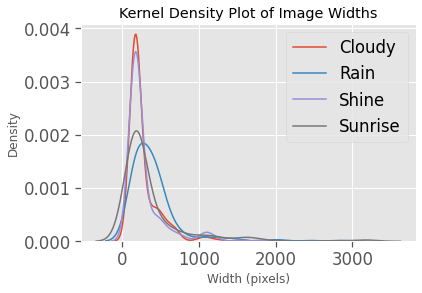

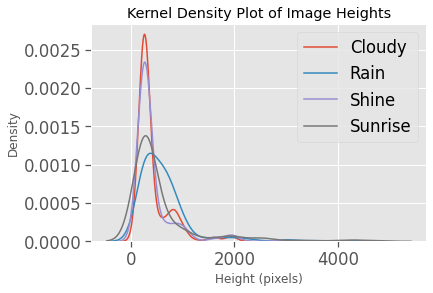

In [ ]:
# Create a list of tuples with the name of each class and its corresponding shapes DataFrame
class_shapes = [('Cloudy', cloudy_shapes), ('Rain', rain_shapes), ('Shine', shine_shapes), ('Sunrise', sunrise_shapes)]

# Plot a kernel density plot for the X column of each class
for class_name, shapes_df in class_shapes:
    sns.kdeplot(data=shapes_df['X'], label=class_name)

# Add a legend and axis labels
plt.legend()
plt.xlabel('Width (pixels)')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Image Widths')
plt.show()

# Plot a kernel density plot for the Y column of each class
for class_name, shapes_df in class_shapes:
    sns.kdeplot(data=shapes_df['Y'], label=class_name)

# Add a legend and axis labels
plt.legend()
plt.xlabel('Height (pixels)')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Image Heights')
plt.show()


Basándonos en los kernel density plots, elegimos un tamaño de entrada de 256 x 256, que es lo suficientemente grande como para acomodar la imagen más grande de cada categoría o clase sin recortes significativos o pérdidas de detalle. Esto debería proporcionarnos un buen equilibrio entre la retención de la información necesaria y la eficiencia computacional.

## Data preprocessing

### Resize 

Como hemos visto anteriormente, las imágenes tienen diferentes dimensiones en píxeles (anchura x altura):

- Observamos que las imágenes tienen distintas dimensiones en píxeles. 
- En deep learning, especialmente en las redes neuronales convolucionales (CNN), es habitual preprocesar las imágenes para que todas tengan el mismo tamaño en píxeles. Esto se debe a que las CNN normalmente esperan que las imágenes de entrada tengan dimensiones fijas. Si las imágenes tienen tamaños diferentes, es necesario redimensionarlas o recortarlas a un tamaño fijo antes de introducirlas en la red neuronal.


Sería mejor crear una nueva carpeta separada llamada resized_images con cuatro subcarpetas dentro (Cloudy, Rain, Shine y Sunrise) y almacenar las imágenes redimensionadas en sus respectivas subcarpetas. Esto nos ayudará a mantener las imágenes originales y las redimensionadas separadas y organizadas.

In [ ]:
# define path to original image folder
original_path = '/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/2_CNN/Multi-class Weather Dataset/'

# define path to new resized image folder
resized_path = '/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/2_CNN/resized_images/'

# define target size for resized images
target_size = (256, 256) # width - height

# loop through each class folder and resize images
for folder_name in os.listdir(original_path):
    # create subfolder in resized_images folder
    os.makedirs(os.path.join(resized_path, folder_name), exist_ok=True)
    
    # loop through each image in class folder and resize
    for file_name in os.listdir(os.path.join(original_path, folder_name)):
        # load image
        img = Image.open(os.path.join(original_path, folder_name, file_name))
        # if not RGB we convert to RGB
        if img.mode != 'RGB': 
          img = img.convert('RGB')
        
        # resize image
        img_resized = img.resize(target_size, resample=Image.BICUBIC)
        
        # save resized image to new folder
        img_resized.save(os.path.join(resized_path, folder_name, file_name))

- Este código creará una nueva carpeta llamada resized_images en el mismo directorio que la carpeta de imágenes original, y creará cuatro subcarpetas dentro para las cuatro clases. El código recorrerá cada carpeta, redimensionará cada imagen y guardará la imagen redimensionada en la subcarpeta correspondiente. 




Comprobamos que tenemos todas las imágenes: 

In [ ]:
# Original  
image_folder = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

for images in image_folder:
    print('{}: '.format(images)+str(len(os.listdir(path+images+'/'))))

Cloudy: 300
Rain: 215
Shine: 253
Sunrise: 357


In [ ]:
# Resized
image_folder = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

resized_path = '/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/2_CNN/resized_images/'
for images in image_folder:
    print('{}: '.format(images)+str(len(os.listdir(resized_path+images+'/'))))

Cloudy: 300
Rain: 215
Shine: 253
Sunrise: 357


- Tenemos todas las imágenes. 

Comprobamos que el tamaño sea 256 x 256:

In [ ]:
# Get the shapes of the images in the Cloudy, Rain, Shine, and Sunrise folders
cloudy_shapes_resized = get_image_shapes(resized_path, 'Cloudy')
rain_shapes_resized  = get_image_shapes(resized_path, 'Rain')
shine_shapes_resized  = get_image_shapes(resized_path, 'Shine')
sunrise_shapes_resized  = get_image_shapes(resized_path, 'Sunrise')

# Print summary statistics of the X and Y columns in each DataFrame
print('Resized Cloudy:')
print(cloudy_shapes_resized .describe())
print('\n Resized Rain:')
print(rain_shapes_resized .describe())
print('\nResized Shine:')
print(shine_shapes_resized .describe())
print('\nResized Sunrise:')
print(sunrise_shapes_resized .describe())

Resized Cloudy:
           X      Y
count  300.0  300.0
mean   256.0  256.0
std      0.0    0.0
min    256.0  256.0
25%    256.0  256.0
50%    256.0  256.0
75%    256.0  256.0
max    256.0  256.0

 Resized Rain:
           X      Y
count  215.0  215.0
mean   256.0  256.0
std      0.0    0.0
min    256.0  256.0
25%    256.0  256.0
50%    256.0  256.0
75%    256.0  256.0
max    256.0  256.0

Resized Shine:
           X      Y
count  253.0  253.0
mean   256.0  256.0
std      0.0    0.0
min    256.0  256.0
25%    256.0  256.0
50%    256.0  256.0
75%    256.0  256.0
max    256.0  256.0

Resized Sunrise:
           X      Y
count  357.0  357.0
mean   256.0  256.0
std      0.0    0.0
min    256.0  256.0
25%    256.0  256.0
50%    256.0  256.0
75%    256.0  256.0
max    256.0  256.0


- El resize se ha realizado correctamente. 

### Split the data into training and test sets

In [ ]:
def load_image_data(data_dir, test_size, random_state):
    """
    Load image data from a directory and split it into training and test sets.
    
    Args:
        data_dir (str): Path to the directory containing image files.
        test_size (float): size of test set
        random_state (int): random state
    
    Returns:
        A tuple (X_train, X_test, y_train, y_test), where:
        X_train (numpy.ndarray): Array of training image data.
        X_test (numpy.ndarray): Array of test image data.
        y_train (numpy.ndarray): Array of training image labels.
        y_test (numpy.ndarray): Array of test image labels.
    """
    all_image_files = []
    all_image_labels = []
    
    # Load image files and labels
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            image = Image.open(file_path)
            all_image_files.append(np.array(image))
            all_image_labels.append(np.array(folder_name))

    all_image_files = np.array(all_image_files)
    all_image_labels = np.array(all_image_labels)

    # Split the data into training and test sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(
        all_image_files, all_image_labels, test_size=test_size, random_state=random_state
    )

    print(f"Number of training samples: {len(X_train)}")
    print(f"Number of test samples: {len(X_test)}")
    print("X_train:", X_train.shape)
    print("X_test:", X_test.shape)
    print("all_image_files shape:", all_image_files.shape)

    return X_train, X_test, y_train, y_test


In [ ]:
# Call the function to load and split the image data

data_dir = '/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/2_CNN/resized_images/'
test_size = 0.2 
random_state = 42 

X_train, X_test, y_train, y_test = load_image_data(data_dir, test_size, random_state)

Number of training samples: 900
Number of test samples: 225
X_train: (900, 256, 256, 3)
X_test: (225, 256, 256, 3)
all_image_files shape: (1125, 256, 256, 3)


- Observamos que X_train y X_test tienen 4 dimensiones (900, 256, 256, 3) y (225, 256, 256, 3):
  - n=900 data points en training set
  - n=225 data points en test set
  - 256 pixels * 256 pixels: las dimensiones de nuestras imágenes
  - 3 canales: RGB 
- Por tanto, no hace falta hacer un reshape, ya que tenemos tensores con 4 dimensiones. 


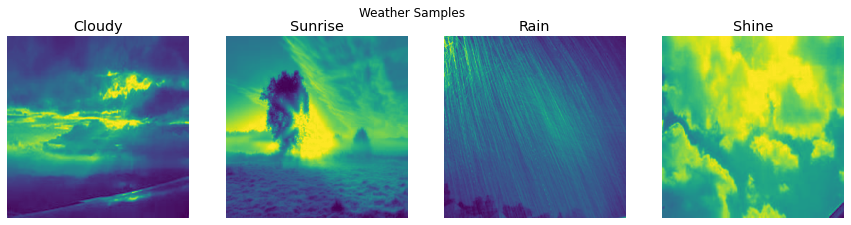

In [ ]:
# Visualize some samples
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 3.5))
fig.suptitle('Weather Samples')

ax1.imshow(X_train[0, :, :, 0])
ax1.set_title(y_train[0])
ax1.axis('off')

ax2.imshow(X_train[1, :, :, 0])
ax2.set_title(y_train[1])
ax2.axis('off')

ax3.imshow(X_train[225, :, :, 0])
ax3.set_title(y_train[225])
ax3.axis('off')

ax4.imshow(X_train[20, :, :, 0])
ax4.set_title(y_train[20])
ax4.axis('off')

plt.show()


- Parece que entre ellas son distinguibles. A priori parece que se separan bien. 

#### Data imbalance 

Observamos si existe un desbalanceo de clases en train y test:


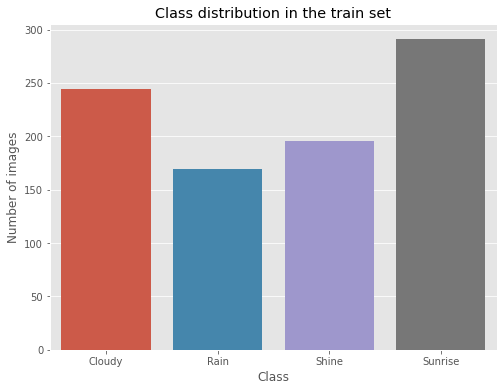

Train set:
Cloudy : 244
Rain : 169
Shine : 196
Sunrise : 291


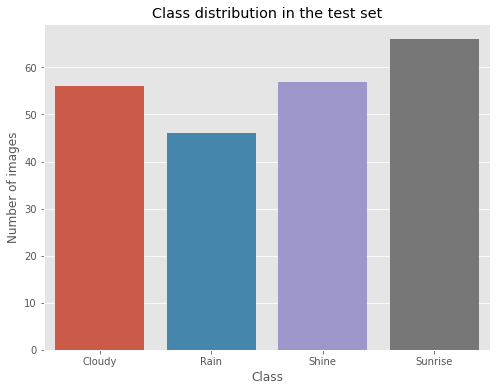


Test set:
Cloudy : 56
Rain : 46
Shine : 57
Sunrise : 66


In [ ]:
# count the number of images in each class in the train set
train_counts = np.unique(y_train, return_counts=True)
train_counts_dict = dict(zip(train_counts[0], train_counts[1]))

# count the number of images in each class in the test set
test_counts = np.unique(y_test, return_counts=True)
test_counts_dict = dict(zip(test_counts[0], test_counts[1]))

# create a barplot to visualize the class distribution in the train set
plt.figure(figsize=(8, 6))
sns.barplot(x=list(train_counts_dict.keys()), y=list(train_counts_dict.values()))
plt.title('Class distribution in the train set')
plt.xlabel('Class')
plt.ylabel('Number of images')
#for i, v in enumerate(train_counts_dict.values()):
    #plt.text(i, v, str(v), color='black', ha="center")
plt.show()

# print the number of images in each class for train set
print("Train set:")
for i in range(len(train_counts[0])):
    print(train_counts[0][i], ":", train_counts[1][i])

# create a barplot to visualize the class distribution in the test set
plt.figure(figsize=(8, 6))
sns.barplot(x=list(test_counts_dict.keys()), y=list(test_counts_dict.values()))
plt.title('Class distribution in the test set')
plt.xlabel('Class')
plt.ylabel('Number of images')
#for i, v in enumerate(test_counts_dict.values()):
    #plt.text(i, v, str(v), color='black', ha="center")
plt.show()

# print the number of images in each class for test set
print("\nTest set:")
for i in range(len(test_counts[0])):
    print(test_counts[0][i], ":", test_counts[1][i])


### One - hot encoding
Antes de entrenar un modelo CNN, es necesario convertir las etiquetas categóricas de y_train e y_test en números enteros.

En nuestro caso, utilizaremos one - hot encoding. 


Codificamos el resultado:
- DL no acepta categorías.
- No podemos hacer una clasificación de 4 clases con una sola neurona, necesitaremos 4 neuronas. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# create an instance of OneHotEncoder
encoder = OneHotEncoder()

# fit the encoder on the training labels and transform both the training and test labels
y_train_encoded = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test_encoded = encoder.transform(np.array(y_test).reshape(-1, 1)).toarray()
  # The reshape(-1, 1) method is used to reshape the input array to have one column and as many rows as needed, while keeping the original shape intact. 
  # In this case, the y_train and y_test arrays are reshaped to have a single column, which is necessary for the OneHotEncoder to work properly.
  # The -1 in the reshape method means that the number of rows is inferred based on the size of the input array and the other specified dimension (in this case, 1). 
  # So if the original array had shape (n,), the resulting reshaped array will have shape (n, 1).

# print the shapes of the encoded labels
print(f"Shape of y_train_encoded: {y_train_encoded.shape}")
print(f"Shape of y_test_encoded: {y_test_encoded.shape}")


Shape of y_train_encoded: (900, 4)
Shape of y_test_encoded: (225, 4)


- A la salida tendremos 4 neuronas. 

### Normalize the data

Normalizar los valores de los píxeles es un paso importante en la preparación de los datos para los modelos de deep learning. Esto se debe a que los modelos de deep learning son sensibles a la escala de las variables de entrada. Normalizar los valores de los píxeles en un rango entre 0 y 1 (dividiendo por 255) puede ayudar a que el modelo converja más rápido y mejore su rendimiento general. También puede ayudar a evitar problemas de inestabilidad numérica que pueden surgir cuando se trabaja con números muy grandes o muy pequeños.

Dividimos los valores entre 255: acotamos entre 0 y 1 para evitar explosión de gradiente.

In [ ]:
# Normalize the data: (0-255) --> (0-1)

# change the data type of X_train and X_test to float before performing the division by 255
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Dividing all the numbers by 255: anything between 0-255 divided by 255 is a number between 0 and 1.
X_train /= 255
X_test /= 255

print(X_train.shape)
print(X_test.shape)

(900, 256, 256, 3)
(225, 256, 256, 3)


## Creamos los modelos

### Modelos CNN

#### 1.1 

Esta Red neuronal convolucional (CNN) consta de varias capas para clasificar las imágenes en una de las cuatro clases.

En primer lugar, definimos el número de clases como 4. A continuación, creamos un modelo secuencial (pila lineal de capas). La forma de entrada de las imágenes se define como (256, 256, 3), lo que significa que las imágenes son de 256x256 píxeles con 3 canales de color (RGB).

El modelo comienza con una capa Convolucional que aplica 32 filtros de tamaño 3x3 a las imágenes de entrada y utiliza la función de activación ReLU. A continuación, se añade una capa MaxPooling para reducir las dimensiones espaciales de la salida de la capa convolucional.

Luego, se añade otra capa convolucional con 64 filtros de tamaño 3x3 y función de activación ReLU. Después de esta capa convolucional se añade otra capa MaxPooling.

Para evitar el overfitting o sobreajuste, se añade una capa Dropout con una tasa de dropout de 0.5. Esta capa elimina aleatoriamente la mitad de los datos. Esto elimina aleatoriamente la mitad de las neuronas de la capa anterior durante el entrenamiento.

La capa Flatten se añade para aplanar la salida de la capa anterior en una matriz 1D, que luego se pasa a una capa MLP totalmente conectada con 256 neuronas y función de activación ReLU. Después de esta Dense layer se añade otra capa de salida.

Por último, se añade la capa de salida con neuronas num_classes (4) y la función de activación Softmax. La función Softmax se utiliza para tareas de clasificación multiclase porque convierte la salida de la última capa en una distribución de probabilidad sobre las clases.

El modelo se compila utilizando el optimizador Adam con una tasa de aprendizaje de 0.001 y la función de pérdida categorical_crossentropy porque se trata de un problema de clasificación multiclase. 

Entrenamos el modelo con 10 epochs (los datos de entrenamiento pasarán 10 veces por el modelo durante el entrenamiento) y un batch_size de 128 (los pesos del modelo se actualizarán tras procesar un lote de 128 imágenes).




In [ ]:
# define the number of classes
num_classes = 4

# create a sequential model
model = Sequential(
    [
      Input(shape=(256, 256, 3)), # input_shape: lo que miden las imágene
      # add convolutional layer
      layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'), # 32 filtros
      layers.MaxPooling2D(pool_size=(2, 2)), # aplicamos el 1r pooling
      layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
      layers.MaxPooling2D(pool_size=(2, 2)),
      # add dropout layer to reduce overfitting
      layers.Dropout(0.5),
      # add flatten layer
      layers.Flatten(), # para pasarlo a vector, porque a partir de aquí queremos extraer conocimiento y a continuación aplicamos MLP
      # add dense layer
      layers.Dense(256, activation='relu'), # aplicamos MLP
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation='softmax'), # queremos hacer la clasificacion de 4. Podriamos utilizar también la sigmoid pero la softmax es la que se suele utilizar.
  ]
)

# Optimizer 
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# compile the model
model.compile(
              optimizer=opt, 
              loss='categorical_crossentropy', # categorical_crossentropy loss function porque es Multi-class
              metrics=['accuracy']
              )

# .summary(): if we want to see how many parameters our neural network is taking up.
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 62, 62, 64)        0         
                                                                 
 flatten_5 (Flatten)         (None, 246016)           

- Total params = number of weights (w) = number of w's (y=wx+b)
- La regresión lineal tiene 2 parámetros. Aquí tenemos 63.000.772 parámetros, son muchos. 



Ya tenemos la red hecha. Vamos a entrenar el modelo:

In [ ]:
# Train the model: fit the model on the training data
history = model.fit(X_train, y_train_encoded, batch_size=128, epochs=10, validation_data=(X_test, y_test_encoded))

Epoch 1/10
8/8 [==============================] - 173s 22s/step - loss: 8.1679 - accuracy: 0.4311 - val_loss: 1.0865 - val_accuracy: 0.5822
Epoch 2/10
8/8 [==============================] - 136s 17s/step - loss: 0.8118 - accuracy: 0.6389 - val_loss: 0.7443 - val_accuracy: 0.6800
Epoch 3/10
8/8 [==============================] - 146s 18s/step - loss: 0.6198 - accuracy: 0.7500 - val_loss: 0.5873 - val_accuracy: 0.8178
Epoch 4/10
8/8 [==============================] - 136s 17s/step - loss: 0.4410 - accuracy: 0.8433 - val_loss: 0.6921 - val_accuracy: 0.7378
Epoch 5/10
8/8 [==============================] - 133s 17s/step - loss: 0.4704 - accuracy: 0.8089 - val_loss: 0.5351 - val_accuracy: 0.8178
Epoch 6/10
8/8 [==============================] - 136s 17s/step - loss: 0.3387 - accuracy: 0.8767 - val_loss: 0.5861 - val_accuracy: 0.7867
Epoch 7/10
8/8 [==============================] - 132s 16s/step - loss: 0.3619 - accuracy: 0.8633 - val_loss: 0.6308 - val_accuracy: 0.7778
Epoch 8/10
8/8 [====

- Observamos que en la epoch 10, el modelo alcanza una accuracy aceptable en el conjunto de validación (0.8578)

In [ ]:
# To save the model once it has been trained 
model.save('/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/2_CNN/models/model_1_cnn.h5')

In [ ]:
# So when you're saving a model, you don't actually need to import anything but load the model (load_model).
# Load up the model 
model_1_cnn_path = '/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/2_CNN/models/model_1_cnn.h5'
model_1_cnn = load_model(model_1_cnn_path)


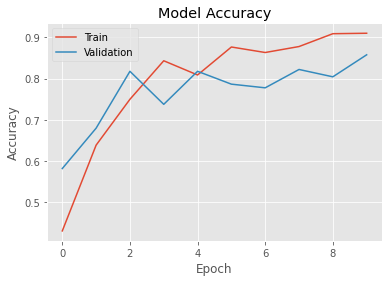

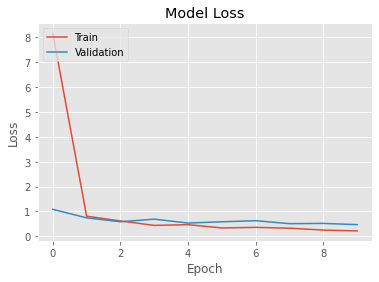

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


##### Evaluating the model on a separate test set

Como los datos están desbalanceados, evaluar el rendimiento del modelo solo con la accuracy no es fiable. Por este motivo, utilizaremos otras métricas como la matriz de confusión, el f1-score y la curva AUC-ROC, que son buenas formas de evaluar el rendimiento de un modelo de clasificación multiclase. 

Utilizamos el método predict() del modelo entrenado para obtener las probabilidades de clase predichas para los datos de test. 



In [ ]:
predicted = model_1_cnn.predict(X_test) # y_score

8/8 [==============================] - 8s 864ms/step


A continuación, aplicamos argmax para obtener la clase con mayor probabilidad como clase predicha para cada muestra.

In [ ]:
predictedClass = [np.argmax(p) for p in predicted]

Confusion matrix for multiclass classification problem:

<Axes: >

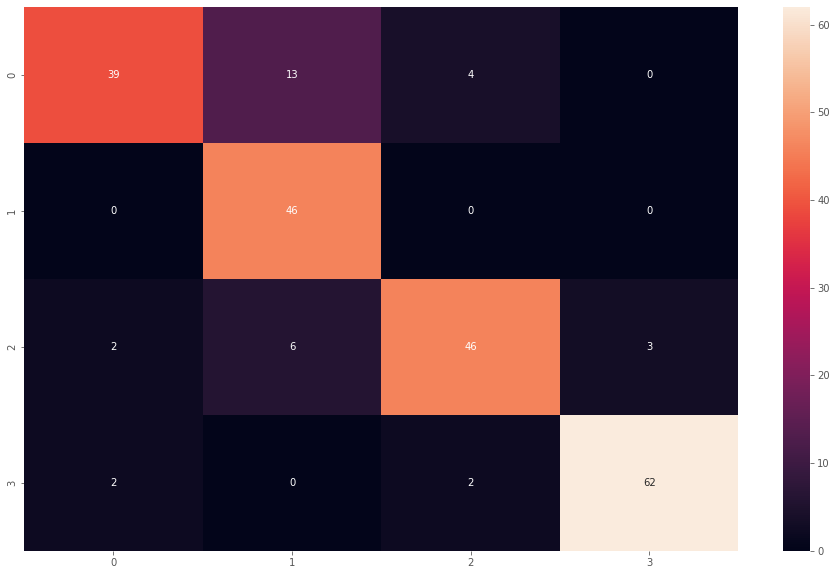

In [ ]:
# La función confusion_matrix() espera que tanto y_test_encoded como predictedClass tengan la misma forma y el mismo tipo.
# Convertimos y_test_encoded en una matriz simple de etiquetas de clase utilizando la función np.argmax(), que proporciona el índice del valor más alto de cada fila:
y_test_labels = np.argmax(y_test_encoded, axis=1)

conf_matrix = confusion_matrix(y_test_labels, predictedClass)
plt.figure(figsize = (16, 10))
sns.heatmap(conf_matrix, annot = True)

- Observamos que el modelo ha tenido más dificultades para clasificar correctamente las imágenes de la clase 0 (Cloudy). Para el resto de clases, a pesar del desbalanceo, el modelo ha clasificado bastante bien las imágenes en sus clases correspondientes. 

In [ ]:
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

print(classification_report(y_test_labels, predictedClass, target_names=target_names))


              precision    recall  f1-score   support

     Class 0       0.91      0.70      0.79        56
     Class 1       0.71      1.00      0.83        46
     Class 2       0.88      0.81      0.84        57
     Class 3       0.95      0.94      0.95        66

    accuracy                           0.86       225
   macro avg       0.86      0.86      0.85       225
weighted avg       0.87      0.86      0.86       225



La f1-score es una media armónica de la precisión y la recuperación, lo que significa que tiene en cuenta ambas métricas para proporcionar una evaluación más equilibrada del rendimiento del modelo.

- Observamos un f1-score bastante elevado para todas las clases, lo que significa que se trata de un buen modelo. 
- Podemos ver que el modelo tiene puntuaciones f1 altas para las cuatro clases, siendo la puntuación más baja 0.79 para la clase 0, lo que significa que el modelo es ligeramente menos preciso en la predicción de esta clase en comparación con las demás (como hemos visto en la matriz de confusión). Sin embargo, la puntuación f1 de la clase 0 sigue siendo relativamente alta, lo que indica que el modelo funciona bien en general.
- Podemos concluir que el modelo ha obtenido buenos resultados en la clasificación de las cuatro clases. 

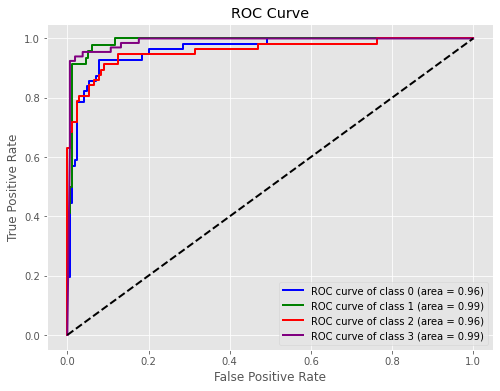

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 4
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], predicted[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'purple']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
# Plot random guessing line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot title, axis labels, and legend
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# Show plot
plt.show()


Una curva AUC-ROC representa la tasa de verdaderos positivos (TPR) frente a la tasa de falsos positivos (FPR) para diferentes umbrales de clasificación, y el área bajo la curva (AUC) es una medida de la capacidad del modelo para distinguir entre diferentes clases.

En nuestro  caso, hemos obtenido valores de AUC elevados para las cuatro clases, lo que indica que nuestro modelo es capaz de distinguir eficazmente entre las distintas clases. El valor AUC de 0.99 para las clases 1 y 3 sugiere que el modelo es especialmente bueno a la hora de distinguir estas clases de las demás.

En general, la combinación de las métricas de f1-score y curva AUC-ROC ofrece una evaluación completa del rendimiento del modelo. Por tanto, podemos decir que nuestro modelo funciona bien en esta tarea de clasificación multiclase.

#### 1.2

Modificaciones del modelo: 
- Disminuimos el learning rate de 0.001 a 0.0001.
- Aumentamos epochs de 10 a 30. 

Aumentando el número de epochs, el modelo tiene más tiempo para aprender de los datos y converger a una solución mejor.

Por otro lado, reducir la tasa de aprendizaje puede ayudar a que el modelo converja mejor y evite estancarse en mínimos locales.

In [ ]:
# define the number of classes
num_classes = 4

# create a sequential model
model = Sequential(
    [
      Input(shape=(256, 256, 3)), # input_shape: lo que miden las imágene
      # add convolutional layer
      layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'), # 32 filtros
      layers.MaxPooling2D(pool_size=(2, 2)), # aplicamos el 1r pooling
      layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
      layers.MaxPooling2D(pool_size=(2, 2)),
      # add dropout layer to reduce overfitting
      layers.Dropout(0.5),
      # add flatten layer
      layers.Flatten(), # para pasarlo a vector, porque a partir de aquí queremos extraer conocimiento y a continuación aplicamos MLP
      # add dense layer
      layers.Dense(256, activation='relu'), # aplicamos MLP
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation='softmax'), # queremos hacer la clasificacion de 4. Podriamos utilizar también la sigmoid pero la softmax es la que se suele utilizar.
  ]
)

# Optimizer 
opt = tf.keras.optimizers.Adam(learning_rate=0.0001) # instead of 0.01
# compile the model
model.compile(
              optimizer=opt, 
              loss='categorical_crossentropy', # categorical_crossentropy loss function porque es Multi-class
              metrics=['accuracy']
              )

# .summary(): if we want to see how many parameters our neural network is taking up.
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 62, 62, 64)        0         
                                                                 
 flatten_5 (Flatten)         (None, 246016)           

In [ ]:
# save the training
csv_logger = CSVLogger('/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/2_CNN/models/training_model_1_2_cnn.log')

In [ ]:
# Train the model: fit the model on the training data
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=128, 
                    epochs=30, 
                    validation_data=(X_test, y_test_encoded),
                    callbacks=[csv_logger]
                    )

Epoch 1/30
8/8 [==============================] - 171s 19s/step - loss: 1.4922 - accuracy: 0.4156 - val_loss: 0.9136 - val_accuracy: 0.6222
Epoch 2/30
8/8 [==============================] - 131s 16s/step - loss: 0.8302 - accuracy: 0.6733 - val_loss: 0.7145 - val_accuracy: 0.7600
Epoch 3/30
8/8 [==============================] - 132s 16s/step - loss: 0.6642 - accuracy: 0.7422 - val_loss: 0.6786 - val_accuracy: 0.7378
Epoch 4/30
8/8 [==============================] - 132s 16s/step - loss: 0.6016 - accuracy: 0.7711 - val_loss: 0.6516 - val_accuracy: 0.7956
Epoch 5/30
8/8 [==============================] - 137s 17s/step - loss: 0.5626 - accuracy: 0.7867 - val_loss: 0.7019 - val_accuracy: 0.7244
Epoch 6/30
8/8 [==============================] - 144s 18s/step - loss: 0.5125 - accuracy: 0.8167 - val_loss: 0.5889 - val_accuracy: 0.8089
Epoch 7/30
8/8 [==============================] - 148s 19s/step - loss: 0.4842 - accuracy: 0.8267 - val_loss: 0.6394 - val_accuracy: 0.7556
Epoch 8/30
8/8 [====

- Observamos que el modelo está mejorando con cada epoch. 
  - La accuracy de entrenamiento y de validación están aumentando gradualmente mientras que la pérdida de entrenamiento y la pérdida de validación están disminuyendo. 
  - Esta es una buena señal de que el modelo está aprendiendo y mejorando con los datos.

In [ ]:
# To save the model once it has been trained 
model.save('/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/2_CNN/models/model_1_2_cnn.h5')

In [ ]:
# Load up the model 
model_1_2_cnn_path = '/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/2_CNN/models/model_1_2_cnn.h5'
model_1_2_cnn = load_model(model_1_2_cnn_path)

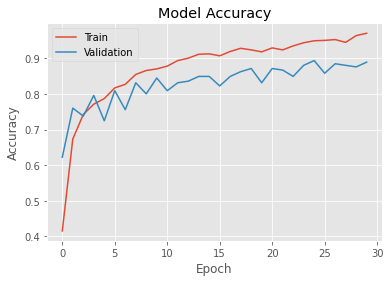

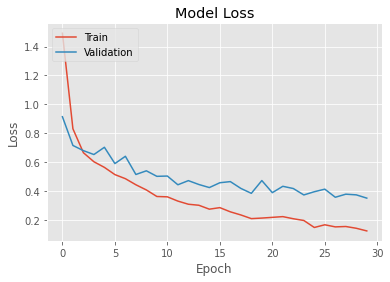

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##### Evaluating the model on a separate test set

Utilizamos el método predict() del modelo entrenado para obtener las probabilidades de clase predichas para los datos de test. 



In [ ]:
predicted = model_1_2_cnn.predict(X_test) # y_score

8/8 [==============================] - 15s 2s/step


A continuación, aplicamos argmax para obtener la clase con mayor probabilidad como clase predicha para cada muestra.

In [ ]:
predictedClass = [np.argmax(p) for p in predicted]

Confusion matrix for multiclass classification problem:

<Axes: >

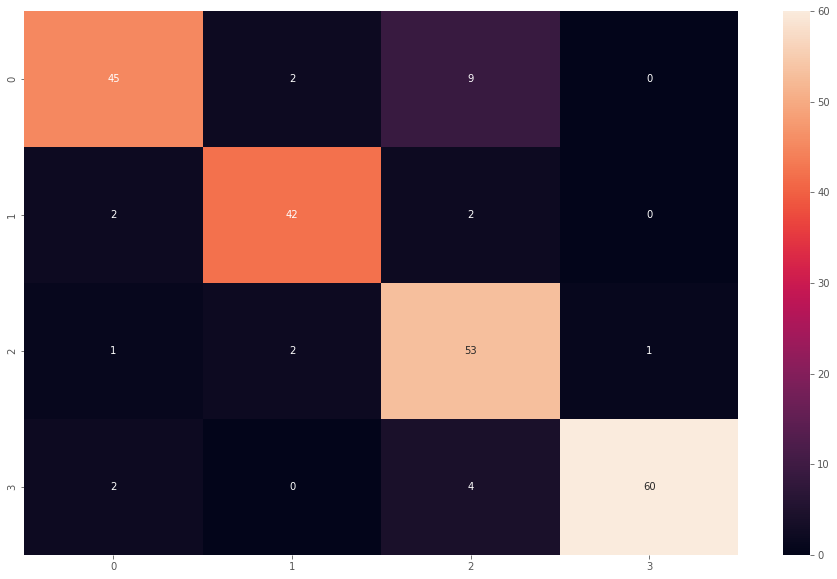

In [ ]:
# La función confusion_matrix() espera que tanto y_test_encoded como predictedClass tengan la misma forma y el mismo tipo.
# Convertimos y_test_encoded en una matriz simple de etiquetas de clase utilizando la función np.argmax(), que proporciona el índice del valor más alto de cada fila:
y_test_labels = np.argmax(y_test_encoded, axis=1)

conf_matrix = confusion_matrix(y_test_labels, predictedClass)
plt.figure(figsize = (16, 10))
sns.heatmap(conf_matrix, annot = True)

- De la misma forma que en el modelo anterior, donde este segundo modelo ha tenido más problemas para clasificar correctamente ha sido en la clase 0 (Cloudy). 

In [ ]:
from sklearn.metrics import classification_report

target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

print(classification_report(y_test_labels, predictedClass, target_names=target_names))


              precision    recall  f1-score   support

     Class 0       0.90      0.80      0.85        56
     Class 1       0.91      0.91      0.91        46
     Class 2       0.78      0.93      0.85        57
     Class 3       0.98      0.91      0.94        66

    accuracy                           0.89       225
   macro avg       0.89      0.89      0.89       225
weighted avg       0.90      0.89      0.89       225



- El modelo ha funcionado especialmente bien en la clase 3 (Surnise), con una f1-score de 0.94, lo que indica un alto grado de precisión en la identificación de casos de esta clase. La clase 1 también ha obtenido buenos resultados, con una f1-score de 0.91. Sin embargo, el rendimiento del modelo para las clases 0 y 2 ha sido comparativamente inferior, con f1-scores de 0.85. Esto sugiere que el modelo puede haber tenido algunas dificultades para identificar con precisión los casos de estas clases (como hemos visto en la matriz de confusión).

- No obstante, este segundo modelo tiene mejores f1-scores que el primero. Esto significa que el segundo modelo encuentra mejor el equilibrio entre precisión y recuperación y clasifica mejor las instancias de todas las clases. Por tanto, podemos concluir que el segundo modelo funciona mejor que el primero.

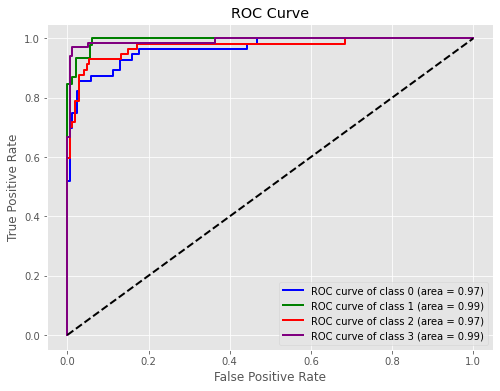

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 4
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], predicted[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'purple']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
# Plot random guessing line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot title, axis labels, and legend
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# Show plot
plt.show()


- Las puntuaciones AUC-ROC para cada clase indican que el modelo tiene un rendimiento de clasificación excelente para todas las clases, con puntuaciones que oscilan entre 0.97 y 0.99. 

- Las curvas AUC-ROC son útiles cuando tenemos un conjunto de datos desequilibrado (como es nuestro caso) o cuando queremos conocer la calidad del clasificador en todos los umbrales de clasificación posibles. 

- Por tanto, podemos concluir que este segundo modelo funciona mejor que el primero.

# 3_TimeSeries_Forecasting

## Objetivos

- El objetivo principal es predecir una variable meteorológica. En este caso, hemos elegido la temperatura: T (degC). 

## Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date 

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping

## Carga de datos

In [ ]:
# Mount Google Drive to store and load files. 
from google.colab import drive
drive.mount('drive') # mounting Google Drive

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
# Load dataset
path = '/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/3_TimeSeries_Forecasting/max_planck_weather_ts.csv'
max_planck_weather_df = pd.read_csv(path, delimiter=',')

## Exploratory Data Analysis (EDA)

El archivo CSV max_planck_weather_ts.csv contiene los datos de la serie temporal Max Planck Weather Dataset. Contiene variables descriptivas sobre el tiempo con marcas temporales (timestamp) de 10 minutos desde el 01-01-2009 00:10:00 hasta el 01-01-2017 00:00:00. 
Incluye 420551 instancias y 15 variables.

Descripción de las variables:
- **Date Time:** Date-time reference.
- **p (mbar):** The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars. 
- **T (degC):** Temperature in Celsius.
- **Tpot (K):** Temperature in Kelvin.
- **Tdew (degC):**	Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
- **rh (%):** Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
- **VPmax (mbar):**	Saturation vapor pressure.
- **VPact (mbar):**	Vapor pressure.
- **VPdef (mbar):**	Vapor pressure deficit.
- **sh (g/kg):**	Specific humidity.
- **H2OC (mmol/mol):** Water vapor concentration.
- **rho (g/m ** 3):**	Airtight.
- **wv (m/s):**	Wind speed.
- **max. wv (m/s):** Maximum wind speed.
- **wd (deg):**	Wind direction in degrees.

In [ ]:
# Checking the dataset
nrow, ncol = max_planck_weather_df.shape
print(f'Hay {nrow} filas y {ncol} columnas\n')
display(max_planck_weather_df.head()) # de forma predefinida retorna las primeras 5 observations
display(max_planck_weather_df.tail()) # de forma predefinida retorna las últimas 5 observations

Hay 420551 filas y 15 columnas



Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03           1.75     152.3  
1       1309.80      0.72           1.50     136.1  
2       1310.24      0.19           0.63     171.6  
3       1309.19      0.34           0.50     198.0  
4       1309.00      0.32           0.63     214.3

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
420546  31.12.2016 23:20:00   1000.07     -4.05    269.10        -8.13   
420547  31.12.2016 23:30:00    999.93     -3.35    269.81        -8.06   
420548  31.12.2016 23:40:00    999.82     -3.16    270.01        -8.21   
420549  31.12.2016 23:50:00    999.81     -4.23    268.94        -8.53   
420550  01.01.2017 00:00:00    999.82     -4.82    268.36        -8.42   

        rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
420546   73.10          4.52          3.30          1.22       2.06   
420547   69.71          4.77          3.32          1.44       2.07   
420548   67.91          4.84          3.28          1.55       2.05   
420549   71.80          4.46          3.20          1.26       1.99   
420550   75.70          4.27          3.23          1.04       2.01   

        H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
420546             3.30       1292.98      0.67           1.52     240.0  
420547             3.32       1289.44      1.14           1.92     234.3  
420548             3.28       1288.39      1.08           2.00     215.2  
420549             3.20       1293.56      1.49           2.16     225.8  
420550             3.23       1296.38      1.23           1.96     184.9

In [ ]:
# Info de las columnas del df
max_planck_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


- No hay valores nulos. 
- Todas las variables son numéricas, excepto Date Time, que es object. 
- Date Time la debemos convertir a formato datatime. 

In [ ]:
# Convertimos Date Time a datetime64 format:
max_planck_weather_df["Date Time"] = pd.to_datetime(max_planck_weather_df["Date Time"], format = "%d.%m.%Y %H:%M:%S" )

max_planck_weather_df.dtypes

Date Time          datetime64[ns]
p (mbar)                  float64
T (degC)                  float64
Tpot (K)                  float64
Tdew (degC)               float64
rh (%)                    float64
VPmax (mbar)              float64
VPact (mbar)              float64
VPdef (mbar)              float64
sh (g/kg)                 float64
H2OC (mmol/mol)           float64
rho (g/m**3)              float64
wv (m/s)                  float64
max. wv (m/s)             float64
wd (deg)                  float64
dtype: object

In [ ]:
# sort dataframe by date_time
max_planck_weather_df = max_planck_weather_df.sort_values(by='Date Time')  

In [ ]:
max_planck_weather_df.shape

(420551, 15)

In [ ]:
# Miramos si hay valores nulos en el dataset:
max_planck_weather_df.isnull().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

- No tenemos valores nulos. 

In [ ]:
# Summary statistics
max_planck_weather_df.describe()

p (mbar)       T (degC)       Tpot (K)    Tdew (degC)  \
count  420551.000000  420551.000000  420551.000000  420551.000000   
mean      989.212776       9.450147     283.492743       4.955854   
std         8.358481       8.423365       8.504471       6.730674   
min       913.600000     -23.010000     250.600000     -25.010000   
25%       984.200000       3.360000     277.430000       0.240000   
50%       989.580000       9.420000     283.470000       5.220000   
75%       994.720000      15.470000     289.530000      10.070000   
max      1015.350000      37.280000     311.340000      23.110000   

              rh (%)   VPmax (mbar)   VPact (mbar)   VPdef (mbar)  \
count  420551.000000  420551.000000  420551.000000  420551.000000   
mean       76.008259      13.576251       9.533756       4.042412   
std        16.476175       7.739020       4.184164       4.896851   
min        12.950000       0.950000       0.790000       0.000000   
25%        65.210000       7.780000       6.210000       0.870000   
50%        79.300000      11.820000       8.860000       2.190000   
75%        89.400000      17.600000      12.350000       5.300000   
max       100.000000      63.770000      28.320000      46.010000   

           sh (g/kg)  H2OC (mmol/mol)   rho (g/m**3)       wv (m/s)  \
count  420551.000000    420551.000000  420551.000000  420551.000000   
mean        6.022408         9.640223    1216.062748       1.702224   
std         2.656139         4.235395      39.975208      65.446714   
min         0.500000         0.800000    1059.450000   -9999.000000   
25%         3.920000         6.290000    1187.490000       0.990000   
50%         5.590000         8.960000    1213.790000       1.760000   
75%         7.800000        12.490000    1242.770000       2.860000   
max        18.130000        28.820000    1393.540000      28.490000   

       max. wv (m/s)       wd (deg)  
count  420551.000000  420551.000000  
mean        3.056555     174.743738  
std        69.016932      86.681693  
min     -9999.000000       0.000000  
25%         1.760000     124.900000  
50%         2.960000     198.100000  
75%         4.740000     234.100000  
max        23.500000     360.000000

- El método df.describe() genera estadísticas descriptivas de un df. Obtenemos el recuento, la media, la desviación estándar, el mínimo, el primer cuartil (25%), la mediana (50%), el tercer cuartil (75%) y el máximo de cada columna.

- Esta información puede ser útil para comprender la distribución y el rango de valores de cada columna del df.

- Para la variable T (degC), que es la que nos interesará predecir, los valores de la media y la mediana están relativamente próximos.


### Visualización de las variables

Gráfico de los datos de la serie temporal para cada variable por año:

In [ ]:
# descripción de las variables
titles = [
    "Pressure (mbar)",
    "Temperature (Celsius)",
    "Temperature (Kelvin)",
    "Dew Point Temperature (Celsius)",
    "Relative Humidity (%)",
    "Saturation vapor pressure (mbar)",
    "Vapor pressure (mbar)",
    "Vapor pressure deficit (mbar)",
    "Specific humidity (g/kg)",
    "Water vapor concentration (mmol/mol)",
    "Airtight (g/m^3)",
    "Wind speed (m/s)",
    "Maximum wind speed (m/s)",
    "Wind direction (degrees)",
]
# nombre variables
feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

# colores de los gráficos
colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
    "teal",
    "navy",
    "magenta",
    "lime",
]

# set the date and time key
date_time_key = "Date Time"

<ipython-input-109-2dde1f76bd0d>:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


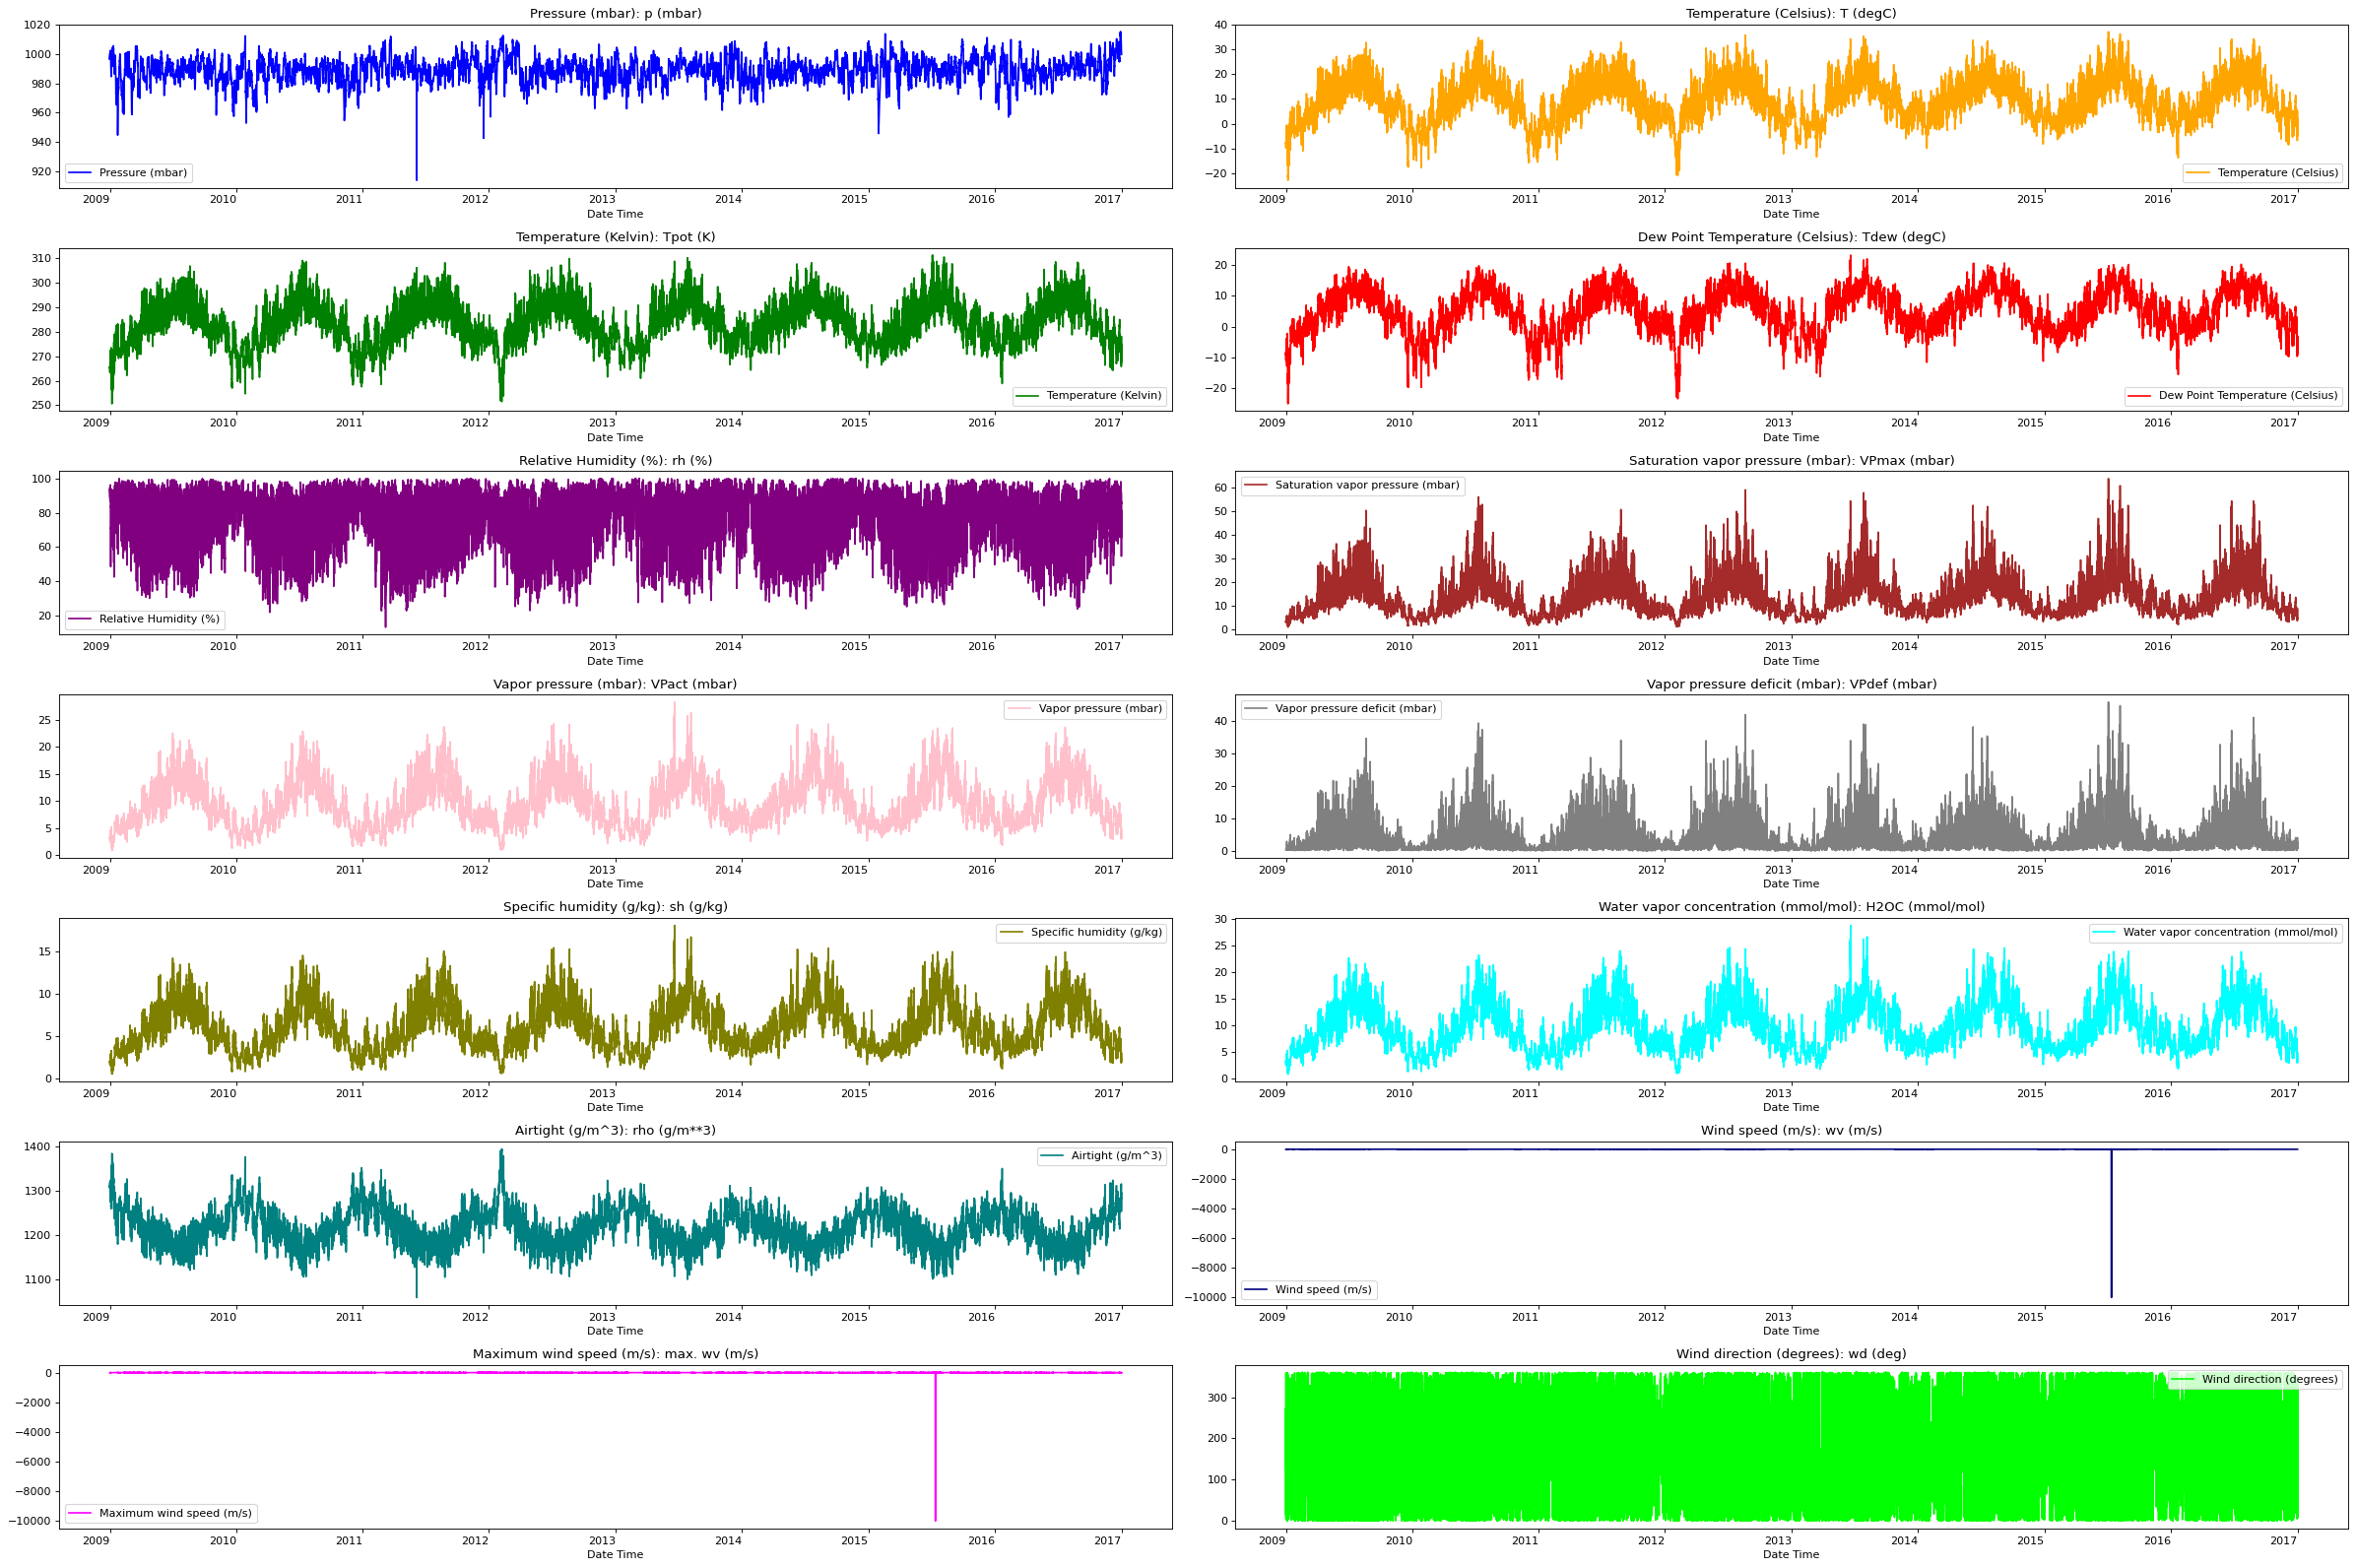

In [ ]:
def show_features_years(data):
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(30, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    years = data[date_time_key].dt.year.unique()
    for year in years:
        year_data = data[data[date_time_key].dt.year == year]
        time_data = year_data[date_time_key]
        for i in range(len(feature_keys)):
            key = feature_keys[i]
            c = colors[i % (len(colors))]
            t_data = year_data[key]
            t_data.index = time_data
            t_data.head()
            ax = t_data.plot(
                ax=axes[i // 2, i % 2],
                color=c,
                title="{}: {}".format(titles[i], key),
                rot=0,
            )
            ax.legend([titles[i]])
    plt.tight_layout()


show_features_years(max_planck_weather_df)

- Observando todas las variables meteorológicas, escogemos analizar y predecir la temperatura (T (degC)). Podemos observar que, como otras variables, sigue un patrón muy marcado en cada año: ascendiendo la primera mitad del año y descendiendo en la segunda mitad del año. 

### Visualización Temperatura (Celsius)

Temperatura a lo largo de los años: 

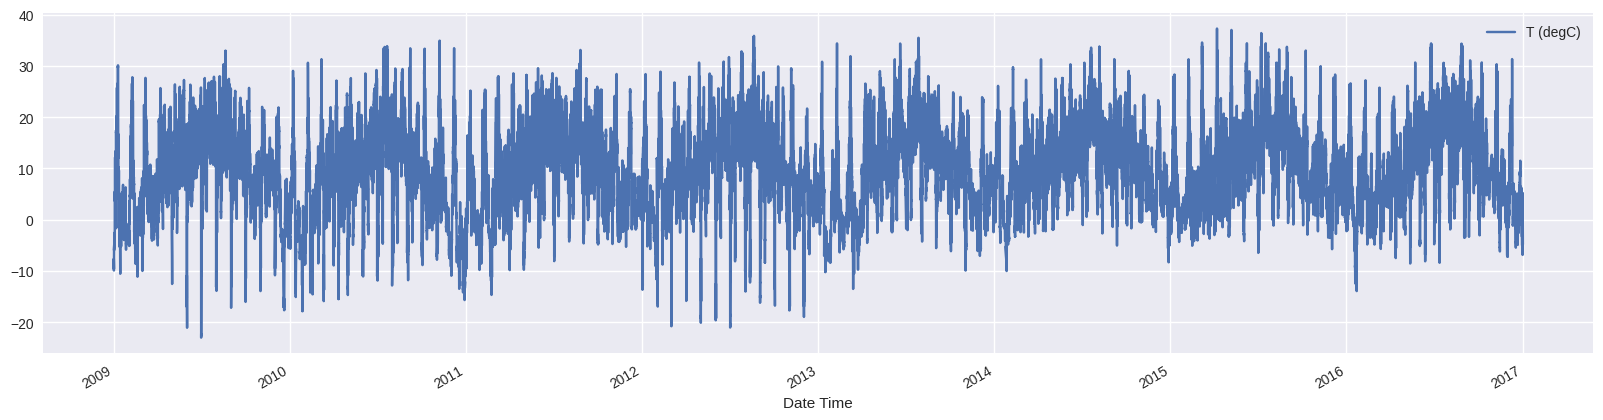

In [ ]:
plt.style.use('seaborn-v0_8')
plt.rcParams["figure.figsize"] = (20, 5)

date_time = max_planck_weather_df['Date Time']
plot_cols = ['T (degC)']
plot_features = max_planck_weather_df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

Temperatura para cada año y mes:

In [ ]:
def plot_variable_by_year(df, var_name):
    # Convert "Date Time" column to datetime type
    df["Date Time"] = pd.to_datetime(df["Date Time"])
    
    # Extract year from "Date Time" column
    df["Year"] = df["Date Time"].dt.year
    
    # Get the years with data
    years = df["Year"].unique()
    
    # Define the colors for the line plots
    colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive"]
    
    # Create subplots for each year
    fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(20, 50), dpi=80, facecolor="w", edgecolor="k")
  
    # Loop over each year with data
    for i, year in enumerate(years):
         # Skip year 2017 
        if year == 2017:
            continue
        
        # Subset the dataframe for the current year
        year_df = df.loc[df["Year"] == year]
        
        # Plot the variable for the current year
        ax = year_df.plot(x="Date Time", y=var_name, color=colors[i], ax=axes[i], legend=None)
        
        # Set the plot title to the current year
        ax.set_title(str(year), fontsize=14)
    
    # Set the main plot title
    fig.suptitle(var_name, fontsize=20)
    
    # Adjust the spacing between subplots and the main title 
    plt.subplots_adjust(hspace=0.6, wspace=10, top=0.95)
    
    # Show the plot
    plt.show()

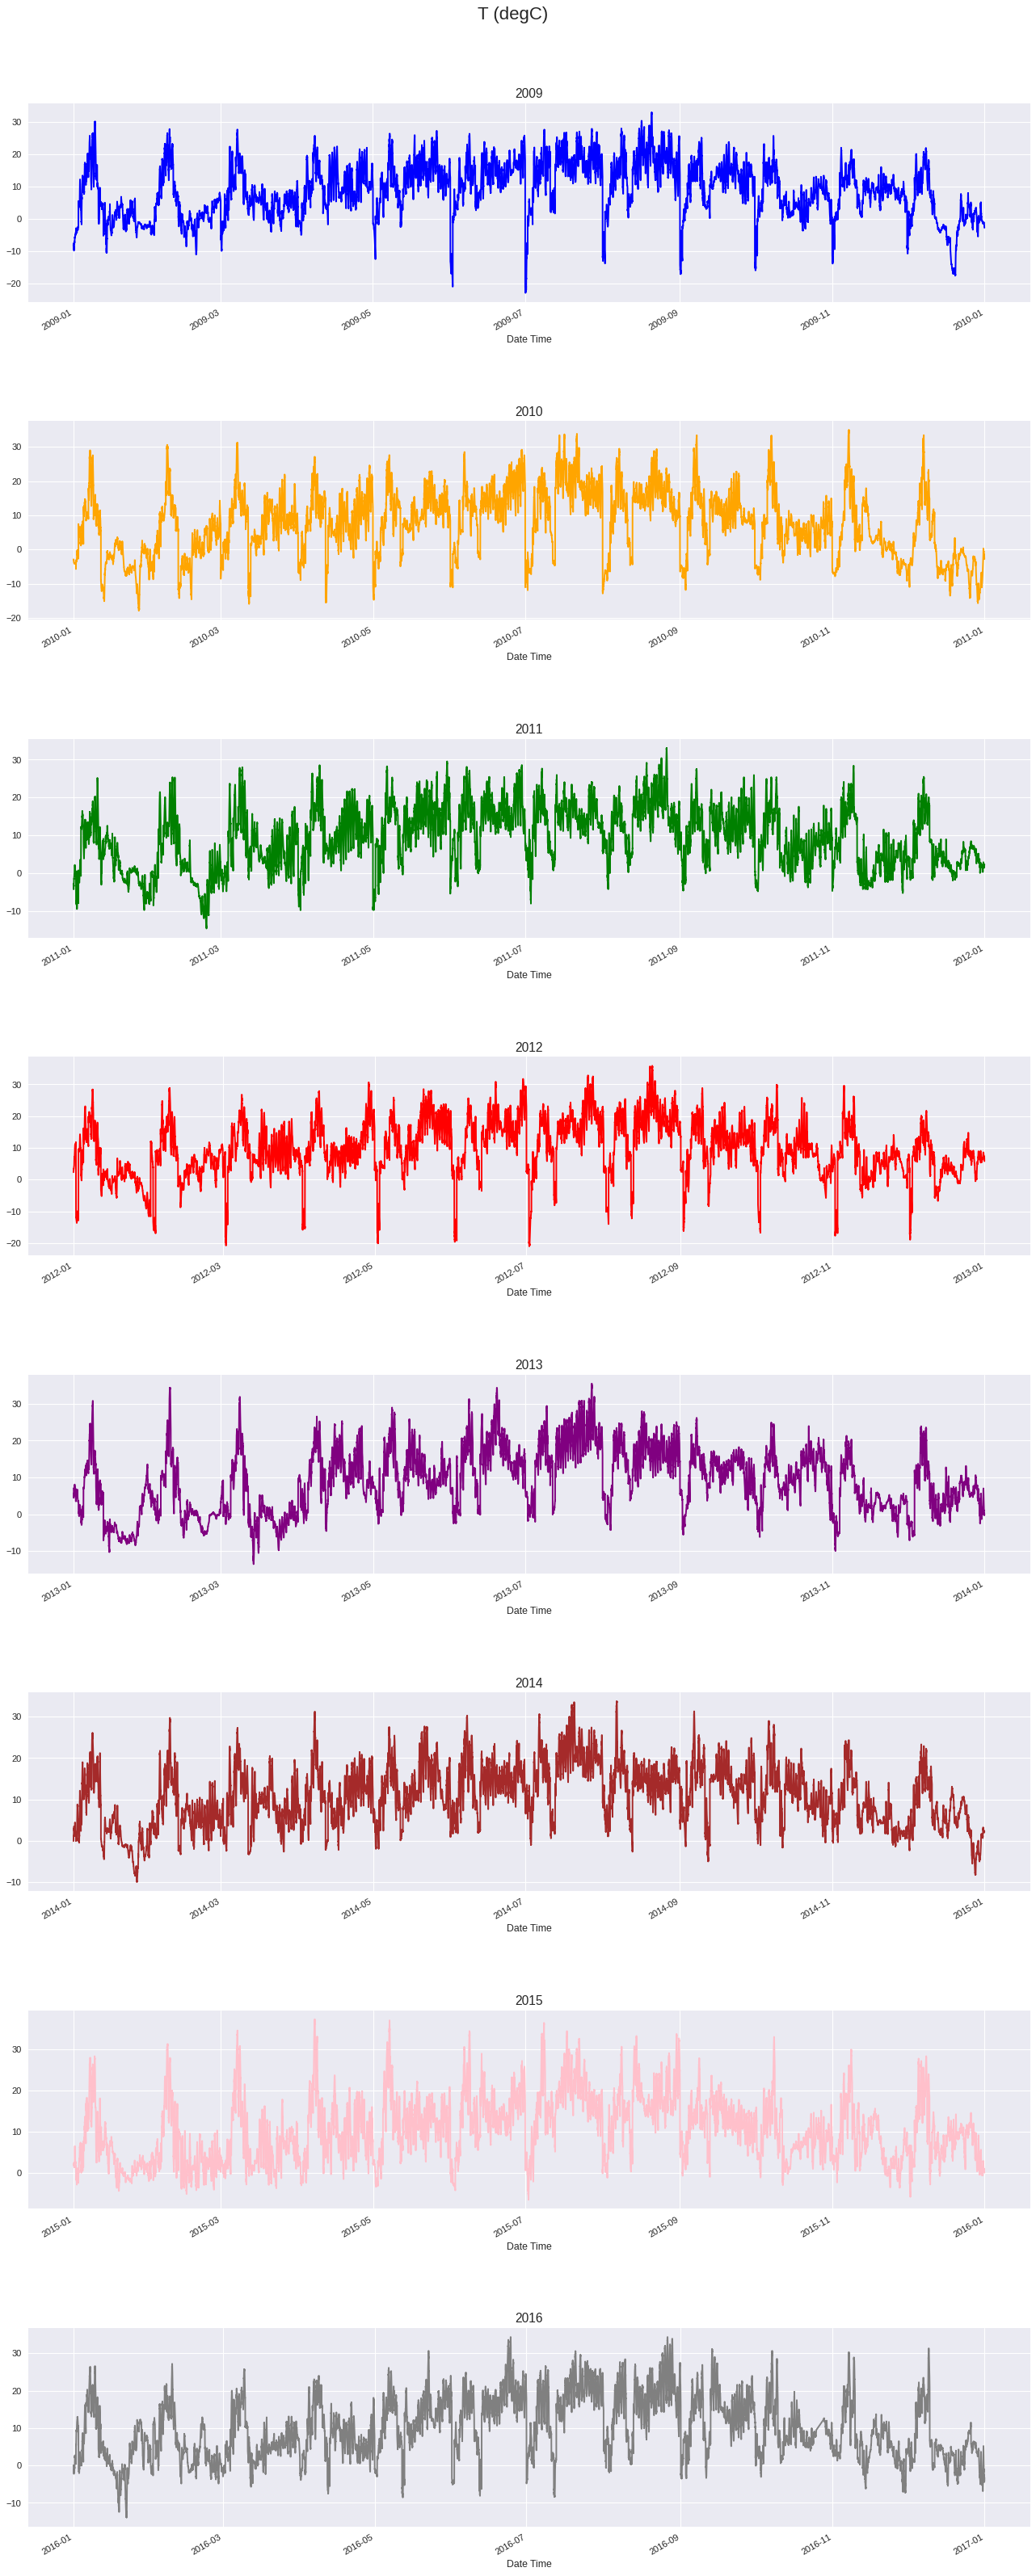

In [ ]:
plot_variable_by_year(max_planck_weather_df, "T (degC)")

Distribución de la temperatura por meses a lo largo de los años:

- Boxplot de la variable "T (degC)" para cada mes de cada año:

In [ ]:
def boxplots_by_year(df, variable_name):
    plt.style.use('seaborn-v0_8')
    # convertir la columna Date Time en datetime
    df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

    # crear una columna con el año
    df['Year'] = df['Date Time'].dt.year

    # crear una columna con el mes
    df['Month'] = df['Date Time'].dt.month

    # recorrer los años y crear un gráfico para cada año que contenga los 12 boxplots correspondientes a cada mes
    for year in range(2009, 2018):
        # skip year 2017
        if year == 2017:
            continue
        data_by_year = []
        for month in range(1, 13):
            data = df[(df['Year'] == year) & (df['Month'] == month)]
            if len(data) > 0:
                data_by_year.append(data[variable_name])
        if len(data_by_year) > 0:
            plt.figure()
            plt.boxplot(data_by_year)
            plt.title(f'{variable_name} distribution for year {year}')
            plt.ylabel(f'{variable_name}')
            plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            plt.show()


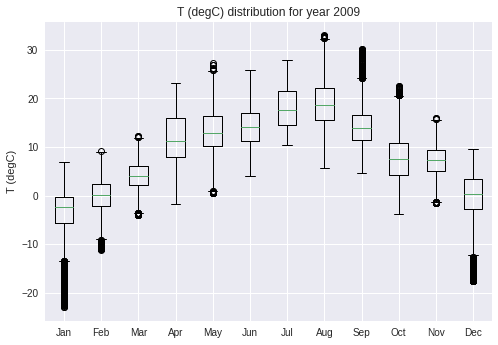

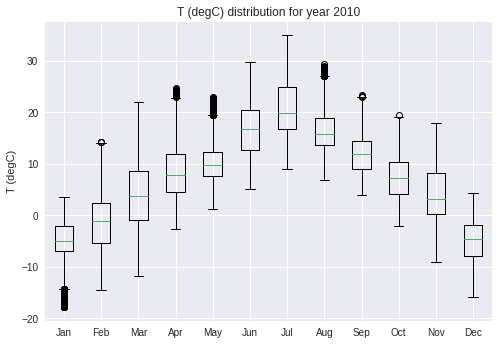

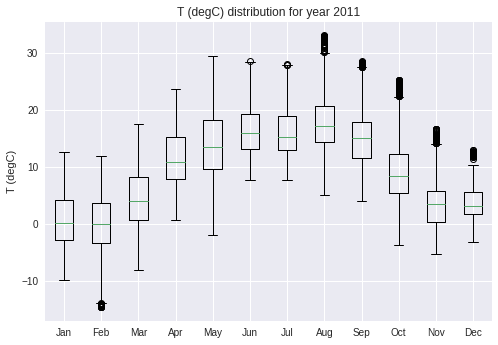

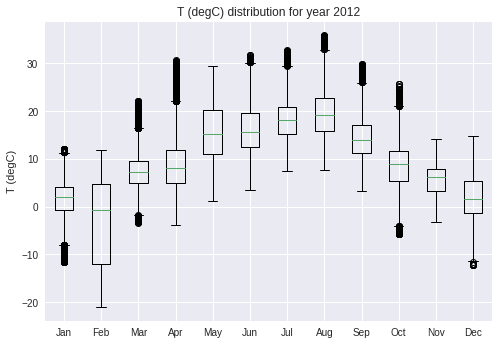

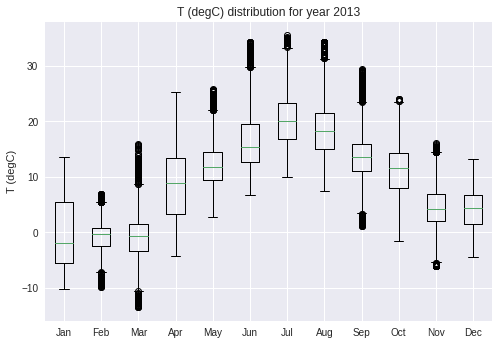

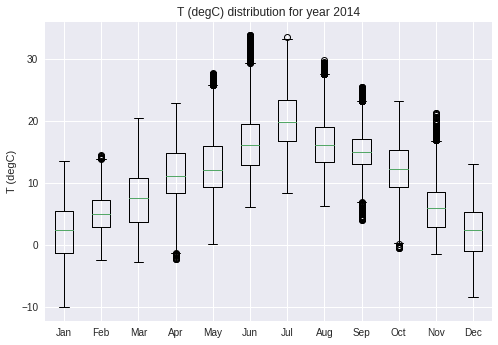

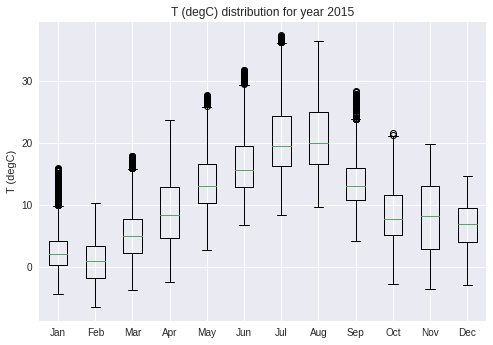

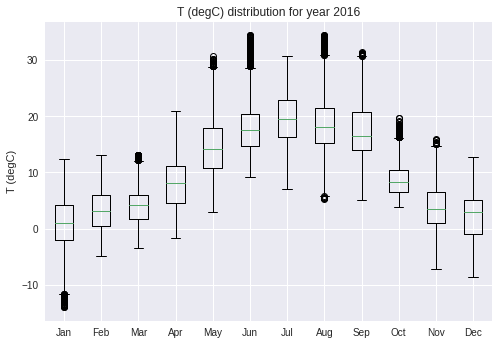

In [ ]:
boxplots_by_year(max_planck_weather_df, 'T (degC)')


- A partir de las visualizaciones anteriores, podemos observar que la temperatura sigue una distribución muy parecida en todos los años.

## Data preprocessing

### Filas duplicadas

- Es posible que haya filas duplicadas en el dataset: las eliminamos. 


Calculamos el número total de filas en max_planck_weather_df que tienen valores idénticos en todas las columnas. Esto puede ayudarnos a identificar posibles problemas de calidad de los datos, como errores de introducción o duplicación de datos.


In [ ]:
print(max_planck_weather_df.duplicated(keep=False).sum())

654


- Hay 654 filas en max_planck_weather_df que tienen valores idénticos en todas las columnas.

In [ ]:
print(max_planck_weather_df.duplicated().sum())

327


- Hay 327 filas en max_planck_weather_df que tienen valores idénticos en todas las columnas, excepto en sus valores de índice.

In [ ]:
# Eliminamos los duplicados
unique_max_planck_weather_df = max_planck_weather_df.drop_duplicates().reset_index(drop=True)

In [ ]:
print(unique_max_planck_weather_df.shape)

(420224, 15)


In [ ]:
print(unique_max_planck_weather_df.duplicated().sum())

0


- Ya no tenemos filas duplicadas en el dataset.

### Diferencia de tiempo en minutos entre cada par de observaciones consecutivas

La columna "time_diff_min" contiene la diferencia de tiempo en minutos entre cada par de observaciones consecutivas:

In [ ]:
unique_max_planck_weather_df['time_diff_min'] = unique_max_planck_weather_df['Date Time'].diff().astype('timedelta64[m]')
unique_max_planck_weather_df['time_diff_min'].value_counts()

10.0      420218
20.0           2
30.0           1
960.0          1
4460.0         1
Name: time_diff_min, dtype: int64

- Observamos que la diferencia horaria más común entre observaciones consecutivas es de 10 minutos (ocurre 420218 veces). Por tanto, en la mayoría de los casos, las observaciones meteorológicas se han tomado con un intervalo regular de 10 minutos.

- No obstante, también hay algunos casos en los que la diferencia horaria no es de 10 minutos:
  - 2 observaciones en las que la diferencia horaria es de 20 minutos
  - 1 observación en la que la diferencia horaria es de 30 minutos
  - 1 observación en la que la diferencia horaria es de 960 minutos
  - 1 observación en la que la diferencia horaria es de 4460 minutos
Los valores que aparecen sólo una o dos veces, podrían indicar que hay algunas irregularidades o missing values en el dataset.

Investigaremos más a fondo estas irregularidades para asegurarnos de que los datos son adecuados.

Caso 4460 minutos: 

- 4460 minutos son aproximadamente 3 días. 
- Mostramos las observaciones meteorológicas tomadas antes, durante y después de la larga diferencia. 

In [ ]:
4460/60/24 

3.097222222222222

In [ ]:
index = unique_max_planck_weather_df.loc[unique_max_planck_weather_df['time_diff_min']==4460].index.values[0]
unique_max_planck_weather_df[index-1:index+2]

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
410939 2016-10-25 10:30:00    994.67      9.48    283.07         8.33    92.5   
410940 2016-10-28 12:50:00   1003.87     12.44    285.28         7.96    74.1   
410941 2016-10-28 13:00:00   1003.87     12.64    285.48         8.06    73.6   

        VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
410939         11.87         10.98          0.89       6.90            11.04   
410940         14.46         10.71          3.74       6.66            10.67   
410941         14.65         10.78          3.87       6.71            10.74   

        rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  time_diff_min  
410939       1220.83      1.53           2.24     144.1           10.0  
410940       1219.53      1.52           4.22     283.9         4460.0  
410941       1218.64      1.87           4.34     209.4           10.0

- Observamos que la fila con índice index-1 tiene una diferencia de tiempo de 10 minutos con la fila anterior, la fila con índice index tiene una diferencia de tiempo de 4460 minutos con la fila anterior y la fila con índice index+1 tiene una diferencia de tiempo de 10 minutos con la fila con índice index.

Hacemos lo mismo para las 2 observaciones en las que la diferencia horaria es de 20 minutos, la observación en la que la diferencia horaria es de 30 minutos
y la observación en la que la diferencia horaria es de 960 minutos:

In [ ]:
# 2 obs --> dif de 20 min
index_20_0 = unique_max_planck_weather_df.loc[unique_max_planck_weather_df['time_diff_min']==20].index.values[0]
display(unique_max_planck_weather_df[index_20_0-1:index_20_0+2])

index_20_1 = unique_max_planck_weather_df.loc[unique_max_planck_weather_df['time_diff_min']==20].index.values[1]
display(unique_max_planck_weather_df[index_20_1-1:index_20_1+2])

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
229874 2013-05-16 08:50:00    973.59     16.69    292.08        12.74    77.5   
229875 2013-05-16 09:10:00    973.31     16.85    292.26        12.94    77.7   
229876 2013-05-16 09:20:00    973.05     16.89    292.33        13.11    78.4   

        VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
229874         19.03         14.75          4.28       9.48            15.15   
229875         19.22         14.94          4.29       9.60            15.35   
229876         19.27         15.11          4.16       9.72            15.53   

        rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  time_diff_min  
229874       1163.42      1.78           3.50     54.28           10.0  
229875       1162.36      2.66           4.68     46.60           20.0  
229876       1161.81      2.95           4.52     42.73           10.0

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
293228 2014-07-30 08:00:00    981.50     19.71    294.44        18.22    91.1   
293229 2014-07-30 08:20:00    981.58     20.06    294.78        18.26    89.4   
293230 2014-07-30 08:30:00    981.63     19.91    294.63        18.29    90.4   

        VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
293228         23.00         20.96          2.05      13.39            21.35   
293229         23.51         21.02          2.49      13.43            21.41   
293230         23.29         21.05          2.24      13.45            21.45   

        rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  time_diff_min  
293228       1158.04      0.31           0.60    101.80           10.0  
293229       1156.73      0.93           1.36     78.40           20.0  
293230       1157.36      0.78           1.18     67.82           10.0

In [ ]:
# 1 obs --> dif de 30 min
index_30 = unique_max_planck_weather_df.loc[unique_max_planck_weather_df['time_diff_min']==30].index.values[0]
display(unique_max_planck_weather_df[index_30-1:index_30+2])

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
40377 2009-10-08 09:40:00    983.19     17.80    292.37        13.86   77.70   
40378 2009-10-08 10:10:00    983.60     20.52    295.07        12.99   61.97   
40379 2009-10-08 10:20:00    983.69     20.46    295.00        13.08   62.56   

       VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
40377         20.41         15.86          4.55      10.10            16.13   
40378         24.18         14.99          9.20       9.53            15.24   
40379         24.10         15.07          9.02       9.59            15.32   

       rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  time_diff_min  
40377       1169.97      1.93           5.38     248.5           10.0  
40378       1160.02      6.53           8.93     242.2           30.0  
40379       1160.32      4.61           9.13     240.5           10.0

In [ ]:
# 1 obs --> dif de 960 min
index_960 = unique_max_planck_weather_df.loc[unique_max_planck_weather_df['time_diff_min']==960].index.values[0]
display(unique_max_planck_weather_df[index_960-1:index_960+2])

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
301345 2014-09-24 17:00:00    984.50     14.04    288.49         6.99   62.44   
301346 2014-09-25 09:00:00    989.73     12.34    286.34         8.68   78.30   
301347 2014-09-25 09:10:00    989.73     12.43    286.43         8.77   78.30   

        VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
301345         16.05         10.02          6.03       6.36            10.18   
301346         14.36         11.25          3.12       7.10            11.36   
301347         14.45         11.31          3.14       7.14            11.43   

        rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  time_diff_min  
301345       1189.56      1.52           2.20     191.0           10.0  
301346       1202.46      2.63           4.34     240.7          960.0  
301347       1202.05      2.29           4.57     242.1           10.0

### Interpolación

Como la mayoría de los data points se registraron en intervalos de 10 minutos y hay algunos valores en los que el intervalo es diferente, podemos intentar interpolar los valores que faltan para rellenar los gaps. 

Utilizaremos la interpolación lineal, que asume una línea recta entre los data points conocidos.

In [ ]:
# set the 'Date Time' column as the index
unique_max_planck_weather_df.set_index('Date Time', inplace = True)

In [ ]:
unique_max_planck_weather_df.head(2)

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28    93.4   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
2009-01-01 00:10:00          3.33          3.11          0.22       1.94   
2009-01-01 00:20:00          3.23          3.02          0.21       1.89   

                     H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time                                                                     
2009-01-01 00:10:00             3.12       1307.75      1.03           1.75   
2009-01-01 00:20:00             3.03       1309.80      0.72           1.50   

                     wd (deg)  time_diff_min  
Date Time                                     
2009-01-01 00:10:00     152.3            NaN  
2009-01-01 00:20:00     136.1           10.0

In [ ]:
# resample the data to 10-minute intervals and fill in the missing values using linear interpolation
resampled_df = unique_max_planck_weather_df.resample('10T').interpolate(method='linear') # 10T or 10Min = 10 minutes 
resampled_df.head(2)

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28    93.4   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
2009-01-01 00:10:00          3.33          3.11          0.22       1.94   
2009-01-01 00:20:00          3.23          3.02          0.21       1.89   

                     H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time                                                                     
2009-01-01 00:10:00             3.12       1307.75      1.03           1.75   
2009-01-01 00:20:00             3.03       1309.80      0.72           1.50   

                     wd (deg)  time_diff_min  
Date Time                                     
2009-01-01 00:10:00     152.3            NaN  
2009-01-01 00:20:00     136.1           10.0

In [ ]:
resampled_df.shape

(420768, 15)

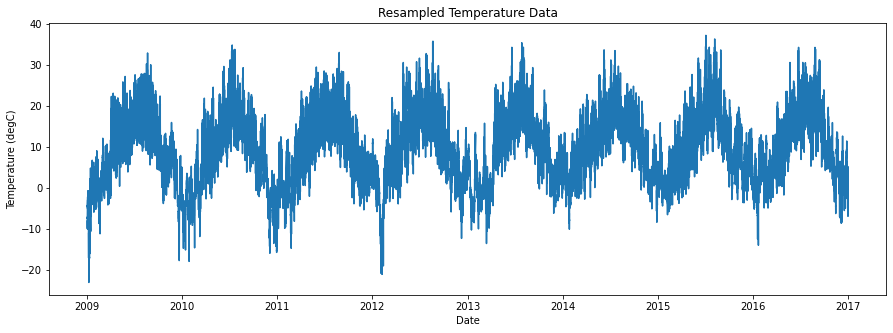

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(resampled_df.index, resampled_df['T (degC)'])
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (degC)')
ax.set_title('Resampled Temperature Data')
plt.show()


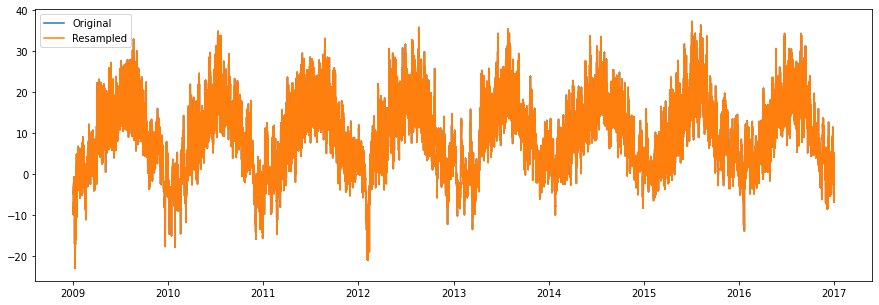

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(unique_max_planck_weather_df.index, unique_max_planck_weather_df['T (degC)'], label='Original')
ax.plot(resampled_df['T (degC)'], label='Resampled')
ax.legend()
plt.show()

In [ ]:
# Save df as csv to Google Drive
resampled_df.to_csv('resampled_df.csv')
!cp resampled_df.csv "/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/3_TimeSeries_Forecasting/" 

In [ ]:
# Read csv from Google Drive in Google Colab 
resampled_df = pd.read_csv('/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/3_TimeSeries_Forecasting/resampled_df.csv')
resampled_df.head(2)

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28    93.4   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  time_diff_min  
0       1307.75      1.03           1.75     152.3            NaN  
1       1309.80      0.72           1.50     136.1           10.0

In [ ]:
# miramos data types
resampled_df.dtypes

Date Time           object
p (mbar)           float64
T (degC)           float64
Tpot (K)           float64
Tdew (degC)        float64
rh (%)             float64
VPmax (mbar)       float64
VPact (mbar)       float64
VPdef (mbar)       float64
sh (g/kg)          float64
H2OC (mmol/mol)    float64
rho (g/m**3)       float64
wv (m/s)           float64
max. wv (m/s)      float64
wd (deg)           float64
time_diff_min      float64
dtype: object

In [ ]:
# Convertimos Date Time a datetime64 format:
resampled_df["Date Time"] = pd.to_datetime(resampled_df["Date Time"], format = "%Y.%m.%d")
print(resampled_df.dtypes)


Date Time          datetime64[ns]
p (mbar)                  float64
T (degC)                  float64
Tpot (K)                  float64
Tdew (degC)               float64
rh (%)                    float64
VPmax (mbar)              float64
VPact (mbar)              float64
VPdef (mbar)              float64
sh (g/kg)                 float64
H2OC (mmol/mol)           float64
rho (g/m**3)              float64
wv (m/s)                  float64
max. wv (m/s)             float64
wd (deg)                  float64
time_diff_min             float64
dtype: object


In [ ]:
# 'Date Time' as index
resampled_df.set_index('Date Time', inplace = True)
resampled_df.head(2)

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28    93.4   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
2009-01-01 00:10:00          3.33          3.11          0.22       1.94   
2009-01-01 00:20:00          3.23          3.02          0.21       1.89   

                     H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time                                                                     
2009-01-01 00:10:00             3.12       1307.75      1.03           1.75   
2009-01-01 00:20:00             3.03       1309.80      0.72           1.50   

                     wd (deg)  time_diff_min  
Date Time                                     
2009-01-01 00:10:00     152.3            NaN  
2009-01-01 00:20:00     136.1           10.0

Ahora hemos de concatenar los datos remuestreados (resampled) con los datos originales para rellenar los huecos o gaps: 


In [ ]:
# concatenate the resampled data with the original data
filled_df = pd.concat([unique_max_planck_weather_df, resampled_df])
# drop duplicates
filled_df = filled_df.drop_duplicates(keep=False)
print(filled_df.shape)

(544, 15)


- Con la interpolación, hemos añadido 544 filas. 


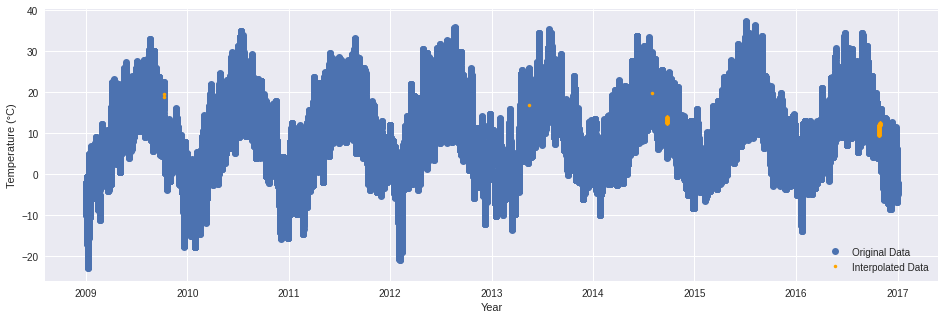

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
plt.style.use('seaborn-v0_8') # seaborn-v0_8

# plot the original dataset
ax.plot(unique_max_planck_weather_df.index, unique_max_planck_weather_df['T (degC)'], 'o', label='Original Data')

# plot the interpolated points
ax.plot(filled_df['T (degC)'], '.', color = 'orange', label='Interpolated Data')

ax.set_xlabel('Year')
ax.set_ylabel('Temperature (°C)')
ax.legend()
plt.show()

Comprobamos que todas las diferencias de tiempo en resampled_df son de 10 minutos:

In [ ]:
resampled_df['time_diff_min'] =  resampled_df.index.shift(1) - resampled_df.index 
resampled_df['time_diff_min'].value_counts()

0 days 00:10:00    420768
Name: time_diff_min, dtype: int64

- Efectivamente, todas las diferencias de tiempo en resampled_df son de 10 minutos. 

Por tanto, llegados a este punto, tenemos todos los datos meteorológicos espaciados el mismo período de tiempo: todas las observaciones meteorológicas se han tomado con un intervalo regular de 10 minutos.

In [ ]:
# Eliminamos la columna time_diff_min ya que ya no la necesitamos:
resampled_df.drop('time_diff_min', inplace=True, axis=1)

In [ ]:
resampled_df.head(2)

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28    93.4   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
2009-01-01 00:10:00          3.33          3.11          0.22       1.94   
2009-01-01 00:20:00          3.23          3.02          0.21       1.89   

                     H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time                                                                     
2009-01-01 00:10:00             3.12       1307.75      1.03           1.75   
2009-01-01 00:20:00             3.03       1309.80      0.72           1.50   

                     wd (deg)  
Date Time                      
2009-01-01 00:10:00     152.3  
2009-01-01 00:20:00     136.1

## Predicción de la temperatura (T (degC)) 


Recordemos que el objetivo principal de este proyecto era construir un modelo de forecasting para predecir una variable meteorológica. En este caso, hemos elegido la temperatura: T (degC). 

Los registros de temperatura los tenemos cada 10 minutos desde el 01-01-2009 00:10:00 hasta el 01-01-2017 00:00:00. Como tenemos tantos registros y además es poco probable que la temperatura experimente cambios bruscos cada 10 minutos, cogeremos la temperatura media por día. Es decir, muestreamos los datos a un día y calculamos la temperatura media de ese día. 

In [ ]:
# resample data to daily frequency and compute mean
resamp_mean_temp_df = resampled_df['T (degC)'].resample('1D').mean().reset_index(drop=False) # resample('1D'): data resampled to a daily frequency.
resamp_mean_temp_df

Date Time  T (degC)
0    2009-01-01 -6.810629
1    2009-01-02 -3.728194
2    2009-01-03 -5.271736
3    2009-01-04 -1.375208
4    2009-01-05 -4.867153
...         ...       ...
2918 2016-12-28  4.887153
2919 2016-12-29  2.676250
2920 2016-12-30 -1.706597
2921 2016-12-31 -2.492500
2922 2017-01-01 -4.820000

[2923 rows x 2 columns]

In [ ]:
# miramos missing values
resamp_mean_temp_df.isnull().sum()

Date Time    0
T (degC)     0
dtype: int64

In [ ]:
# Miramos formato
resamp_mean_temp_df.dtypes

Date Time    datetime64[ns]
T (degC)            float64
dtype: object

In [ ]:
# Save df as csv to Google Drive
resamp_mean_temp_df.to_csv('resamp_mean_temp_df.csv', index=True)
!cp resamp_mean_temp_df.csv "/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/3_TimeSeries_Forecasting/" 

In [ ]:
# Read csv from Google Drive in Google Colab 
resamp_mean_temp_df = pd.read_csv('/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/3_TimeSeries_Forecasting/resamp_mean_temp_df.csv')
resamp_mean_temp_df.head(2)

Date Time  T (degC)
0  2009-01-01 -6.810629
1  2009-01-02 -3.728194

In [ ]:
resamp_mean_temp_df.dtypes

Date Time     object
T (degC)     float64
dtype: object

Visualizamos la temperatura promedio diaria a lo largo de los años: 

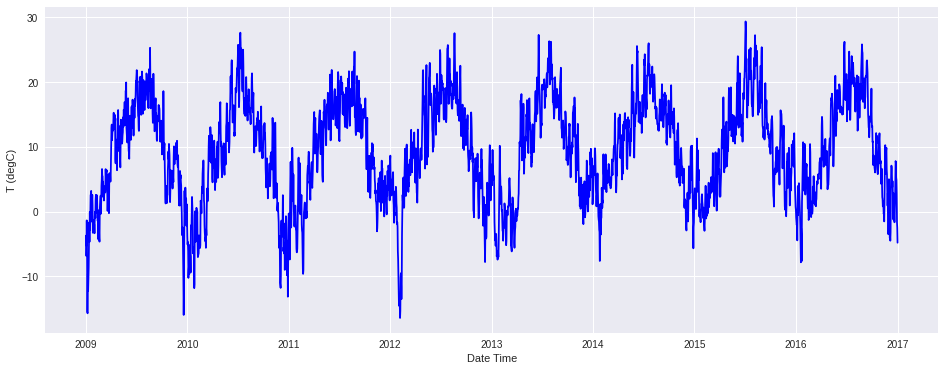

In [ ]:
f,ax = plt.subplots(figsize=(16,6))
sns.lineplot(x=resamp_mean_temp_df['Date Time'], y=resamp_mean_temp_df['T (degC)'], color='blue', ax = ax)
plt.show()

### Time Serie Analysis


Descomponemos los datos de la serie temporal en sus componentes de tendencia, temporalidad o estacionalidad y residuos.

- Descomposición estacional de la serie temporal de temperatura resampleada: muestra cuatro gráficos en uno, que representan la serie temporal original, la tendencia, la estacionalidad y los residuos.

- Utilizamos un modelo aditivo con un período estacional de 365 días.

Este tipo de análisis puede ayudarnos a identificar patrones y tendencias en la serie temporal que no son obvias a simple vista.



In [ ]:
# set the 'Date Time' column as the index
decomp_resamp_mean_temp_df = resamp_mean_temp_df.set_index('Date Time')

In [ ]:
display(decomp_resamp_mean_temp_df.head(2))

T (degC)
Date Time           
2009-01-01 -6.810629
2009-01-02 -3.728194

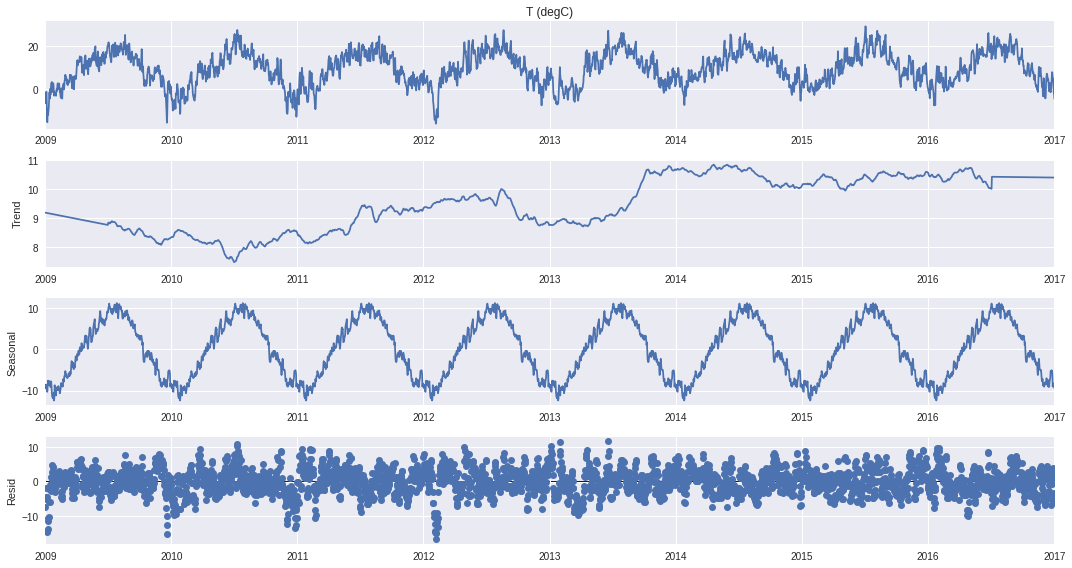

In [ ]:
plt.style.use('seaborn-v0_8')
plt.rcParams["figure.figsize"] = (15, 8)
result_decomp = seasonal_decompose(decomp_resamp_mean_temp_df['T (degC)'], period=365, model='additive', extrapolate_trend='freq')
result_decomp.plot()
plt.show()


- No hay una tendencia muy clara, la teperatura no cambia mucho. 

Condiciones que se deben cumplir para hacer forecasting:
- Temporalidad o estacionalidad: hay una fuerte estacionalidad, cada año se repite el mismo patrón. 
- Residuos bastante constantes.
- Datos estacionarios: lo veremos a continuación.



Graficamos la media y la desviación estándar para analizar si se cumple el supuesto de estacionariedad en los datos:
- Si la media y la desviación estándar son constantes en el tiempo, los datos pueden considerarse estacionarios y ser adecuados para el modelado y la predicción.

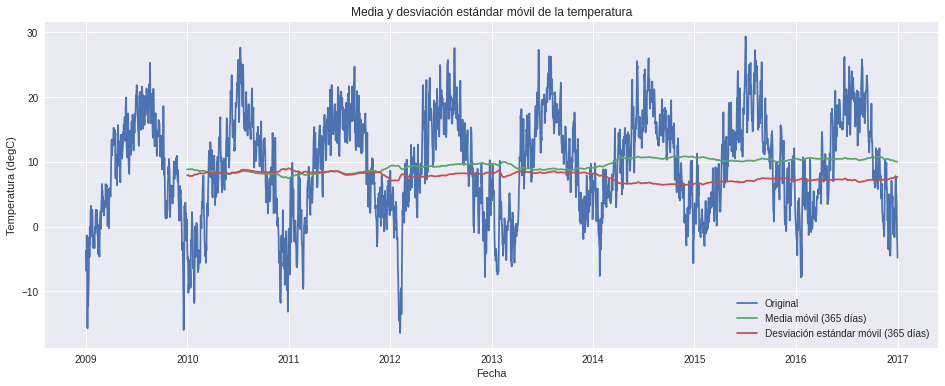

In [ ]:
# calcular la media y la desviación estándar móvil
rolling_mean = resamp_mean_temp_df['T (degC)'].rolling(window=365).mean()
rolling_std = resamp_mean_temp_df['T (degC)'].rolling(window=365).std()

# graficar la media y la desviación estándar móvil
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(resamp_mean_temp_df['Date Time'], resamp_mean_temp_df['T (degC)'], label='Original')
ax.plot(resamp_mean_temp_df['Date Time'], rolling_mean, label='Media móvil (365 días)')
ax.plot(resamp_mean_temp_df['Date Time'], rolling_std, label='Desviación estándar móvil (365 días)')

ax.set_xlabel('Fecha')
ax.set_ylabel('Temperatura (degC)')
ax.set_title('Media y desviación estándar móvil de la temperatura')
ax.legend(loc='best')

plt.show()


- Datos estacionarios: la media y la desviación estándar son constantes en el tiempo. 


Podemos contrastar que se cumplen las 3 características o requisitos para hacer predicciones. Por tanto, podremos aplicar las técnicas para hacer predicciones. 


In [ ]:
# Save df as csv to Google Drive
decomp_resamp_mean_temp_df.to_csv('decomp_resamp_mean_temp_df.csv', index=True)
!cp decomp_resamp_mean_temp_df.csv "/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/3_TimeSeries_Forecasting/" 

In [ ]:
# Read csv from Google Drive in Google Colab 
decomp_resamp_mean_temp_df = pd.read_csv('/content/drive/MyDrive/MasterDS/DeepLearning/FinalProjectDL/3_TimeSeries_Forecasting/decomp_resamp_mean_temp_df.csv')
display(decomp_resamp_mean_temp_df.head(2))
print("\n")
print(decomp_resamp_mean_temp_df.dtypes)
print("\n")
# convertimos a datetime
decomp_resamp_mean_temp_df["Date Time"] = pd.to_datetime(decomp_resamp_mean_temp_df["Date Time"], format = "%Y.%m.%d")
print(decomp_resamp_mean_temp_df.dtypes)
print("\n")
# set the 'Date Time' column as the index
decomp_resamp_mean_temp_df = decomp_resamp_mean_temp_df.set_index('Date Time')
display(decomp_resamp_mean_temp_df.head(2))

Date Time  T (degC)
0  2009-01-01 -6.810629
1  2009-01-02 -3.728194



Date Time     object
T (degC)     float64
dtype: object


Date Time    datetime64[ns]
T (degC)            float64
dtype: object




T (degC)
Date Time           
2009-01-01 -6.810629
2009-01-02 -3.728194

## Train - Test Split

Definimos la función que nos permitirá separar los atributos (X) del target (y):

- X será una secuencia de valores hasta una marca de tiempo t
- y será el valor de la secuencia en la marca de tiempo t+1

Los valores de train son incrementales y lo que hacemos es intentar predecir el siguiente punto. 


In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

Definimos los valores para la partición de X e y:

In [ ]:
# define input sequence
raw_seq = decomp_resamp_mean_temp_df['T (degC)']

# choose a number of time steps (the bigger, the longer-term knowledge will maintain but it'll also increase computational)
n_steps = 365 # por la temporalidad (365 días): tomamos los datos de un año para predecir la temperatura del día siguiente.

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# Reshape for fitting the network
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features)) # reshape para que la red neuronal no se queje cuando introduzcamos los datos

In [ ]:
X.shape

(2558, 365, 1)

In [ ]:
X.shape[0]

2558

Para entrenar nos quedamos todos los datos hasta los últimos 2 años. Entrenamos con 6 años. 

Para validar utilizaremos los datos de los últimos 2 años. 

In [ ]:
# Separación de los datos en train y test
X_train = X[:-365*2] # cogemos los primeros n-2 años (6 años) de datos como el conjunto de entrenamiento
y_train = y[0:-365*2]

X_test = X[-365*2:] # cogemos los últimos 2 años de datos como el conjunto de prueba
y_test = y[-365*2:]

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(1828, 365, 1)
(1828,)
(730, 365, 1)
(730,)


In [ ]:
# Primer registro
X[0], y[0]

## Modelos LSTM 

### Modelo 0:  

El primer modelo LSTM que probaremos es el que vimos e implementamos en clase. Partiremos de este modelo como base y lo iremos mejorando y afinando para obtener mejores resultados, es decir, mejores predicciones de la temperatura. 

In [ ]:
# 1st LSTM
lstm_temp1 = tf.keras.models.Sequential()
# 1 sola neurona
# input_shape (n_steps, n_features) por como hemos procesado los datos
lstm_temp1.add(tf.keras.layers.LSTM(1, activation='relu', input_shape=(n_steps, n_features)))
# De la sola neurona LSTM hacemos el Flatten
lstm_temp1.add(tf.keras.layers.Flatten())
# y le pasamos el MLP:
lstm_temp1.add(tf.keras.layers.Dense(256, activation='relu'))
lstm_temp1.add(Dropout(0.2))
lstm_temp1.add(tf.keras.layers.Dense(128, activation='relu'))
lstm_temp1.add(Dropout(0.2))
lstm_temp1.add(tf.keras.layers.Dense(32, activation='relu'))
lstm_temp1.add(Dropout(0.2))
lstm_temp1.add(tf.keras.layers.Dense(1))
# Le definimos la función de pérdida:
lstm_temp1.compile(optimizer='adam', loss='mse')
# fit model: entrenamos directamente
lstm_temp1.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
58/58 [==============================] - 10s 135ms/step - loss: 97.1064
Epoch 2/10
58/58 [==============================] - 8s 131ms/step - loss: 40.4916
Epoch 3/10
58/58 [==============================] - 7s 122ms/step - loss: 34.4178
Epoch 4/10
58/58 [==============================] - 7s 121ms/step - loss: 29.3074
Epoch 5/10
58/58 [==============================] - 9s 163ms/step - loss: 27.4088
Epoch 6/10
58/58 [==============================] - 10s 165ms/step - loss: 25.6758
Epoch 7/10
58/58 [==============================] - 7s 129ms/step - loss: 22.7257
Epoch 8/10
58/58 [==============================] - 8s 139ms/step - loss: 21.5945
Epoch 9/10
58/58 [==============================] - 6s 109ms/step - loss: 20.0450
Epoch 10/10
58/58 [==============================] - 8s 139ms/step - loss: 19.1146


- Observamos que el modelo ha completado el entrenamiento con 10 epochs. 
- El valor del loss disminuye con cada epoch, lo que indica que el modelo está aprendiendo de los datos. 

Después de entrenar el modelo, evaluamos su rendimiento en el conjunto de datos de prueba utilizando el error cuadrático medio (MSE), que mide la diferencia cuadrática media entre los valores predichos y los valores reales. Esta métrica da una idea del rendimiento del modelo en la predicción de los valores de temperatura.

In [ ]:
# predict on test data
y_pred = lstm_temp1.predict(X_test)

# MSE
mse = mean_squared_error(y_test, y_pred)
print('Test MSE: %.3f' % mse)


23/23 [==============================] - 1s 45ms/step
Test MSE: 10.907


- Un MSE de 10.907 significa que, de media, la diferencia al cuadrado entre los valores de temperatura predichos y los reales en el conjunto de datos de prueba es de 10.907 grados centígrados. Es decir, si la temperatura real es de 20 grados Celsius, el modelo podría predecir entre 15 y 25 grados Celsius de media.

No obstante, como siempre se recomienda utilizar varias métricas para evaluar el rendimiento del modelo, calcularemos el error medio absoluto (MAE) y el error cuadrático medio (RMSE). 
- La raíz del error cuadrático medio (RMSE) permite comprender mejor los errores en las mismas unidades que la variable objetivo. 
- El error medio absoluto (MAE) es otra métrica útil que mide las diferencias absolutas entre los valores previstos y los reales.

In [ ]:
# calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# print results
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 3.303
Test MAE: 2.669


- Podemos ver que el modelo funciona bastante bien. 
- Un MSE, RMSE y MAE bajos indican un buen rendimiento del modelo. En nuestro caso, el MSE de 10.907, el RMSE de 3.303 y el MAE de 2.669 sugieren que el modelo realiza predicciones bastante precisas en el conjunto de prueba. 

- No obstante, que esta predicción pueda considerarse buena o no, depende del contexto y del problema concreto que se intente resolver. En algunos casos, un MSE de 10 puede considerarse muy preciso, mientras que en otros puede considerarse bastante pobre. En este caso, como se intenta predecir la temperatura para una previsión meteorológica, un MSE de 10 grados centígrados podría considerarse una buena predicción, ya que los patrones meteorológicos son bastante impredecibles y un error de 10 grados centígrados podría estar dentro de un rango aceptable para la toma de decisiones.

Hacemos la predicción de los valores de temperatura de los últimos 365 días:

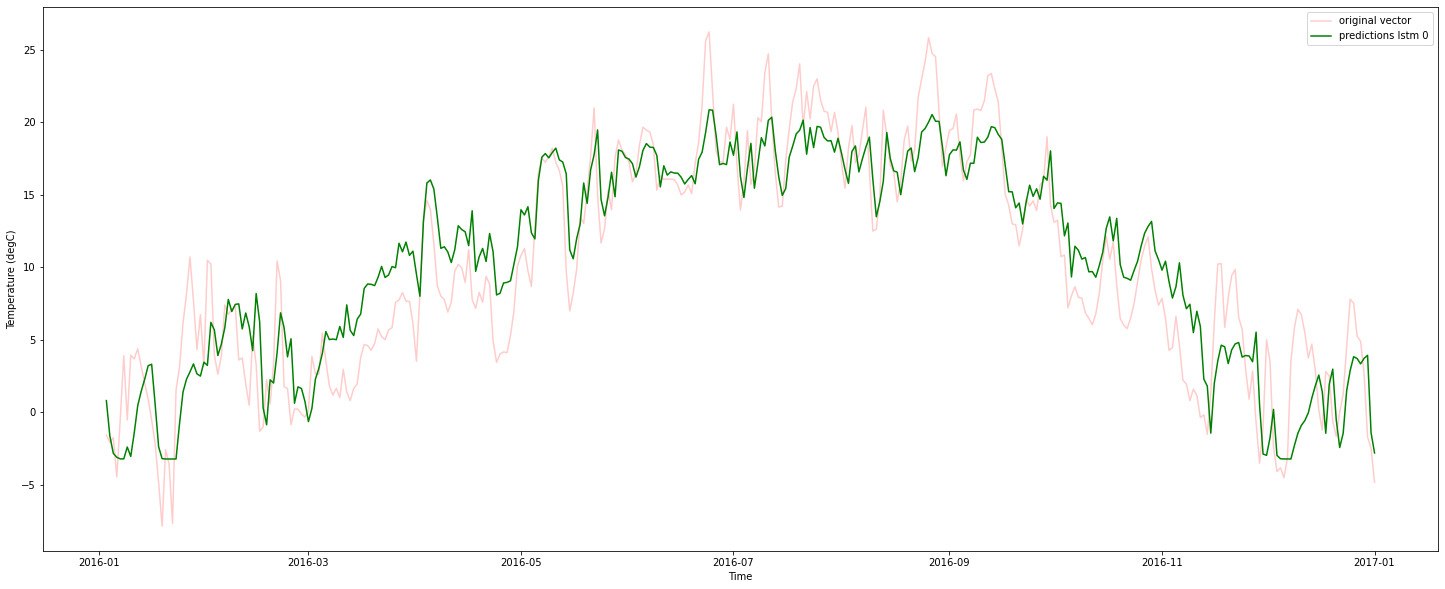

In [ ]:
# Predicting values for this LSTM 
pred_lstm0 = []
x_pred_lstm0 = []
# Predicting some of the last samples
for i in range(len(decomp_resamp_mean_temp_df['T (degC)'].values)-365, len(decomp_resamp_mean_temp_df['T (degC)'].values)):
  low_lim = i-n_steps
  up_lim = i
  x_pred_lstm0.append(decomp_resamp_mean_temp_df.index[i])  # to get the index of the current day 
  x_input = decomp_resamp_mean_temp_df['T (degC)'].values[low_lim:up_lim]
  x_input = x_input.reshape((1, n_steps, n_features))
  yhat = lstm_temp1.predict(x_input, verbose=0)
  pred_lstm0.append(yhat[0][0])

plt.figure(figsize = (25, 10))
plt.plot(x_pred_lstm0, decomp_resamp_mean_temp_df['T (degC)'][-365:], 'r', alpha = 0.2, label = 'original vector')
plt.plot(x_pred_lstm0, pred_lstm0, 'g', label = 'predictions lstm 0')
plt.xlabel('Time')
plt.ylabel('Temperature (degC)')
plt.legend()
plt.show()

Hacemos la predicción de los valores de temperatura de los últimos 730 días:

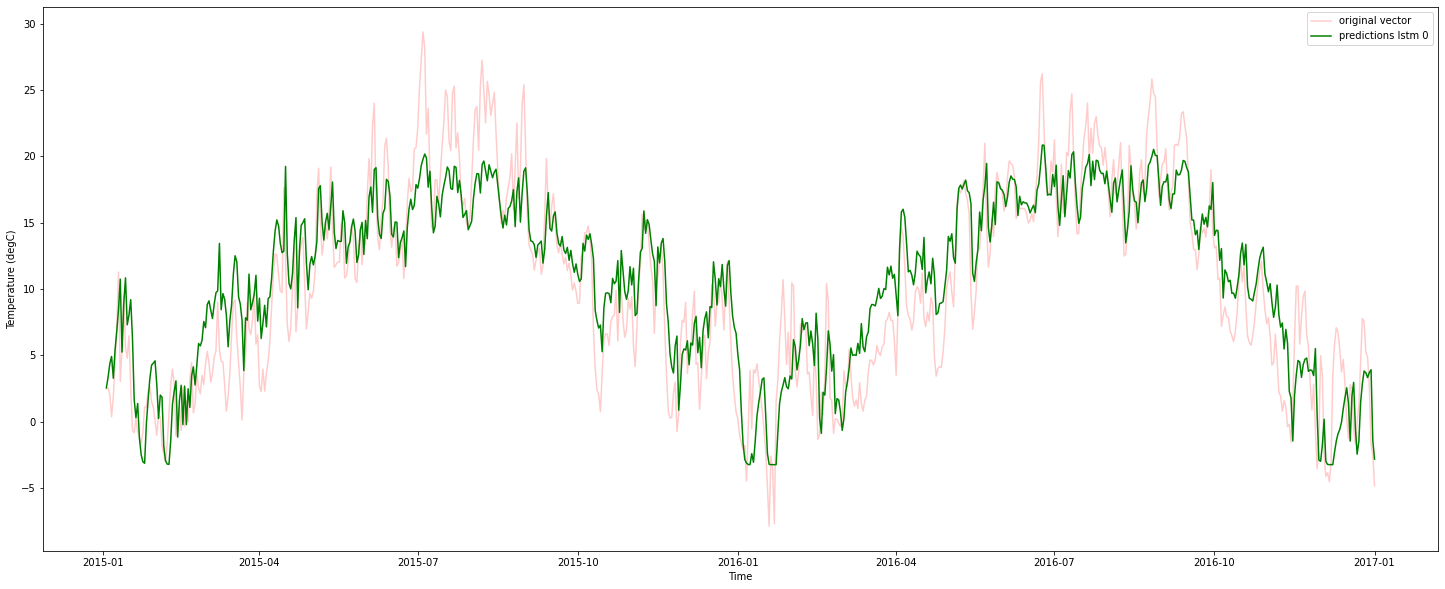

In [ ]:
# Predicting values for this LSTM 
pred_lstm0 = []
x_pred_lstm0 = []
# Predicting some of the last samples
for i in range(len(decomp_resamp_mean_temp_df['T (degC)'].values)-730, len(decomp_resamp_mean_temp_df['T (degC)'].values)):
  low_lim = i-n_steps
  up_lim = i
  x_pred_lstm0.append(decomp_resamp_mean_temp_df.index[i])  # to get the index of the current day 
  x_input = decomp_resamp_mean_temp_df['T (degC)'].values[low_lim:up_lim]
  x_input = x_input.reshape((1, n_steps, n_features))
  yhat = lstm_temp1.predict(x_input, verbose=0)
  pred_lstm0.append(yhat[0][0])

plt.figure(figsize = (25, 10))
plt.plot(x_pred_lstm0, decomp_resamp_mean_temp_df['T (degC)'][-730:], 'r', alpha = 0.2, label = 'original vector')
plt.plot(x_pred_lstm0, pred_lstm0, 'g', label = 'predictions lstm 0')
plt.xlabel('Time')
plt.ylabel('Temperature (degC)')
plt.legend()
plt.show()

- Observamos que las predicciones de temperatura se ajustan bastante bien a los valores reales. 

### Modelo 1: 

La arquitectura del siguiente modelo es una mejora con respecto a la anterior, ya que incluye:
-  Capas LSTM adicionales con dropout regularization para evitar el overfitting o sobreajuste.
- También se ha añadido un early stopping callback para detener el entrenamiento cuando la pérdida de validación deja de mejorar después de 5 epochs.
- La Dense layer sigue ahí y se utiliza para obtener la predicción final. La Dense layer se añade después de la última capa LSTM para producir un único valor de salida, que representa la temperatura predicha en el siguiente paso temporal.


In [ ]:
# define the model architecture
model = Sequential()

model.add(LSTM(units=64, input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))

model.add(Dense(units=1))

# compile the model
model.compile(optimizer='adam', loss='mse')

# define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)


# train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/10
58/58 [==============================] - 73s 1s/step - loss: 63.0427 - val_loss: 33.8620
Epoch 2/10
58/58 [==============================] - 72s 1s/step - loss: 22.4963 - val_loss: 19.9589
Epoch 3/10
58/58 [==============================] - 50s 850ms/step - loss: 16.5895 - val_loss: 14.2283
Epoch 4/10
58/58 [==============================] - 53s 924ms/step - loss: 13.2475 - val_loss: 10.3935
Epoch 5/10
58/58 [==============================] - 49s 851ms/step - loss: 10.9282 - val_loss: 8.9133
Epoch 6/10
58/58 [==============================] - 56s 964ms/step - loss: 9.1362 - val_loss: 7.3910
Epoch 7/10
58/58 [==============================] - 53s 896ms/step - loss: 8.6267 - val_loss: 6.9613
Epoch 8/10
58/58 [==============================] - 79s 1s/step - loss: 7.8288 - val_loss: 6.6324
Epoch 9/10
58/58 [==============================] - 65s 1s/step - loss: 7.3703 - val_loss: 6.7841
Epoch 10/10
58/58 [==============================] - 52s 898ms/step - loss: 7.4836 - val_loss:

- Observamos que el modelo ha completado el entrenamiento con 10 epochs. 
- El valor del loss disminuye con cada epoch, lo que indica que el modelo está aprendiendo de los datos. 
- Parece que el nuevo modelo tiene una pérdida de entrenamiento y una pérdida de validación mucho menores en comparación con el modelo anterior, lo que es una buena señal, ya que indica que el modelo funciona mejor. 



No obstante, también es importante evaluar el modelo en el conjunto de prueba para asegurarse de que se generaliza bien a los nuevos datos. Utilizaremos las mismas métricas de evaluación (MSE, RMSE, MAE) que antes para evaluar el rendimiento del conjunto de prueba.

In [ ]:
# predict on test data
y_pred_1 = model.predict(X_test)

# MSE, RMSE and MAE
mse = mean_squared_error(y_test, y_pred_1)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_1))
mae = mean_absolute_error(y_test, y_pred_1)

# print results
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

23/23 [==============================] - 7s 304ms/step
Test MSE: 6.028
Test RMSE: 2.455
Test MAE: 1.906


- Podemos observar que este nuevo modelo mejorado ha funcionado mejor que el anterior, con valores más bajos para las tres métricas de evaluación. Esto significa que el nuevo modelo predice mejor los valores del conjunto de pruebas.

Hacemos la predicción de los valores de temperatura de los últimos 365 días:

In [ ]:
# Predicting values for this LSTM 
pred_lstm1 = []
x_pred_lstm1 = []
# Predicting some of the last samples
for i in range(len(decomp_resamp_mean_temp_df['T (degC)'].values)-365, len(decomp_resamp_mean_temp_df['T (degC)'].values)):
  low_lim = i-n_steps
  up_lim = i
  x_pred_lstm1.append(decomp_resamp_mean_temp_df.index[i])
  x_input = decomp_resamp_mean_temp_df['T (degC)'].values[low_lim:up_lim]
  x_input = x_input.reshape((1, n_steps, n_features))
  yhat = model.predict(x_input, verbose=0)
  pred_lstm1.append(yhat[0][0])

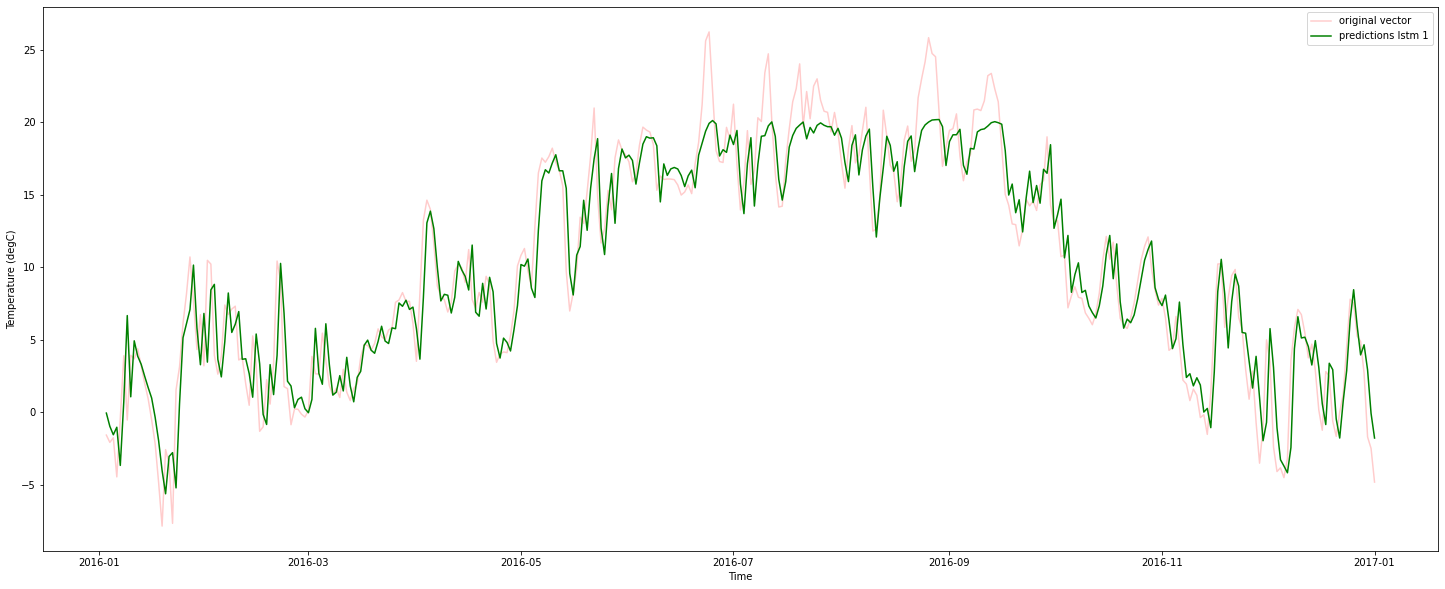

In [ ]:
plt.figure(figsize = (25, 10))
plt.plot(x_pred_lstm1, decomp_resamp_mean_temp_df['T (degC)'][-365:], 'r', alpha = 0.2, label = 'original vector')
plt.plot(x_pred_lstm1, pred_lstm1, 'g', label = 'predictions lstm 1')
plt.xlabel('Time')
plt.ylabel('Temperature (degC)')
plt.legend()
plt.show()

- Observamos que las predicciones de temperatura se ajustan mejor a los valores reales que en el caso del modelo 0. 

### Modelo 2:  

Este nuevo modelo es más sencillo que los dos anteriores, ya que sólo tiene una capa LSTM con 50 unidades y una capa de salida Dense. Sin embargo, siempre merece la pena probar diferentes arquitecturas de modelos para ver cuál funciona mejor para nuestro problema específico.

El entrenamiento se realiza durante 100 epochs y el modelo se evalúa en los datos de prueba utilizando la función de pérdida de error cuadrático medio (MSE).

In [ ]:
# define the LSTM model
model = Sequential()
# LSTM layer with 50 units and ReLU activation function
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
# dense output layer with a single output
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mse')

# fit the model to the training data
model.fit(X_train, y_train, epochs=100, verbose=1)

# evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_loss)


Epoch 1/100
58/58 [==============================] - 14s 194ms/step - loss: 34.9055
Epoch 2/100
58/58 [==============================] - 9s 159ms/step - loss: 41.0465
Epoch 3/100
58/58 [==============================] - 10s 181ms/step - loss: 34.9473
Epoch 4/100
58/58 [==============================] - 10s 173ms/step - loss: 30.6819
Epoch 5/100
58/58 [==============================] - 9s 157ms/step - loss: 27.0423
Epoch 6/100
58/58 [==============================] - 11s 183ms/step - loss: 24.1635
Epoch 7/100
58/58 [==============================] - 10s 179ms/step - loss: 21.8882
Epoch 8/100
58/58 [==============================] - 9s 154ms/step - loss: 20.0919
Epoch 9/100
58/58 [==============================] - 14s 240ms/step - loss: 18.6153
Epoch 10/100
58/58 [==============================] - 10s 181ms/step - loss: 17.3943
Epoch 11/100
58/58 [==============================] - 14s 242ms/step - loss: 16.4367
Epoch 12/100
58/58 [==============================] - 17s 293ms/step - loss: 

- Observamos que el modelo ha completado el entrenamiento con 100 epochs. 
- Según el historial de entrenamiento, la loss del modelo disminuye a lo largo del entrenamiento. Esto es una buena señal, ya que significa que el modelo está aprendiendo gradualmente a hacer mejores predicciones. 
- Parece que este nuevo y simple modelo tiene una pérdida de entrenamiento menor en comparación con los modelos anteriores, lo que es una buena señal, ya que indica que el modelo funciona mejor. 

- No obstante, es importante señalar que la diferencia en los valores de pérdida entre los dos últimos modelos (modelo 1 y modelo 2) es bastante pequeña, por lo que es posible que el modelo más sencillo esté sobreajustándose o no generalice tan bien como el modelo anterior. 

- Además, este tercer modelo más sencillo no ha funcionado tan bien como el segundo modelo (Modelo 1). 
  - El Test MSE del modelo más sencillo es de 7.21, superior al Test MSE del segundo modelo, que fue de 6.028. Por tanto, la arquitectura más compleja utilizada en el segundo modelo es más adecuada para este problema. También es posible que un mayor ajuste de los hiperparámetros mejore el rendimiento de los modelos.

Hacemos la predicción de los valores de temperatura de los últimos 365 días:

In [ ]:
# Predicting values for this LSTM 
pred_lstm2 = []
x_pred_lstm2 = []
# Predicting some of the last samples
for i in range(len(decomp_resamp_mean_temp_df['T (degC)'].values)-365, len(decomp_resamp_mean_temp_df['T (degC)'].values)):
  low_lim = i-n_steps
  up_lim = i
  x_pred_lstm2.append(decomp_resamp_mean_temp_df.index[i])
  x_input = decomp_resamp_mean_temp_df['T (degC)'].values[low_lim:up_lim]
  x_input = x_input.reshape((1, n_steps, n_features))
  yhat = model.predict(x_input, verbose=0)
  pred_lstm2.append(yhat[0][0])

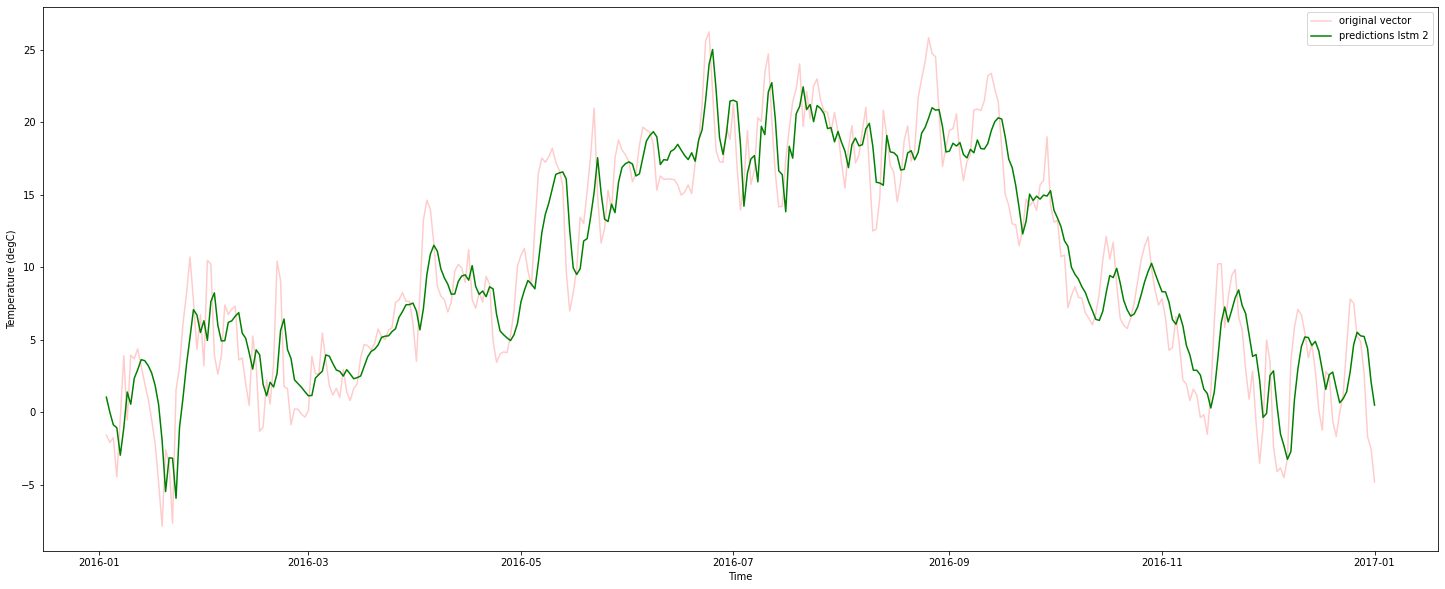

In [ ]:
plt.figure(figsize = (25, 10))
plt.plot(x_pred_lstm2, decomp_resamp_mean_temp_df['T (degC)'][-365:], 'r', alpha = 0.2, label = 'original vector')
plt.plot(x_pred_lstm2, pred_lstm2, 'g', label = 'predictions lstm 2')
plt.xlabel('Time')
plt.ylabel('Temperature (degC)')
plt.legend()
plt.show()

- Observamos que las predicciones de temperatura se ajustan mejor a los valores reales que en el caso del modelo 0, pero no que en el caso del modelo 1. 



## Conclusiones 

Por tanto, podemos concluir que aunque los 3 modelos funcionan relativamente bien, el segundo modelo (Modelo 1) es el que mejor predice la temperatura.

Un MSE, RMSE y MAE bajos indican un buen rendimiento del modelo. En el caso del Modelo 1 (el segundo modelo), el MSE de 6.028, el RMSE de 2.455 y el MAE de 1.906 sugieren que el modelo realiza predicciones bastante precisas en el conjunto de prueba.

En este caso, como se intenta predecir la temperatura para una previsión meteorológica, un MSE de 6 grados centígrados podría considerarse una buena predicción, ya que los patrones meteorológicos son bastante impredecibles y un error de 6 grados centígrados podría estar dentro de un rango aceptable para la toma de decisiones.